<a href="https://colab.research.google.com/github/chhamman0210/auth0-angular-samples/blob/master/DownscalingResearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Load and Explore Data of wind speed

In [ ]:
!pip install scikeras

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
file_path = "/content/drive/MyDrive/My Work/GCM_IMD_2005_2016_Wind_speed.csv"
data = pd.read_csv(file_path)

# Clean column names
data.columns = data.columns.str.strip()

# Convert date columns to a single datetime column
data['Date'] = pd.to_datetime(data[['YEAR', 'MONTH', 'DAY']], errors='coerce')
data.set_index('Date', inplace=True)

# Basic exploration
print("Dataset Overview:")
print(data.info())
print(data.describe())

# Preview the first few rows
data.head()


Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4383 entries, 2005-01-01 to 2016-12-31
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   YEAR            4383 non-null   int64  
 1   MONTH           4383 non-null   int64  
 2   DAY             4383 non-null   int64  
 3   GCM_WIND_SPEED  4383 non-null   float64
 4   IMD_Wind_Speed  4383 non-null   float64
dtypes: float64(2), int64(3)
memory usage: 205.5 KB
None
              YEAR        MONTH          DAY  GCM_WIND_SPEED  IMD_Wind_Speed
count  4383.000000  4383.000000  4383.000000     4383.000000     4383.000000
mean   2010.501027     6.522930    15.729637        2.324289        1.506391
std       3.452545     3.449097     8.801096        1.093873        1.052092
min    2005.000000     1.000000     1.000000        0.480000        0.000000
25%    2008.000000     4.000000     8.000000        1.510000        0.830000
50%    2011.000000     7

YEAR  MONTH  DAY  GCM_WIND_SPEED  IMD_Wind_Speed
Date                                                        
2005-01-01  2005      1    1            0.88            5.00
2005-01-02  2005      1    2            1.09            1.11
2005-01-03  2005      1    3            2.29            1.11
2005-01-04  2005      1    4            2.12            1.11
2005-01-05  2005      1    5            1.65            1.11

# Preprocess Data

In [ ]:
import pandas as pd

# Load dataset (copied from ipython-input-4-1cb7d979005d)
file_path = "/content/drive/MyDrive/My Work/GCM_IMD_2005_2016_Wind_speed.csv"
data = pd.read_csv(file_path)

# Clean column names
data.columns = data.columns.str.strip()

# Convert date columns to a single datetime column
data['Date'] = pd.to_datetime(data[['YEAR', 'MONTH', 'DAY']], errors='coerce')
data.set_index('Date', inplace=True)


# Ensure wind speed columns are numeric
data['IMD_Wind_Speed'] = pd.to_numeric(data['IMD_Wind_Speed'], errors='coerce')
data['GCM_WIND_SPEED'] = pd.to_numeric(data['GCM_WIND_SPEED'], errors='coerce')

# Remove rows with missing values (or impute as required)
data.dropna(subset=['IMD_Wind_Speed', 'GCM_WIND_SPEED'], inplace=True)

# Resample to daily mean (if needed) to ensure uniformity
data = data.resample('D').mean()

# Confirm missing data handling
print("Remaining Missing Data:")
print(data.isnull().sum())

Remaining Missing Data:
YEAR              0
MONTH             0
DAY               0
GCM_WIND_SPEED    0
IMD_Wind_Speed    0
dtype: int64


In [ ]:
# Ensure the dataset is resampled daily to avoid any gaps
data = data.asfreq('D')

# Check for missing values
missing_values = data.isnull().sum()
print("Missing values per column:\n", missing_values)

# Impute or drop missing values if any
if missing_values.sum() > 0:
    print("Handling missing values...")
    data = data.fillna(method='ffill')  # Forward fill for imputation
    # Alternatively, you can use: data.dropna(inplace=True)

# Confirm the continuity of the dataset after resampling
print("\nDataset after handling missing values:")
print(data.info())

# Create normalized or scaled columns (optional for machine learning models)
data['Normalized_GCM_WIND_SPEED'] = (data['GCM_WIND_SPEED'] - data['GCM_WIND_SPEED'].mean()) / data['GCM_WIND_SPEED'].std()
data['Normalized_IMD_Wind_Speed'] = (data['IMD_Wind_Speed'] - data['IMD_Wind_Speed'].mean()) / data['IMD_Wind_Speed'].std()

# Save preprocessed dataset for future use
preprocessed_path = r"/content/drive/MyDrive/My Work/Preprocessed_Wind_Speed_Data.csv"
data.to_csv(preprocessed_path)

print(f"\nPreprocessed dataset saved to: {preprocessed_path}")


Missing values per column:
 YEAR              0
MONTH             0
DAY               0
GCM_WIND_SPEED    0
IMD_Wind_Speed    0
dtype: int64

Dataset after handling missing values:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4383 entries, 2005-01-01 to 2016-12-31
Freq: D
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   YEAR            4383 non-null   float64
 1   MONTH           4383 non-null   float64
 2   DAY             4383 non-null   float64
 3   GCM_WIND_SPEED  4383 non-null   float64
 4   IMD_Wind_Speed  4383 non-null   float64
dtypes: float64(5)
memory usage: 205.5 KB
None

Preprocessed dataset saved to: /content/drive/MyDrive/My Work/Preprocessed_Wind_Speed_Data.csv


# Step 2: Visualize Time Series Before Downscaling


Statistical Metrics:
Mean Squared Error (MSE): 1.74
Root Mean Squared Error (RMSE): 1.32
Mean Absolute Error (MAE): 1.05
R-squared (R²): -0.58
Correlation: 0.53


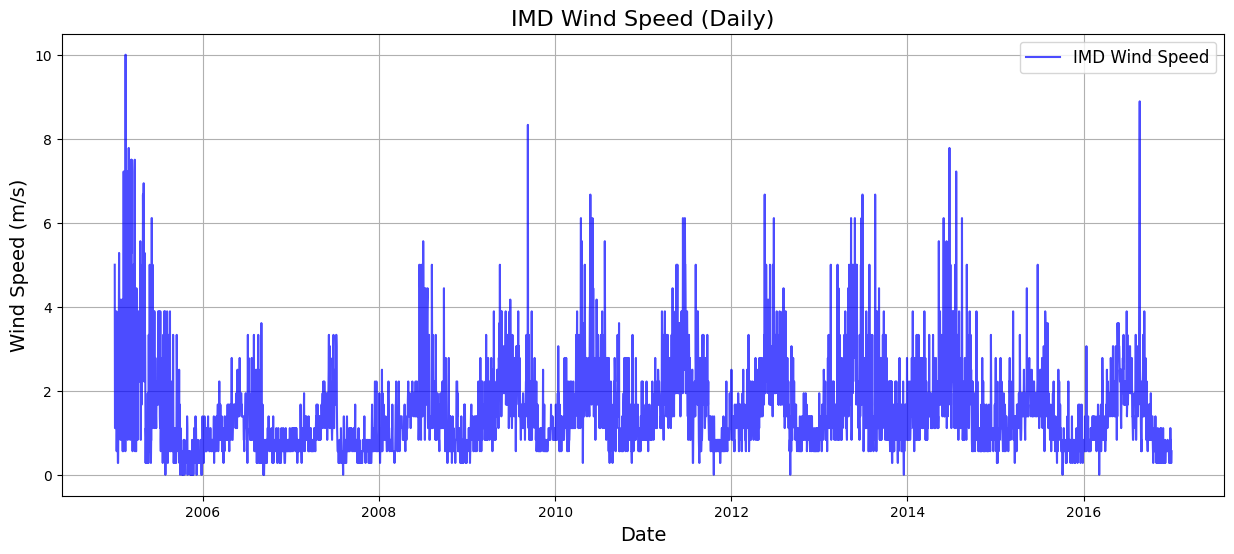

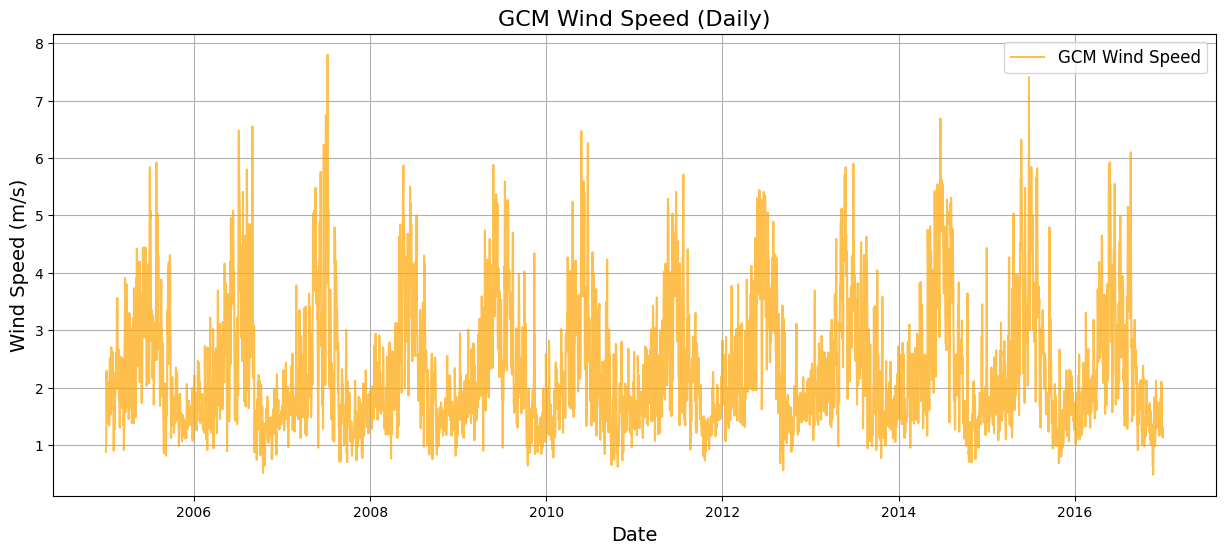

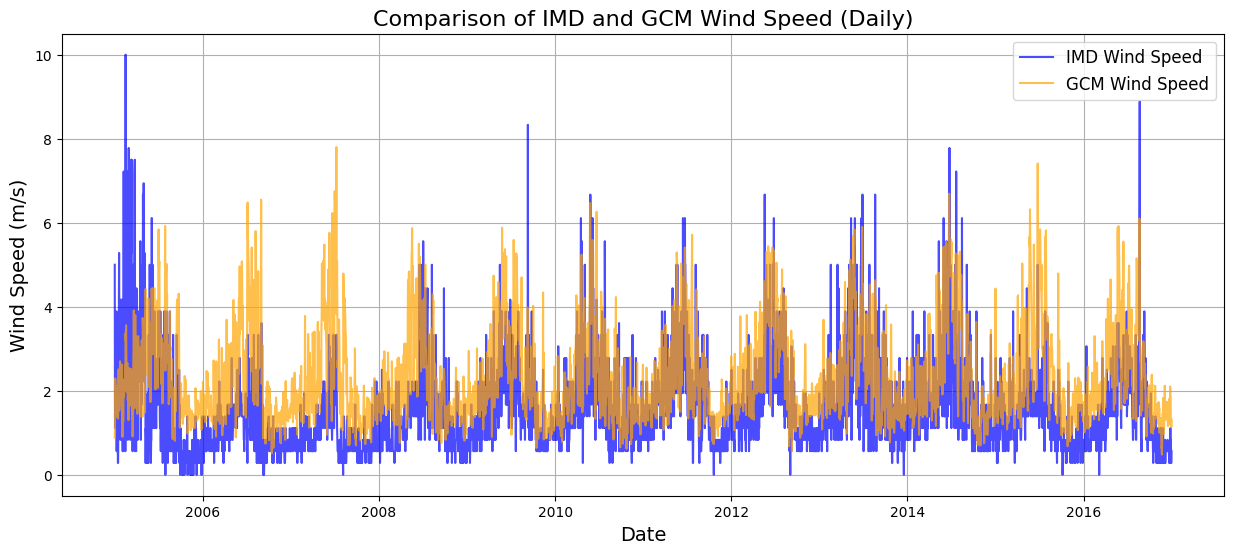

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Load dataset
file_path = "/content/drive/MyDrive/My Work/GCM_IMD_2005_2016_Wind_speed.csv"
data = pd.read_csv(file_path)

# Clean column names
data.columns = data.columns.str.strip()

# Convert date columns to a single datetime column
data['Date'] = pd.to_datetime(data[['YEAR', 'MONTH', 'DAY']], errors='coerce')
data.set_index('Date', inplace=True)

# Ensure no missing values in GCM_WIND_SPEED and IMD_Wind_Speed columns
if data[['GCM_WIND_SPEED', 'IMD_Wind_Speed']].isnull().any().any():
    print("Warning: Missing values detected. Dropping rows with missing values.")
    data = data.dropna(subset=['GCM_WIND_SPEED', 'IMD_Wind_Speed'])

# Compute statistical metrics
bias = data['GCM_WIND_SPEED'] - data['IMD_Wind_Speed']
mse = mean_squared_error(data['IMD_Wind_Speed'], data['GCM_WIND_SPEED'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(data['IMD_Wind_Speed'], data['GCM_WIND_SPEED'])
r2 = r2_score(data['IMD_Wind_Speed'], data['GCM_WIND_SPEED'])
correlation = data['IMD_Wind_Speed'].corr(data['GCM_WIND_SPEED'])

# Print statistical metrics
print("\nStatistical Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²): {r2:.2f}")
print(f"Correlation: {correlation:.2f}")

# Plot IMD wind speed
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['IMD_Wind_Speed'], label='IMD Wind Speed', color='blue', alpha=0.7)
plt.title("IMD Wind Speed (Daily)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Plot GCM wind speed
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['GCM_WIND_SPEED'], label='GCM Wind Speed', color='orange', alpha=0.7)
plt.title("GCM Wind Speed (Daily)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Combined plot for comparison
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['IMD_Wind_Speed'], label='IMD Wind Speed', color='blue', alpha=0.7)
plt.plot(data.index, data['GCM_WIND_SPEED'], label='GCM Wind Speed', color='orange', alpha=0.7)
plt.title("Comparison of IMD and GCM Wind Speed (Daily)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()


# Step 3: Singular Spectrum Analysis (SSA) smoothing to the IMD and GCM wind speed data

In [ ]:
# Install the pyssa library
!pip install pyssa



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 783.9/783.9 kB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyssa: filename=pyssa-0.9.1-cp310-cp310-linux_x86_64.whl size=2435892 sha256=29992214fc0f6b2e337a54e0ae2103e60b6501fd89f88be6e37f610b93cb6540
  Stored in directory: /root/.cache/pip/wheels/f5/54/cd/476bde3213ee5270c21943f6b5042d5089152fe9ed3fd888d5
Successfully built pyssa


In [ ]:
!pip install pyts


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 29.2 MB/s eta 0:00:00


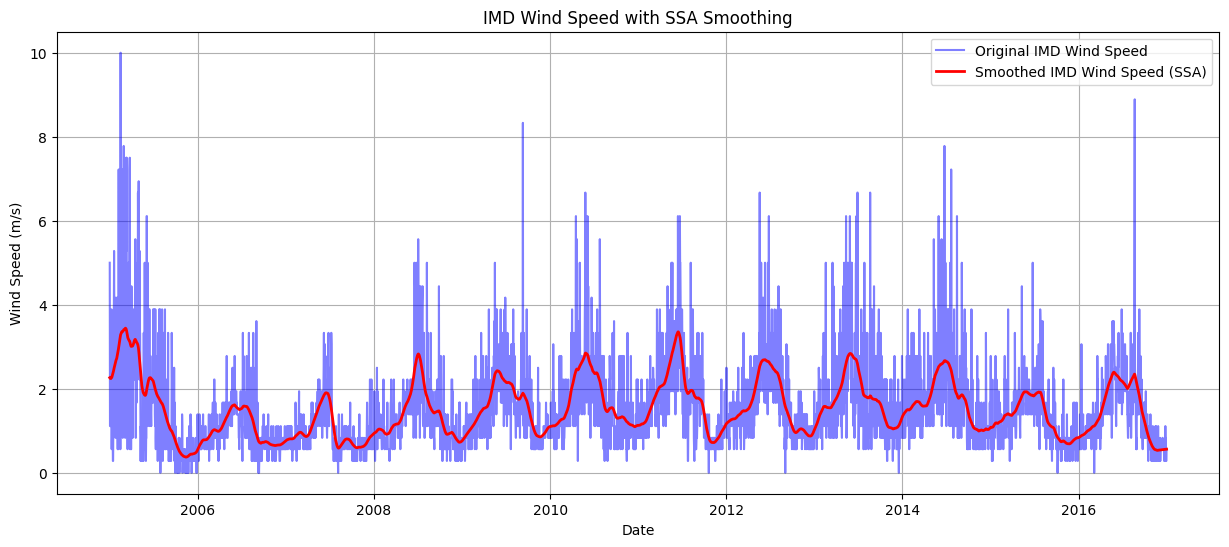

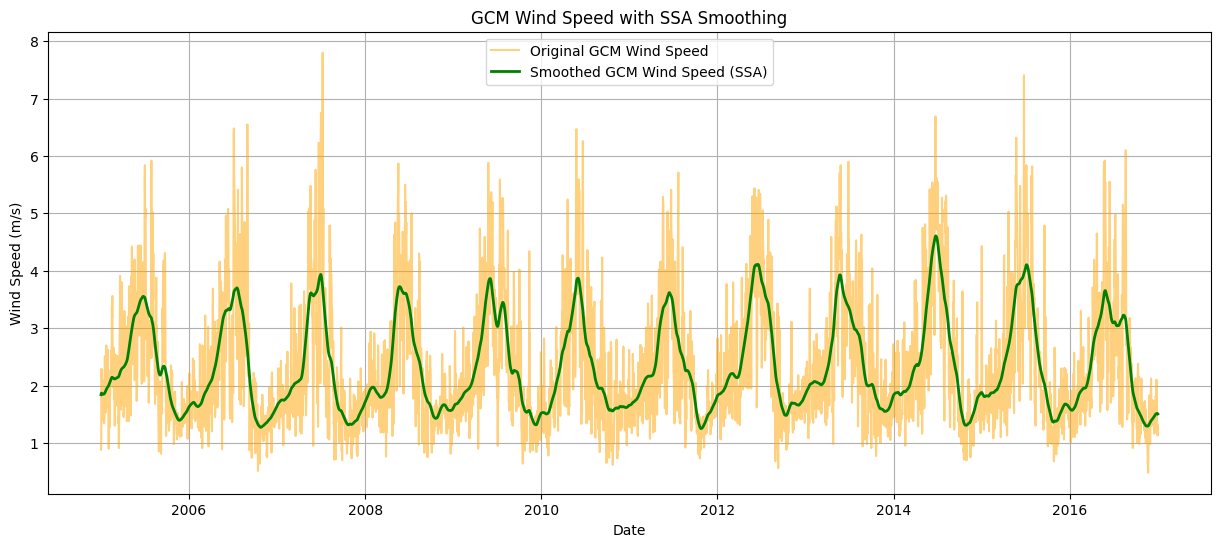

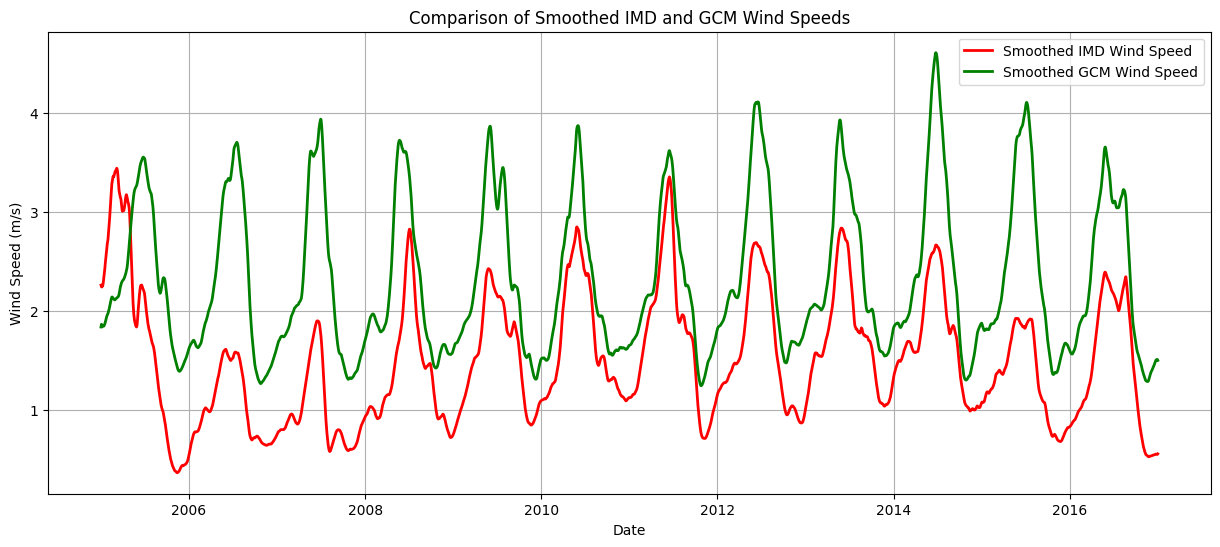


Smoothed Data Evaluation Metrics:
Mean Squared Error (MSE): 0.94
Root Mean Squared Error (RMSE): 0.97
Mean Absolute Error (MAE): 0.86
R-squared (R²): -1.18
Correlation: 0.76


In [ ]:
from pyts.decomposition import SingularSpectrumAnalysis
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Ensure no missing values in wind speed columns before SSA
data = data.dropna(subset=['IMD_Wind_Speed', 'GCM_WIND_SPEED'])

# Apply SSA for IMD Wind Speed
imd_series = data['IMD_Wind_Speed'].values.reshape(1, -1)  # Reshape for SSA
ssa_imd = SingularSpectrumAnalysis(window_size=30)
imd_components = ssa_imd.fit_transform(imd_series)

# Reconstruct IMD wind speed (using the first component for trend)
imd_smoothed = imd_components[:, 0].flatten()  # Take the first component (trend)

# Apply SSA for GCM Wind Speed
gcm_series = data['GCM_WIND_SPEED'].values.reshape(1, -1)  # Reshape for SSA
ssa_gcm = SingularSpectrumAnalysis(window_size=30)
gcm_components = ssa_gcm.fit_transform(gcm_series)

# Reconstruct GCM wind speed (using the first component for trend)
gcm_smoothed = gcm_components[:, 0].flatten()  # Take the first component (trend)

# Add smoothed data to the original DataFrame
data['IMD_Smoothed'] = imd_smoothed
data['GCM_Smoothed'] = gcm_smoothed

# Plot smoothed IMD wind speed
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['IMD_Wind_Speed'], label='Original IMD Wind Speed', color='blue', alpha=0.5)
plt.plot(data.index, data['IMD_Smoothed'], label='Smoothed IMD Wind Speed (SSA)', color='red', linewidth=2)
plt.title("IMD Wind Speed with SSA Smoothing")
plt.xlabel("Date")
plt.ylabel("Wind Speed (m/s)")
plt.legend()
plt.grid()
plt.show()

# Plot smoothed GCM wind speed
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['GCM_WIND_SPEED'], label='Original GCM Wind Speed', color='orange', alpha=0.5)
plt.plot(data.index, data['GCM_Smoothed'], label='Smoothed GCM Wind Speed (SSA)', color='green', linewidth=2)
plt.title("GCM Wind Speed with SSA Smoothing")
plt.xlabel("Date")
plt.ylabel("Wind Speed (m/s)")
plt.legend()
plt.grid()
plt.show()

# Combined plot for comparison
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['IMD_Smoothed'], label='Smoothed IMD Wind Speed', color='red', linewidth=2)
plt.plot(data.index, data['GCM_Smoothed'], label='Smoothed GCM Wind Speed', color='green', linewidth=2)
plt.title("Comparison of Smoothed IMD and GCM Wind Speeds")
plt.xlabel("Date")
plt.ylabel("Wind Speed (m/s)")
plt.legend()
plt.grid()
plt.show()

# Recalculate evaluation metrics for smoothed data
# Drop any remaining missing values in smoothed data
data = data.dropna(subset=['IMD_Smoothed', 'GCM_Smoothed'])

bias_smoothed = data['GCM_Smoothed'] - data['IMD_Smoothed']
mse_smoothed = mean_squared_error(data['IMD_Smoothed'], data['GCM_Smoothed'])
rmse_smoothed = np.sqrt(mse_smoothed)
mae_smoothed = mean_absolute_error(data['IMD_Smoothed'], data['GCM_Smoothed'])
r2_smoothed = r2_score(data['IMD_Smoothed'], data['GCM_Smoothed'])
correlation_smoothed = data['IMD_Smoothed'].corr(data['GCM_Smoothed'])

# Print evaluation metrics for smoothed data
print("\nSmoothed Data Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse_smoothed:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_smoothed:.2f}")
print(f"Mean Absolute Error (MAE): {mae_smoothed:.2f}")
print(f"R-squared (R²): {r2_smoothed:.2f}")
print(f"Correlation: {correlation_smoothed:.2f}")


Visualization for 1 Year (2016)


Statistical Metrics for 2016:
Mean Squared Error (MSE): 1.26
Root Mean Squared Error (RMSE): 1.12
Mean Absolute Error (MAE): 0.95
R-squared (R²): -0.40
Correlation: 0.76


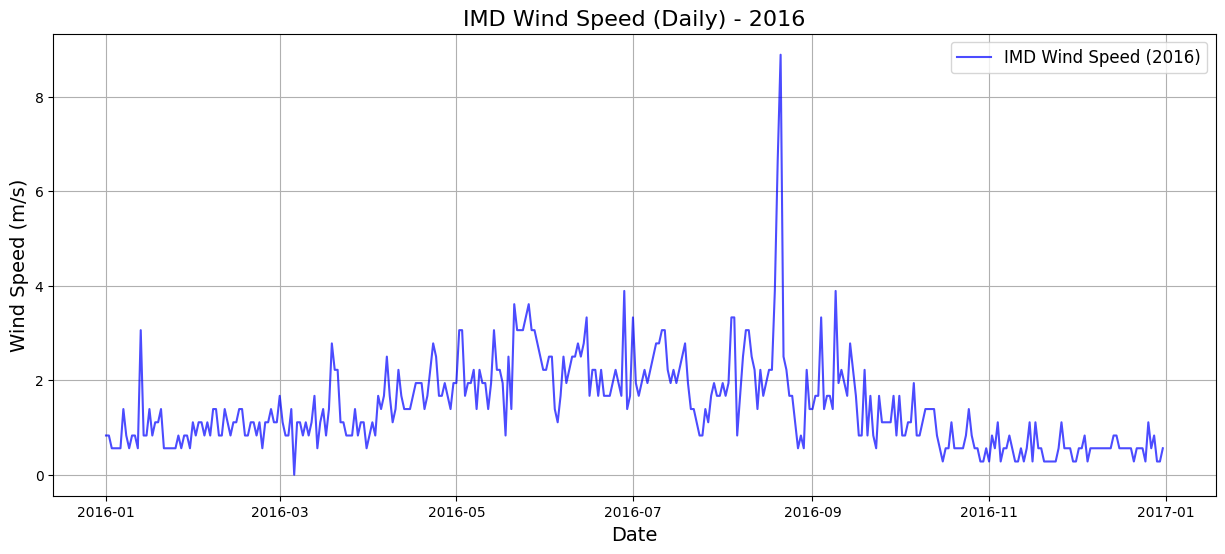

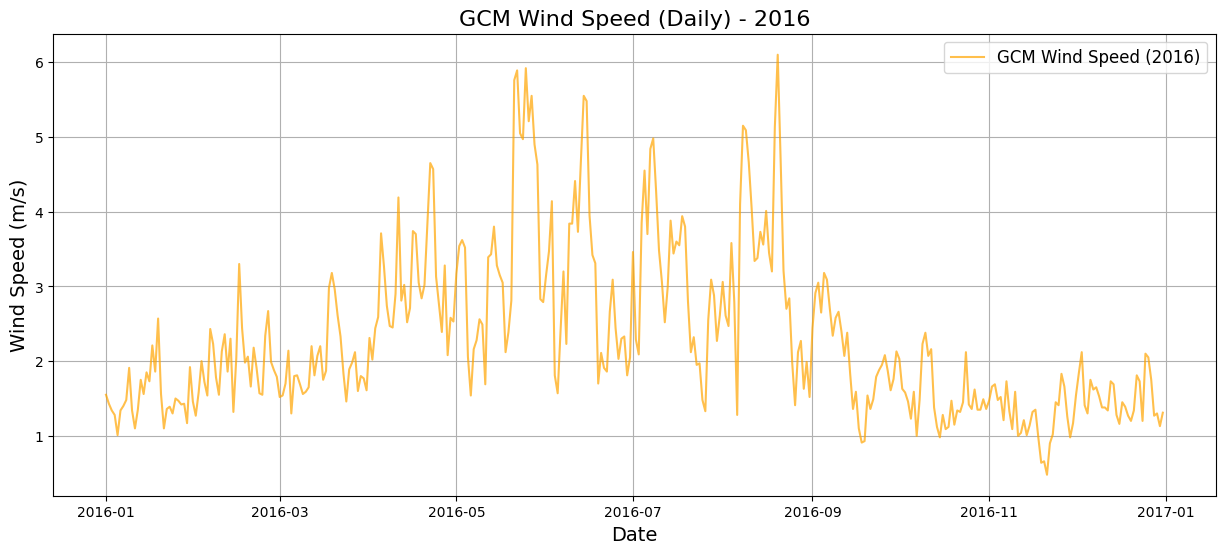

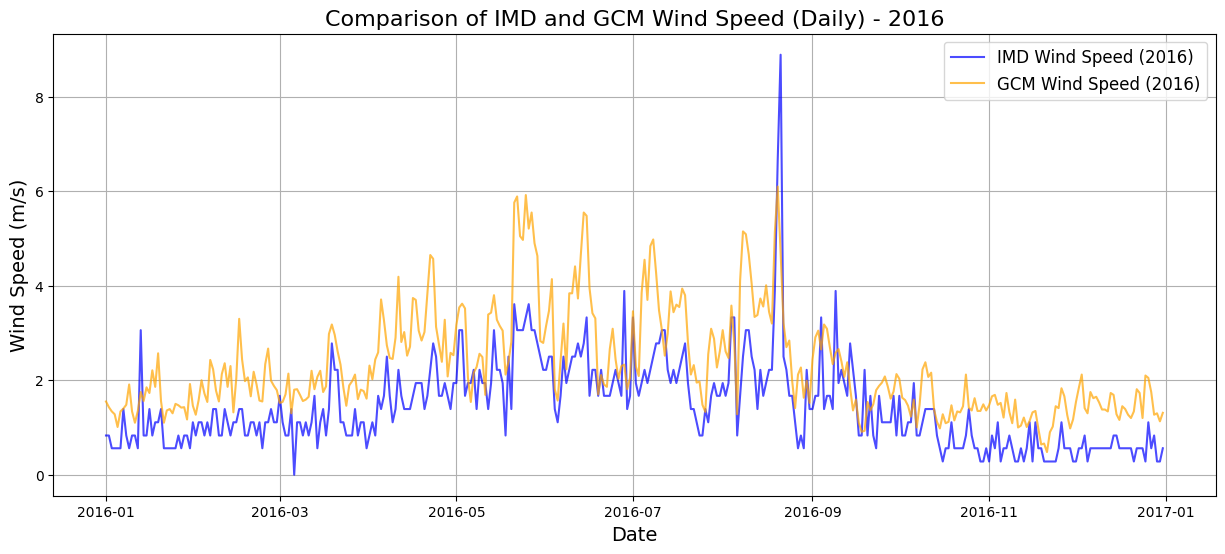

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Filter data for 2016
data_2016 = data.loc['2016'].copy()

# Ensure no missing values in the filtered data
data_2016 = data_2016.dropna(subset=['IMD_Wind_Speed', 'GCM_WIND_SPEED'])

# Compute statistical metrics for 2016
bias_2016 = data_2016['GCM_WIND_SPEED'] - data_2016['IMD_Wind_Speed']
mse_2016 = mean_squared_error(data_2016['IMD_Wind_Speed'], data_2016['GCM_WIND_SPEED'])
rmse_2016 = np.sqrt(mse_2016)
mae_2016 = mean_absolute_error(data_2016['IMD_Wind_Speed'], data_2016['GCM_WIND_SPEED'])
r2_2016 = r2_score(data_2016['IMD_Wind_Speed'], data_2016['GCM_WIND_SPEED'])
correlation_2016 = data_2016['IMD_Wind_Speed'].corr(data_2016['GCM_WIND_SPEED'])

# Print statistical metrics for 2016
print("\nStatistical Metrics for 2016:")
print(f"Mean Squared Error (MSE): {mse_2016:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_2016:.2f}")
print(f"Mean Absolute Error (MAE): {mae_2016:.2f}")
print(f"R-squared (R²): {r2_2016:.2f}")
print(f"Correlation: {correlation_2016:.2f}")

# Plot IMD wind speed for 2016
plt.figure(figsize=(15, 6))
plt.plot(data_2016.index, data_2016['IMD_Wind_Speed'], label='IMD Wind Speed (2016)', color='blue', alpha=0.7)
plt.title("IMD Wind Speed (Daily) - 2016", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Plot GCM wind speed for 2016
plt.figure(figsize=(15, 6))
plt.plot(data_2016.index, data_2016['GCM_WIND_SPEED'], label='GCM Wind Speed (2016)', color='orange', alpha=0.7)
plt.title("GCM Wind Speed (Daily) - 2016", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Combined plot for comparison for 2016
plt.figure(figsize=(15, 6))
plt.plot(data_2016.index, data_2016['IMD_Wind_Speed'], label='IMD Wind Speed (2016)', color='blue', alpha=0.7)
plt.plot(data_2016.index, data_2016['GCM_WIND_SPEED'], label='GCM Wind Speed (2016)', color='orange', alpha=0.7)
plt.title("Comparison of IMD and GCM Wind Speed (Daily) - 2016", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()


Statistical Metrics for Smoothed Data in 2016:
Mean Squared Error (MSE): 0.80
Root Mean Squared Error (RMSE): 0.89
Mean Absolute Error (MAE): 0.87
R-squared (R²): -0.91
Correlation: 0.97


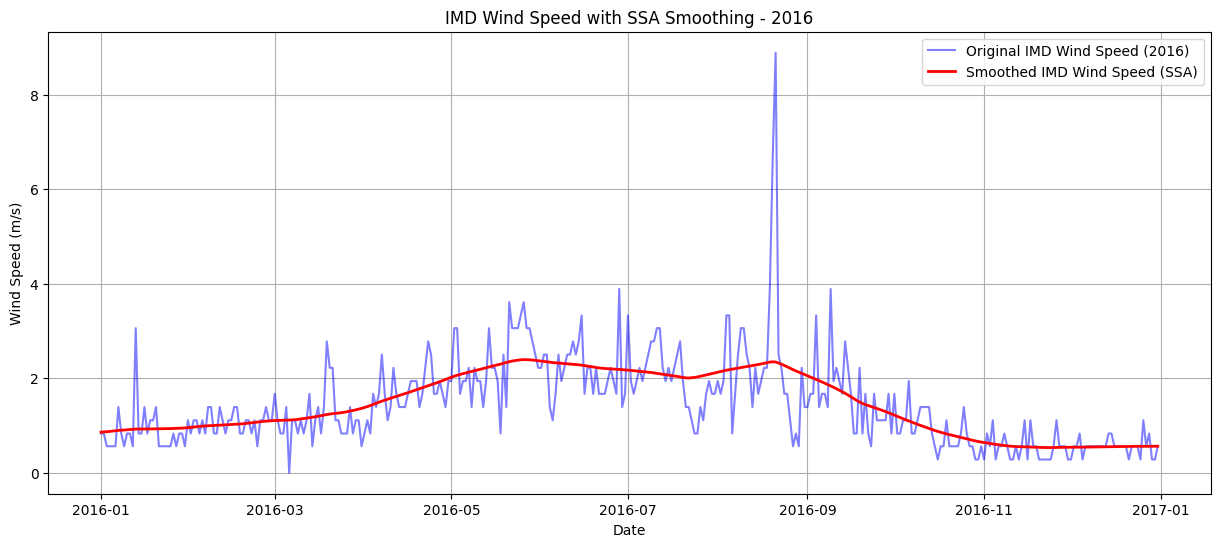

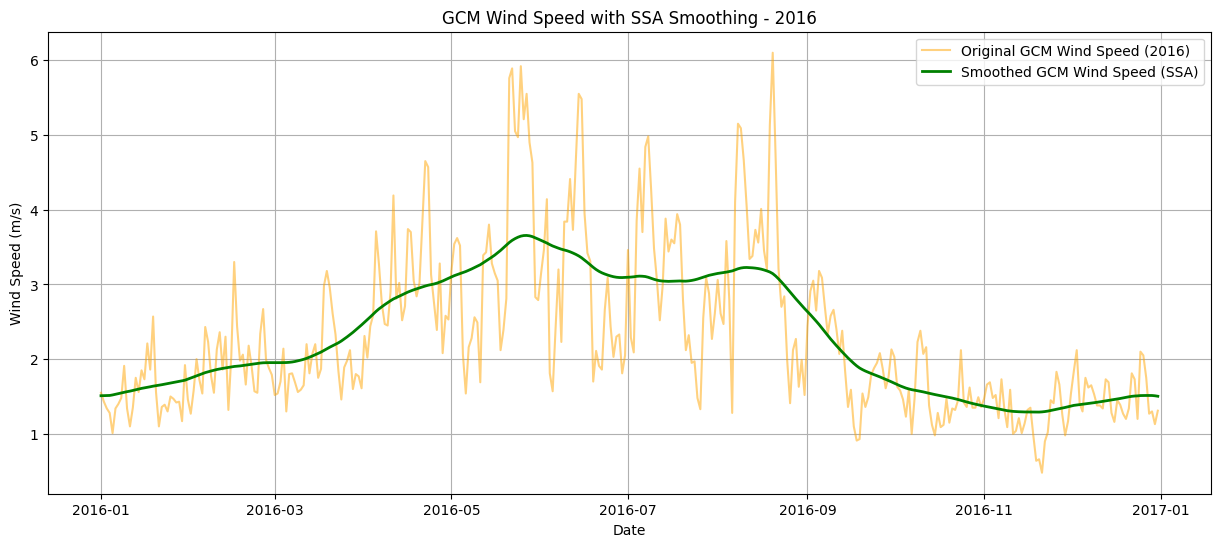

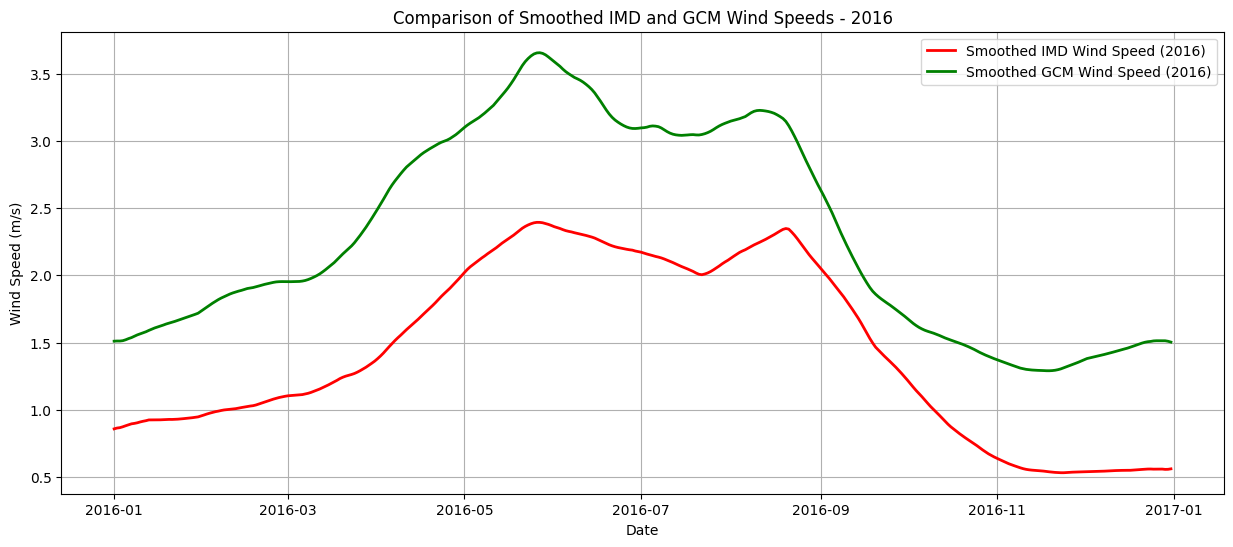

In [ ]:
import pandas as pd
from pyts.decomposition import SingularSpectrumAnalysis
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Ensure a copy of the 2016 data to avoid modifying the original DataFrame
data_2016 = data.loc['2016'].copy()

# Handle missing values to ensure SSA runs smoothly
data_2016 = data_2016.dropna(subset=['IMD_Wind_Speed', 'GCM_WIND_SPEED'])

# Apply SSA for IMD Wind Speed in 2016
imd_series_2016 = data_2016['IMD_Wind_Speed'].values.reshape(1, -1)  # Reshape for SSA
ssa_imd_2016 = SingularSpectrumAnalysis(window_size=30)
imd_components_2016 = ssa_imd_2016.fit_transform(imd_series_2016)

# Reconstruct IMD wind speed (using the first component for trend)
imd_smoothed_2016 = imd_components_2016[:, 0].flatten()

# Apply SSA for GCM Wind Speed in 2016
gcm_series_2016 = data_2016['GCM_WIND_SPEED'].values.reshape(1, -1)  # Reshape for SSA
ssa_gcm_2016 = SingularSpectrumAnalysis(window_size=30)
gcm_components_2016 = ssa_gcm_2016.fit_transform(gcm_series_2016)

# Reconstruct GCM wind speed (using the first component for trend)
gcm_smoothed_2016 = gcm_components_2016[:, 0].flatten()

# Add smoothed data to the 2016 DataFrame
data_2016['IMD_Smoothed'] = imd_smoothed_2016
data_2016['GCM_Smoothed'] = gcm_smoothed_2016

# Statistical metrics for smoothed data in 2016
bias_2016 = data_2016['GCM_Smoothed'] - data_2016['IMD_Smoothed']
mse_2016 = mean_squared_error(data_2016['IMD_Smoothed'], data_2016['GCM_Smoothed'])
rmse_2016 = np.sqrt(mse_2016)
mae_2016 = mean_absolute_error(data_2016['IMD_Smoothed'], data_2016['GCM_Smoothed'])
r2_2016 = r2_score(data_2016['IMD_Smoothed'], data_2016['GCM_Smoothed'])
correlation_2016 = data_2016['IMD_Smoothed'].corr(data_2016['GCM_Smoothed'])

# Print statistical metrics for smoothed data
print("Statistical Metrics for Smoothed Data in 2016:")
print(f"Mean Squared Error (MSE): {mse_2016:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_2016:.2f}")
print(f"Mean Absolute Error (MAE): {mae_2016:.2f}")
print(f"R-squared (R²): {r2_2016:.2f}")
print(f"Correlation: {correlation_2016:.2f}")

# Plot smoothed IMD wind speed for 2016
plt.figure(figsize=(15, 6))
plt.plot(data_2016.index, data_2016['IMD_Wind_Speed'], label='Original IMD Wind Speed (2016)', color='blue', alpha=0.5)
plt.plot(data_2016.index, data_2016['IMD_Smoothed'], label='Smoothed IMD Wind Speed (SSA)', color='red', linewidth=2)
plt.title("IMD Wind Speed with SSA Smoothing - 2016")
plt.xlabel("Date")
plt.ylabel("Wind Speed (m/s)")
plt.legend()
plt.grid()
plt.show()

# Plot smoothed GCM wind speed for 2016
plt.figure(figsize=(15, 6))
plt.plot(data_2016.index, data_2016['GCM_WIND_SPEED'], label='Original GCM Wind Speed (2016)', color='orange', alpha=0.5)
plt.plot(data_2016.index, data_2016['GCM_Smoothed'], label='Smoothed GCM Wind Speed (SSA)', color='green', linewidth=2)
plt.title("GCM Wind Speed with SSA Smoothing - 2016")
plt.xlabel("Date")
plt.ylabel("Wind Speed (m/s)")
plt.legend()
plt.grid()
plt.show()

# Combined plot for comparison for 2016
plt.figure(figsize=(15, 6))
plt.plot(data_2016.index, data_2016['IMD_Smoothed'], label='Smoothed IMD Wind Speed (2016)', color='red', linewidth=2)
plt.plot(data_2016.index, data_2016['GCM_Smoothed'], label='Smoothed GCM Wind Speed (2016)', color='green', linewidth=2)
plt.title("Comparison of Smoothed IMD and GCM Wind Speeds - 2016")
plt.xlabel("Date")
plt.ylabel("Wind Speed (m/s)")
plt.legend()
plt.grid()
plt.show()


Visualization for 1 Month (July 2016)


Statistical Metrics for July 2016:
Mean Squared Error (MSE): 1.70
Root Mean Squared Error (RMSE): 1.30
Mean Absolute Error (MAE): 1.12
R-squared (R²): -3.23
Correlation: 0.62


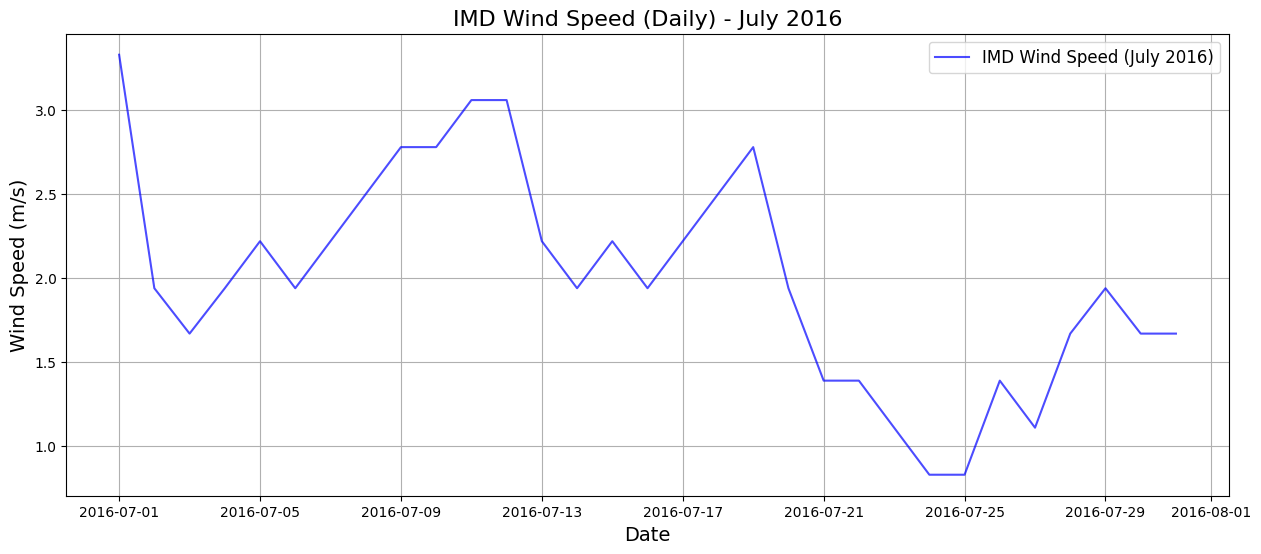

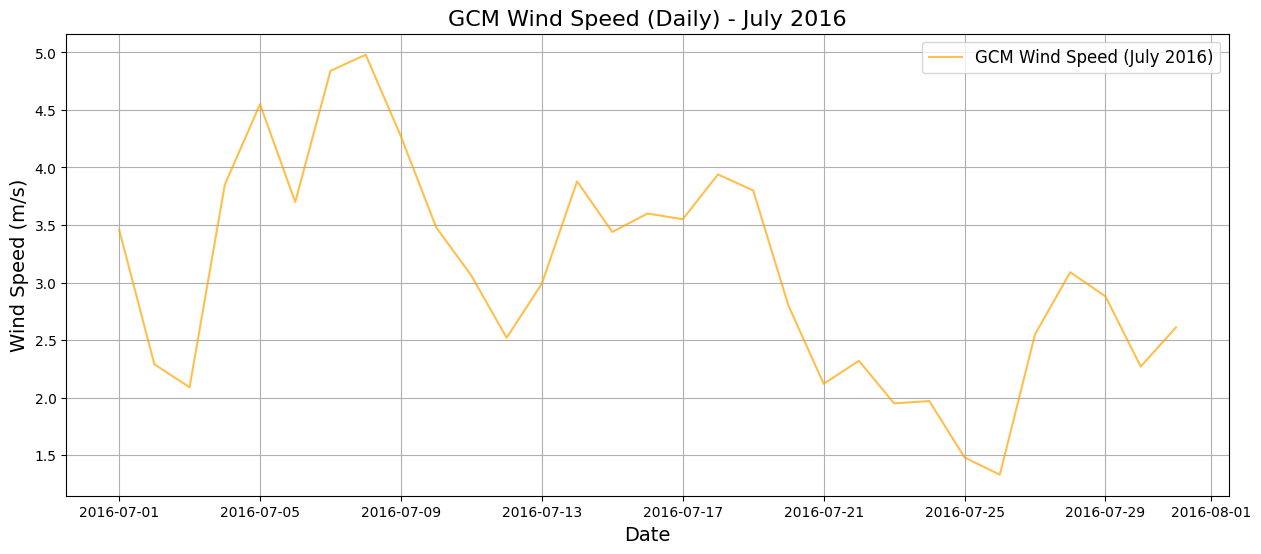

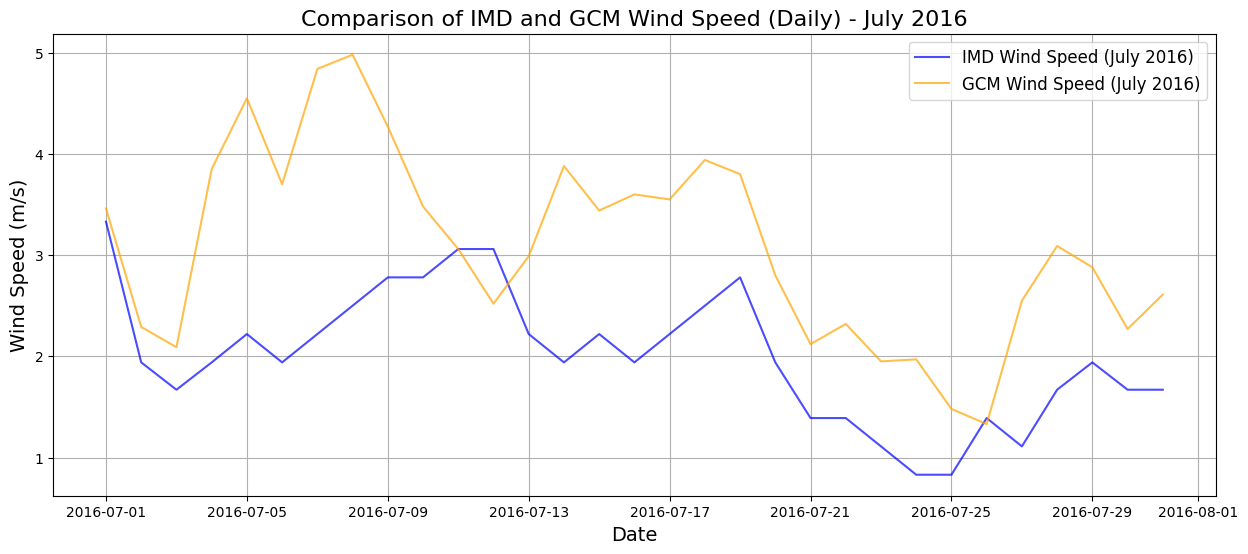

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Ensure a copy of July 2016 data to avoid modifying the original DataFrame
data_july_2016 = data.loc['2016-07'].copy()

# Handle missing values to avoid issues in metric calculations
data_july_2016 = data_july_2016.dropna(subset=['IMD_Wind_Speed', 'GCM_WIND_SPEED'])

# Compute statistical metrics for July 2016
bias_july_2016 = data_july_2016['GCM_WIND_SPEED'] - data_july_2016['IMD_Wind_Speed']
mse_july_2016 = mean_squared_error(data_july_2016['IMD_Wind_Speed'], data_july_2016['GCM_WIND_SPEED'])
rmse_july_2016 = np.sqrt(mse_july_2016)
mae_july_2016 = mean_absolute_error(data_july_2016['IMD_Wind_Speed'], data_july_2016['GCM_WIND_SPEED'])
r2_july_2016 = r2_score(data_july_2016['IMD_Wind_Speed'], data_july_2016['GCM_WIND_SPEED'])
correlation_july_2016 = data_july_2016['IMD_Wind_Speed'].corr(data_july_2016['GCM_WIND_SPEED'])

# Print statistical metrics for July 2016
print("\nStatistical Metrics for July 2016:")
print(f"Mean Squared Error (MSE): {mse_july_2016:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_july_2016:.2f}")
print(f"Mean Absolute Error (MAE): {mae_july_2016:.2f}")
print(f"R-squared (R²): {r2_july_2016:.2f}")
print(f"Correlation: {correlation_july_2016:.2f}")

# Plot IMD wind speed for July 2016
plt.figure(figsize=(15, 6))
plt.plot(data_july_2016.index, data_july_2016['IMD_Wind_Speed'], label='IMD Wind Speed (July 2016)', color='blue', alpha=0.7)
plt.title("IMD Wind Speed (Daily) - July 2016", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Plot GCM wind speed for July 2016
plt.figure(figsize=(15, 6))
plt.plot(data_july_2016.index, data_july_2016['GCM_WIND_SPEED'], label='GCM Wind Speed (July 2016)', color='orange', alpha=0.7)
plt.title("GCM Wind Speed (Daily) - July 2016", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Combined plot for comparison for July 2016
plt.figure(figsize=(15, 6))
plt.plot(data_july_2016.index, data_july_2016['IMD_Wind_Speed'], label='IMD Wind Speed (July 2016)', color='blue', alpha=0.7)
plt.plot(data_july_2016.index, data_july_2016['GCM_WIND_SPEED'], label='GCM Wind Speed (July 2016)', color='orange', alpha=0.7)
plt.title("Comparison of IMD and GCM Wind Speed (Daily) - July 2016", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()



Statistical Metrics for Smoothed Data in July 2016:
Mean Squared Error (MSE): 1.29
Root Mean Squared Error (RMSE): 1.14
Mean Absolute Error (MAE): 1.11
R-squared (R²): -4.85
Correlation: 0.99


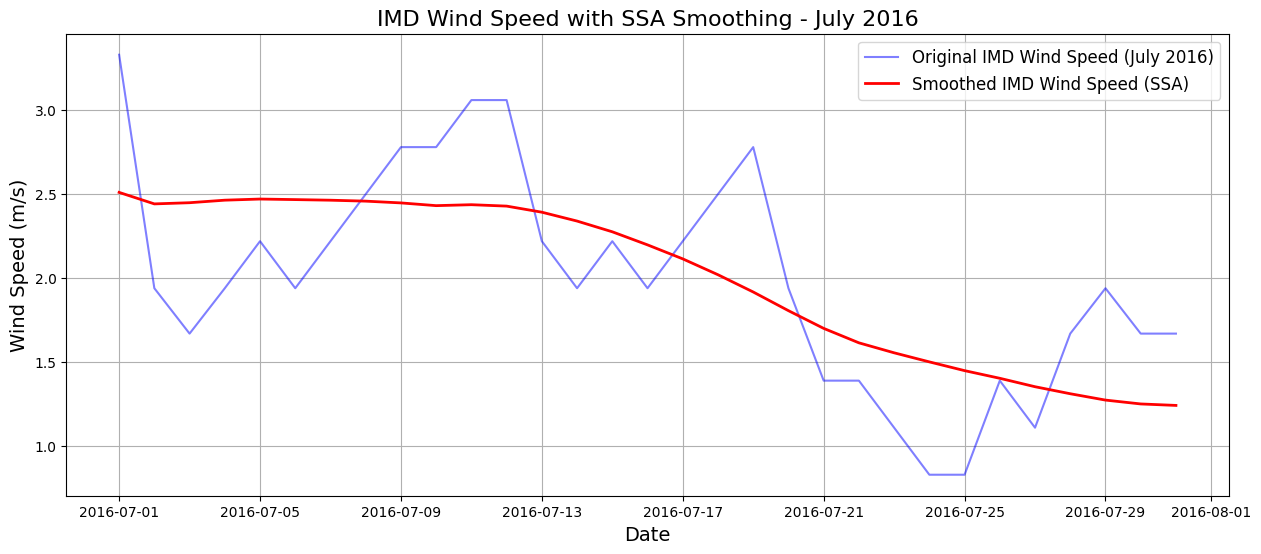

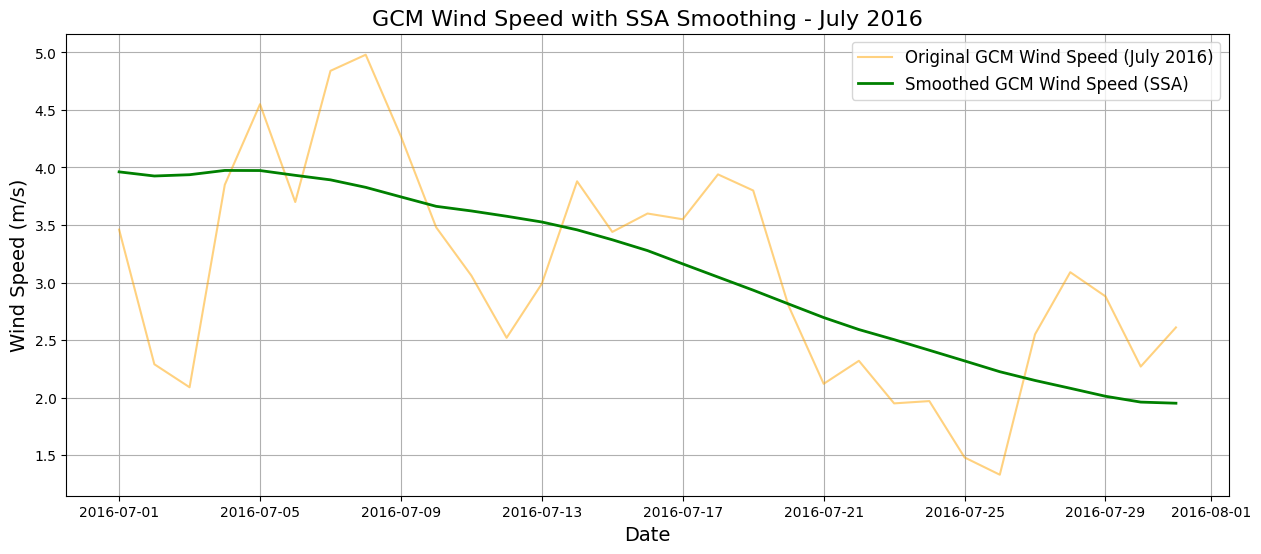

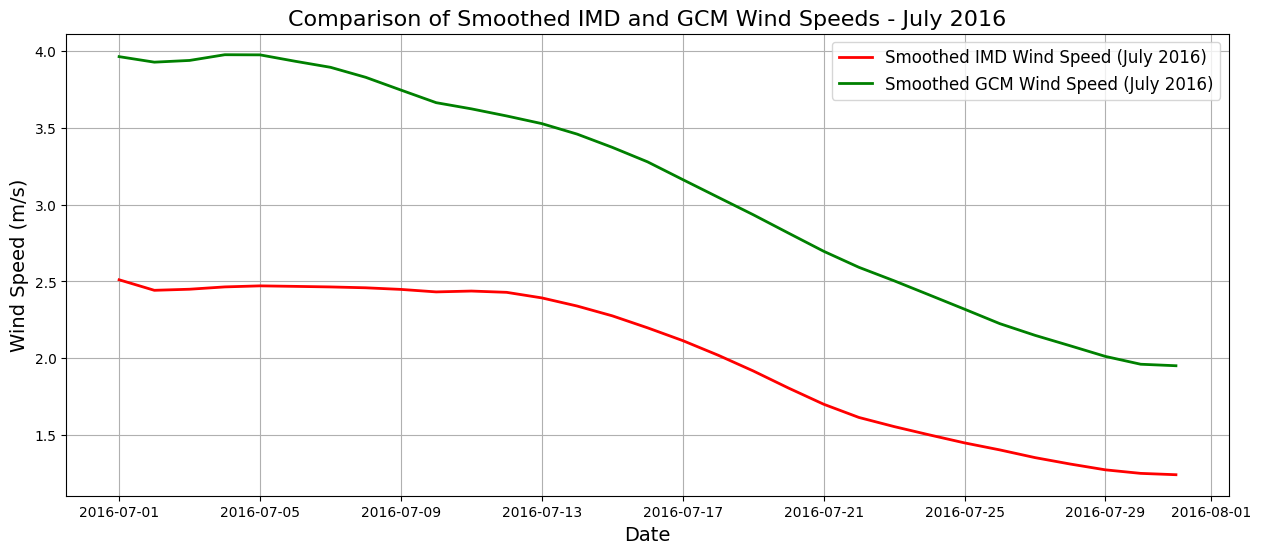

In [ ]:
import pandas as pd
from pyts.decomposition import SingularSpectrumAnalysis
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Ensure a copy of July 2016 data to avoid modifying the original DataFrame
data_july_2016 = data.loc['2016-07'].copy()

# Handle missing values to ensure SSA runs smoothly
data_july_2016 = data_july_2016.dropna(subset=['IMD_Wind_Speed', 'GCM_WIND_SPEED'])

# Apply SSA for IMD Wind Speed in July 2016
imd_series_july_2016 = data_july_2016['IMD_Wind_Speed'].values.reshape(1, -1)  # Reshape for SSA
ssa_imd_july_2016 = SingularSpectrumAnalysis(window_size=10)
imd_components_july_2016 = ssa_imd_july_2016.fit_transform(imd_series_july_2016)

# Reconstruct IMD wind speed (using the first component for trend)
imd_smoothed_july_2016 = imd_components_july_2016[:, 0].flatten()

# Apply SSA for GCM Wind Speed in July 2016
gcm_series_july_2016 = data_july_2016['GCM_WIND_SPEED'].values.reshape(1, -1)  # Reshape for SSA
ssa_gcm_july_2016 = SingularSpectrumAnalysis(window_size=10)
gcm_components_july_2016 = ssa_gcm_july_2016.fit_transform(gcm_series_july_2016)

# Reconstruct GCM wind speed (using the first component for trend)
gcm_smoothed_july_2016 = gcm_components_july_2016[:, 0].flatten()

# Add smoothed data to the July 2016 DataFrame
data_july_2016['IMD_Smoothed'] = imd_smoothed_july_2016
data_july_2016['GCM_Smoothed'] = gcm_smoothed_july_2016

# Compute statistical metrics for smoothed data in July 2016
bias_july_2016 = data_july_2016['GCM_Smoothed'] - data_july_2016['IMD_Smoothed']
mse_july_2016 = mean_squared_error(data_july_2016['IMD_Smoothed'], data_july_2016['GCM_Smoothed'])
rmse_july_2016 = np.sqrt(mse_july_2016)
mae_july_2016 = mean_absolute_error(data_july_2016['IMD_Smoothed'], data_july_2016['GCM_Smoothed'])
r2_july_2016 = r2_score(data_july_2016['IMD_Smoothed'], data_july_2016['GCM_Smoothed'])
correlation_july_2016 = data_july_2016['IMD_Smoothed'].corr(data_july_2016['GCM_Smoothed'])

# Print statistical metrics for smoothed data
print("\nStatistical Metrics for Smoothed Data in July 2016:")
print(f"Mean Squared Error (MSE): {mse_july_2016:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_july_2016:.2f}")
print(f"Mean Absolute Error (MAE): {mae_july_2016:.2f}")
print(f"R-squared (R²): {r2_july_2016:.2f}")
print(f"Correlation: {correlation_july_2016:.2f}")

# Plot smoothed IMD wind speed for July 2016
plt.figure(figsize=(15, 6))
plt.plot(data_july_2016.index, data_july_2016['IMD_Wind_Speed'], label='Original IMD Wind Speed (July 2016)', color='blue', alpha=0.5)
plt.plot(data_july_2016.index, data_july_2016['IMD_Smoothed'], label='Smoothed IMD Wind Speed (SSA)', color='red', linewidth=2)
plt.title("IMD Wind Speed with SSA Smoothing - July 2016", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Plot smoothed GCM wind speed for July 2016
plt.figure(figsize=(15, 6))
plt.plot(data_july_2016.index, data_july_2016['GCM_WIND_SPEED'], label='Original GCM Wind Speed (July 2016)', color='orange', alpha=0.5)
plt.plot(data_july_2016.index, data_july_2016['GCM_Smoothed'], label='Smoothed GCM Wind Speed (SSA)', color='green', linewidth=2)
plt.title("GCM Wind Speed with SSA Smoothing - July 2016", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Combined plot for comparison for July 2016
plt.figure(figsize=(15, 6))
plt.plot(data_july_2016.index, data_july_2016['IMD_Smoothed'], label='Smoothed IMD Wind Speed (July 2016)', color='red', linewidth=2)
plt.plot(data_july_2016.index, data_july_2016['GCM_Smoothed'], label='Smoothed GCM Wind Speed (July 2016)', color='green', linewidth=2)
plt.title("Comparison of Smoothed IMD and GCM Wind Speeds - July 2016", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()


explore Relationships Between GCM and IMD Data

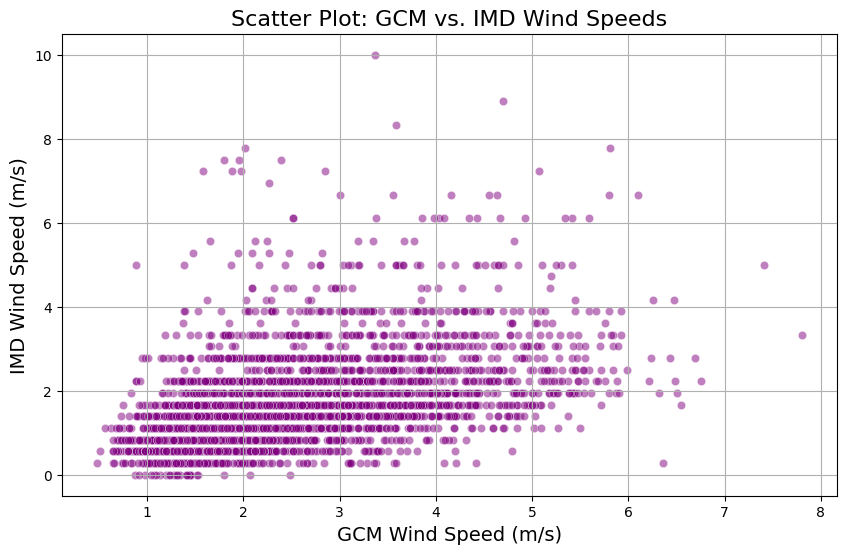

Correlation Coefficient: 0.53


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot of GCM vs. IMD wind speeds
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['GCM_WIND_SPEED'], y=data['IMD_Wind_Speed'], alpha=0.5, color='purple')
plt.title("Scatter Plot: GCM vs. IMD Wind Speeds", fontsize=16)
plt.xlabel("GCM Wind Speed (m/s)", fontsize=14)
plt.ylabel("IMD Wind Speed (m/s)", fontsize=14)
plt.grid()
plt.show()

# Compute correlation
correlation = data['GCM_WIND_SPEED'].corr(data['IMD_Wind_Speed'])
print(f"Correlation Coefficient: {correlation:.2f}")


In [ ]:
import pandas as pd

# Define the data for the table
data = {
    "Metric": [
        "Mean Squared Error (MSE)",
        "Root Mean Squared Error (RMSE)",
        "Mean Absolute Error (MAE)",
        "R-squared (R²)",
        "Correlation"
    ],
    "Before Smoothing": [1.74, 1.32, 1.05, -0.58, 0.53],
    "After Smoothing": [0.94, 0.97, 0.86, -1.18, 0.76],
    "2016": [1.26, 1.12, 0.95, -0.40, 0.76],
    "2016 Smoothed": [0.80, 0.89, 0.87, -0.91, 0.97],
    "July 2016": [1.70, 1.30, 1.12, -3.23, 0.62],
    "July 2016 Smoothed": [1.29, 1.14, 1.11, -4.85, 0.99]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Display the table
from google.colab.data_table import DataTable
DataTable(df)


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Before Smoothing'].plot(kind='hist', bins=20, title='Before Smoothing')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['After Smoothing'].plot(kind='hist', bins=20, title='After Smoothing')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['2016'].plot(kind='hist', bins=20, title='2016')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('Metric').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='index', y='Before Smoothing', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Before Smoothing', y='After Smoothing', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='After Smoothing', y='2016', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='2016', y='2016 Smoothed', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Before Smoothing']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Metric')):
  _plot_series(series, series_name, i)
  fig.legend(title='Metric', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Before Smoothing')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['After Smoothing']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Metric')):
  _plot_series(series, series_name, i)
  fig.legend(title='Metric', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('After Smoothing')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['2016']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Metric')):
  _plot_series(series, series_name, i)
  fig.legend(title='Metric', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('2016')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['2016 Smoothed']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Metric')):
  _plot_series(series, series_name, i)
  fig.legend(title='Metric', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('2016 Smoothed')

from matplotlib import pyplot as plt
_df_13['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['Before Smoothing'].plot(kind='line', figsize=(8, 4), title='Before Smoothing')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['After Smoothing'].plot(kind='line', figsize=(8, 4), title='After Smoothing')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_16['2016'].plot(kind='line', figsize=(8, 4), title='2016')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['Metric'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='index', y='Metric', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_18['Metric'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_18, x='Before Smoothing', y='Metric', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['Metric'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='After Smoothing', y='Metric', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['Metric'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='2016', y='Metric', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
# Display the table in a textual format
print(df.to_string(index=False))


                        Metric  Before Smoothing  After Smoothing  2016  2016 Smoothed  July 2016  July 2016 Smoothed
      Mean Squared Error (MSE)              1.74             0.94  1.26           0.80       1.70                1.29
Root Mean Squared Error (RMSE)              1.32             0.97  1.12           0.89       1.30                1.14
     Mean Absolute Error (MAE)              1.05             0.86  0.95           0.87       1.12                1.11
                R-squared (R²)             -0.58            -1.18 -0.40          -0.91      -3.23               -4.85
                   Correlation              0.53             0.76  0.76           0.97       0.62                0.99


# Step 4: Downscaling Models:

# 1. Linear Regression Downscaling


Statistical Metrics After Downscaling:
Mean Squared Error (MSE): 0.79
Root Mean Squared Error (RMSE): 0.89
Mean Absolute Error (MAE): 0.60
R-squared (R²): 0.29
Correlation: 0.53


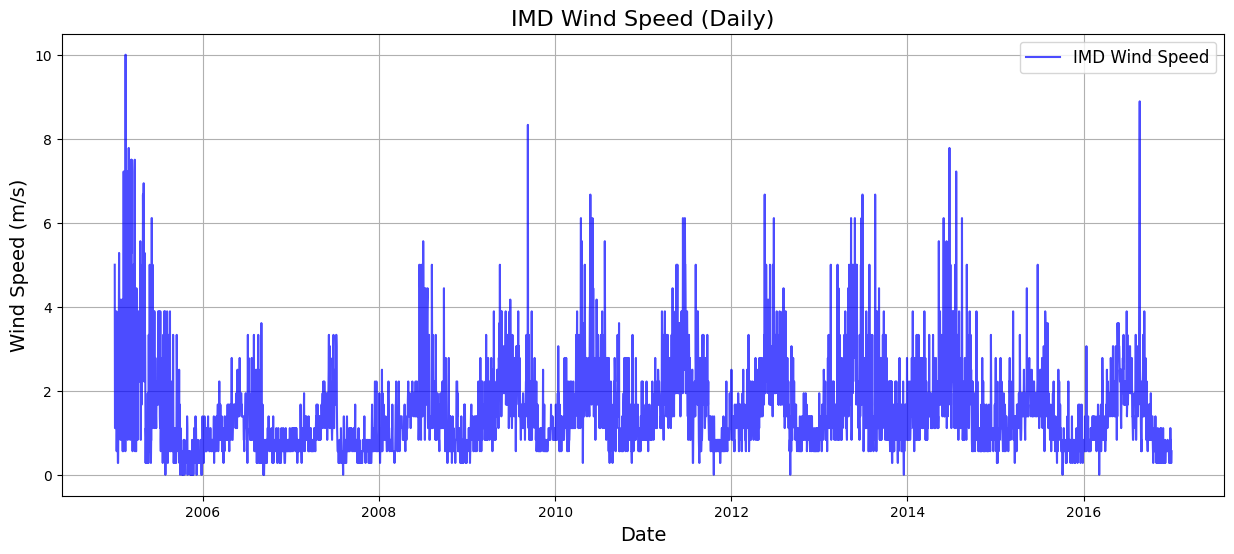

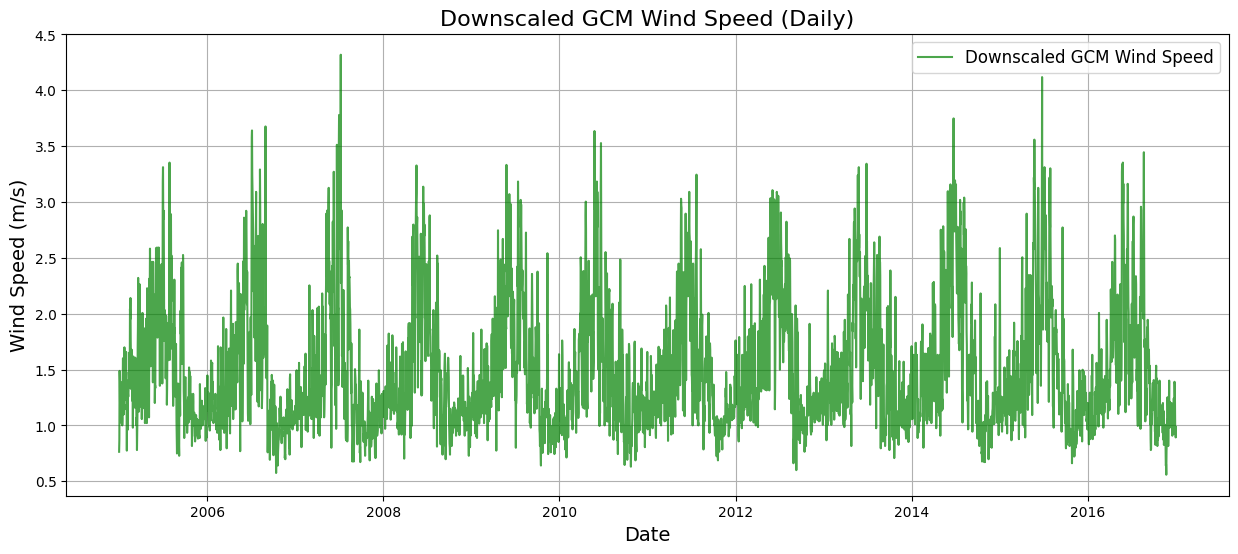

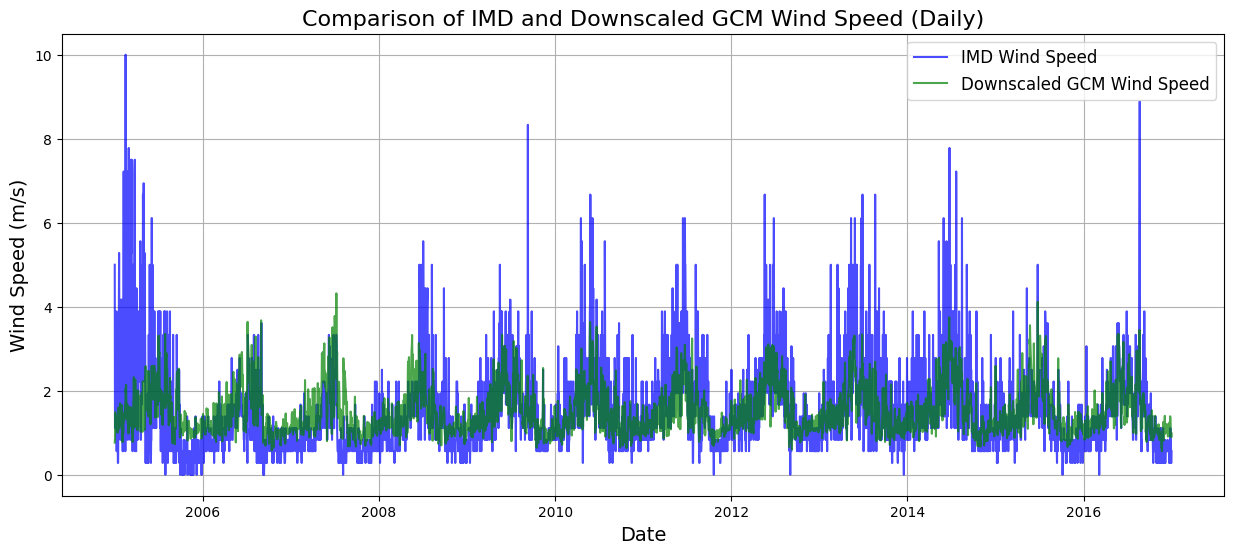

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Load dataset
file_path = "/content/drive/MyDrive/My Work/GCM_IMD_2005_2016_Wind_speed.csv"
data = pd.read_csv(file_path)

# Clean column names
data.columns = data.columns.str.strip()

# Convert date columns to a single datetime column
data['Date'] = pd.to_datetime(data[['YEAR', 'MONTH', 'DAY']], errors='coerce')
data.set_index('Date', inplace=True)

# Ensure no missing values in GCM_WIND_SPEED and IMD_Wind_Speed columns
if data[['GCM_WIND_SPEED', 'IMD_Wind_Speed']].isnull().any().any():
    print("Warning: Missing values detected. Dropping rows with missing values.")
    data = data.dropna(subset=['GCM_WIND_SPEED', 'IMD_Wind_Speed'])

# Prepare data for linear regression
dates = data.index.values.reshape(-1, 1)
x = data['GCM_WIND_SPEED'].values.reshape(-1, 1)
y = data['IMD_Wind_Speed'].values

# Train linear regression model
model = LinearRegression()
model.fit(x, y)

# Predict IMD wind speed using downscaled GCM wind speed
data['Downscaled_GCM_WIND_SPEED'] = model.predict(x)

# Compute statistical metrics for downscaled data
bias = data['Downscaled_GCM_WIND_SPEED'] - data['IMD_Wind_Speed']
mse = mean_squared_error(data['IMD_Wind_Speed'], data['Downscaled_GCM_WIND_SPEED'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(data['IMD_Wind_Speed'], data['Downscaled_GCM_WIND_SPEED'])
r2 = r2_score(data['IMD_Wind_Speed'], data['Downscaled_GCM_WIND_SPEED'])
correlation = data['IMD_Wind_Speed'].corr(data['Downscaled_GCM_WIND_SPEED'])

# Print statistical metrics
print("\nStatistical Metrics After Downscaling:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²): {r2:.2f}")
print(f"Correlation: {correlation:.2f}")

# Plot IMD wind speed
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['IMD_Wind_Speed'], label='IMD Wind Speed', color='blue', alpha=0.7)
plt.title("IMD Wind Speed (Daily)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Plot Downscaled GCM wind speed
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['Downscaled_GCM_WIND_SPEED'], label='Downscaled GCM Wind Speed', color='green', alpha=0.7)
plt.title("Downscaled GCM Wind Speed (Daily)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Combined plot for comparison
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['IMD_Wind_Speed'], label='IMD Wind Speed', color='blue', alpha=0.7)
plt.plot(data.index, data['Downscaled_GCM_WIND_SPEED'], label='Downscaled GCM Wind Speed', color='green', alpha=0.7)
plt.title("Comparison of IMD and Downscaled GCM Wind Speed (Daily)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()


# Linear Regression Downscaling on Smooth Data


Statistical Metrics After Downscaling:
Mean Squared Error (MSE): 0.18
Root Mean Squared Error (RMSE): 0.43
Mean Absolute Error (MAE): 0.31
R-squared (R²): 0.57
Correlation: 0.76


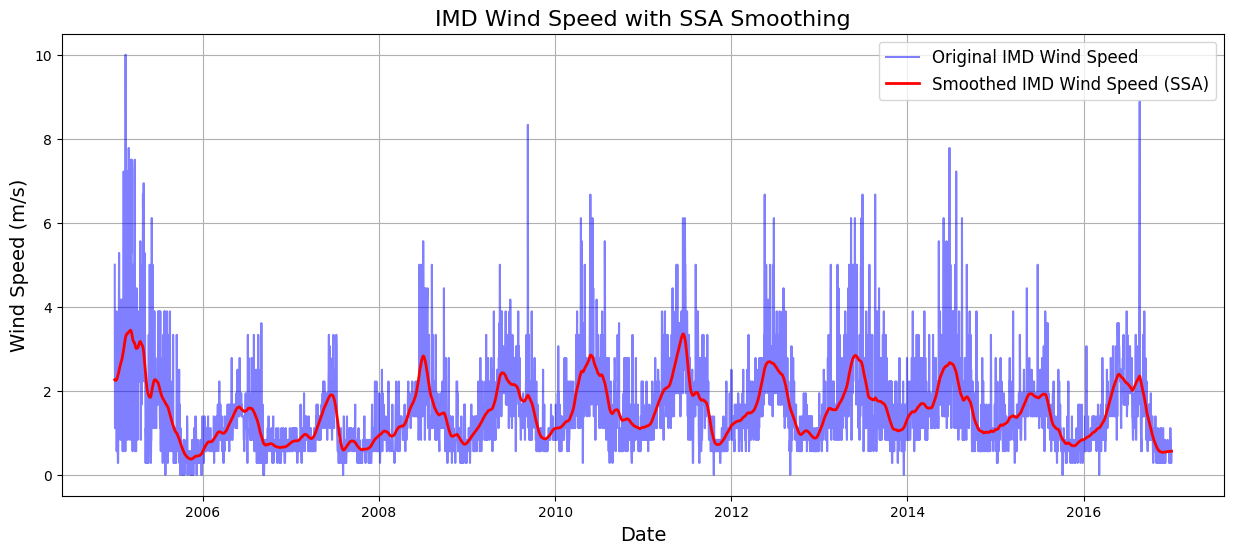

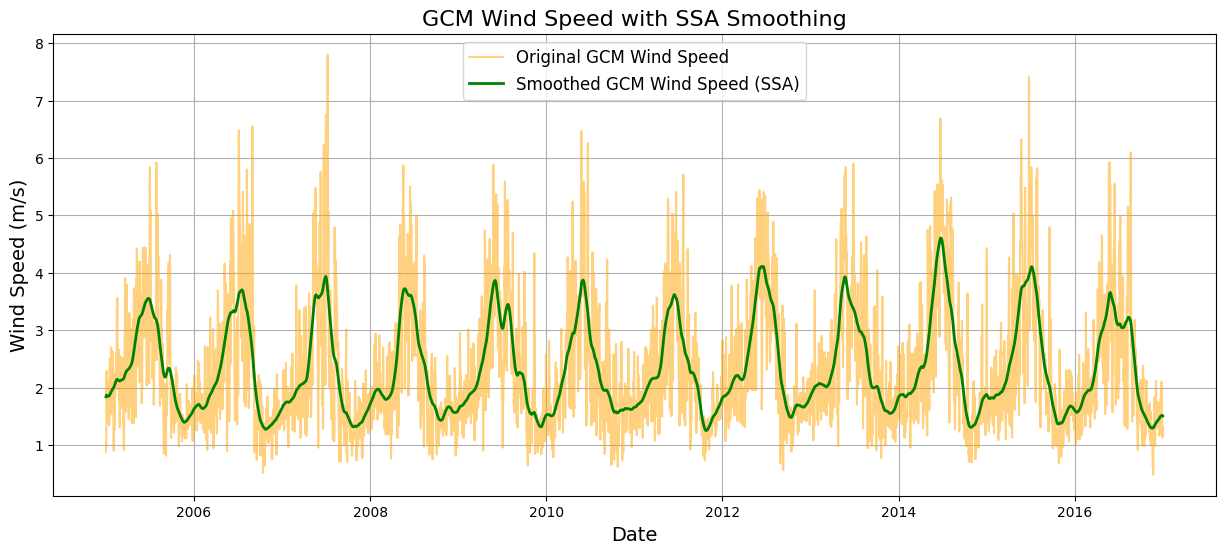

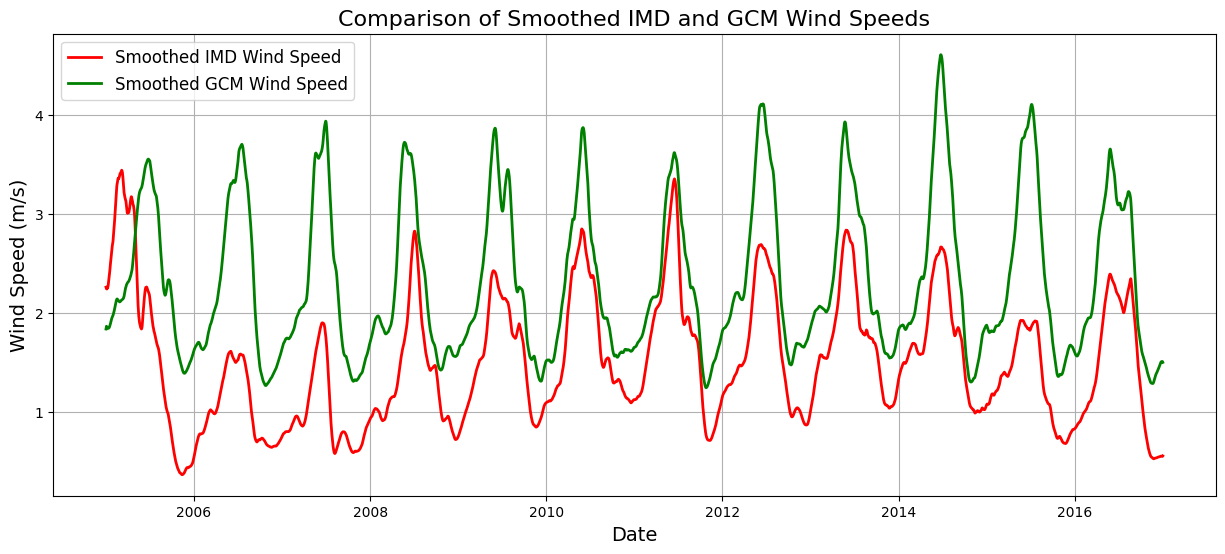

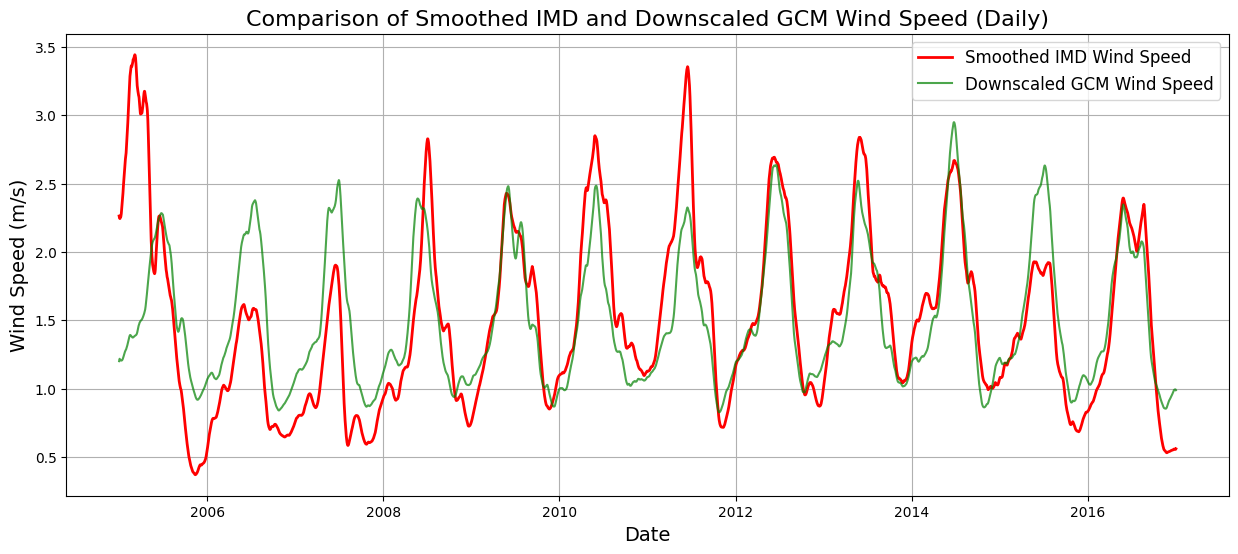

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from pyts.decomposition import SingularSpectrumAnalysis

# Load dataset
file_path = "/content/drive/MyDrive/My Work/GCM_IMD_2005_2016_Wind_speed.csv"
data = pd.read_csv(file_path)

# Clean column names
data.columns = data.columns.str.strip()

# Convert date columns to a single datetime column
data['Date'] = pd.to_datetime(data[['YEAR', 'MONTH', 'DAY']], errors='coerce')
data.set_index('Date', inplace=True)

# Ensure no missing values in GCM_WIND_SPEED and IMD_Wind_Speed columns
if data[['GCM_WIND_SPEED', 'IMD_Wind_Speed']].isnull().any().any():
    print("Warning: Missing values detected. Dropping rows with missing values.")
    data = data.dropna(subset=['GCM_WIND_SPEED', 'IMD_Wind_Speed'])

# Apply SSA for IMD Wind Speed
imd_series = data['IMD_Wind_Speed'].values.reshape(1, -1)  # Reshape for SSA
ssa_imd = SingularSpectrumAnalysis(window_size=30)
imd_components = ssa_imd.fit_transform(imd_series)

# Reconstruct IMD wind speed (using the first component for trend)
imd_smoothed = imd_components[:, 0].flatten()  # Take the first component (trend)

# Apply SSA for GCM Wind Speed
gcm_series = data['GCM_WIND_SPEED'].values.reshape(1, -1)  # Reshape for SSA
ssa_gcm = SingularSpectrumAnalysis(window_size=30)
gcm_components = ssa_gcm.fit_transform(gcm_series)

# Reconstruct GCM wind speed (using the first component for trend)
gcm_smoothed = gcm_components[:, 0].flatten()  # Take the first component (trend)

# Add smoothed data to the original DataFrame
data['IMD_Smoothed'] = imd_smoothed
data['GCM_Smoothed'] = gcm_smoothed

# Prepare data for linear regression
x_smoothed = data['GCM_Smoothed'].values.reshape(-1, 1)
y_smoothed = data['IMD_Smoothed'].values

# Train linear regression model
model = LinearRegression()
model.fit(x_smoothed, y_smoothed)

# Predict IMD wind speed using downscaled GCM wind speed
data['Downscaled_GCM_WIND_SPEED'] = model.predict(x_smoothed)

# Compute statistical metrics for downscaled data
bias = data['Downscaled_GCM_WIND_SPEED'] - data['IMD_Smoothed']
mse = mean_squared_error(data['IMD_Smoothed'], data['Downscaled_GCM_WIND_SPEED'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(data['IMD_Smoothed'], data['Downscaled_GCM_WIND_SPEED'])
r2 = r2_score(data['IMD_Smoothed'], data['Downscaled_GCM_WIND_SPEED'])
correlation = data['IMD_Smoothed'].corr(data['Downscaled_GCM_WIND_SPEED'])

# Print statistical metrics
print("\nStatistical Metrics After Downscaling:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²): {r2:.2f}")
print(f"Correlation: {correlation:.2f}")

# Plot IMD wind speed
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['IMD_Wind_Speed'], label='Original IMD Wind Speed', color='blue', alpha=0.5)
plt.plot(data.index, data['IMD_Smoothed'], label='Smoothed IMD Wind Speed (SSA)', color='red', linewidth=2)
plt.title("IMD Wind Speed with SSA Smoothing", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Plot smoothed GCM wind speed
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['GCM_WIND_SPEED'], label='Original GCM Wind Speed', color='orange', alpha=0.5)
plt.plot(data.index, data['GCM_Smoothed'], label='Smoothed GCM Wind Speed (SSA)', color='green', linewidth=2)
plt.title("GCM Wind Speed with SSA Smoothing", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Combined plot for comparison
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['IMD_Smoothed'], label='Smoothed IMD Wind Speed', color='red', linewidth=2)
plt.plot(data.index, data['GCM_Smoothed'], label='Smoothed GCM Wind Speed', color='green', linewidth=2)
plt.title("Comparison of Smoothed IMD and GCM Wind Speeds", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Plot Downscaled GCM wind speed
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['IMD_Smoothed'], label='Smoothed IMD Wind Speed', color='red', linewidth=2)
plt.plot(data.index, data['Downscaled_GCM_WIND_SPEED'], label='Downscaled GCM Wind Speed', color='green', alpha=0.7)
plt.title("Comparison of Smoothed IMD and Downscaled GCM Wind Speed (Daily)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()


# 2. Random Forest Downscaling


Statistical Metrics After Downscaling:
Mean Squared Error (MSE): 0.67
Root Mean Squared Error (RMSE): 0.82
Mean Absolute Error (MAE): 0.56
R-squared (R²): 0.40
Correlation: 0.63


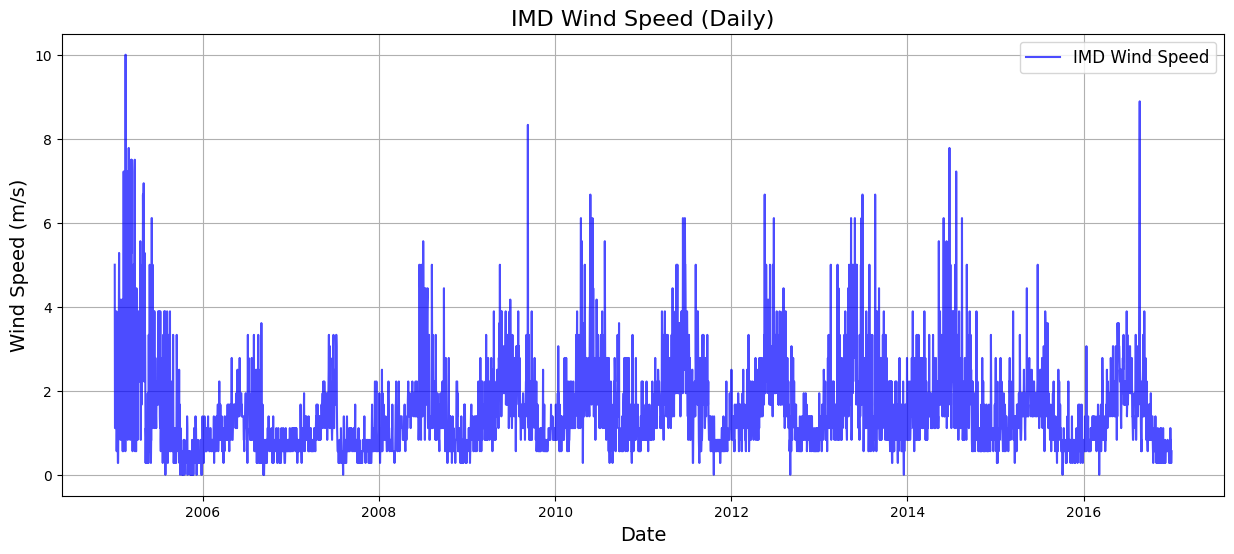

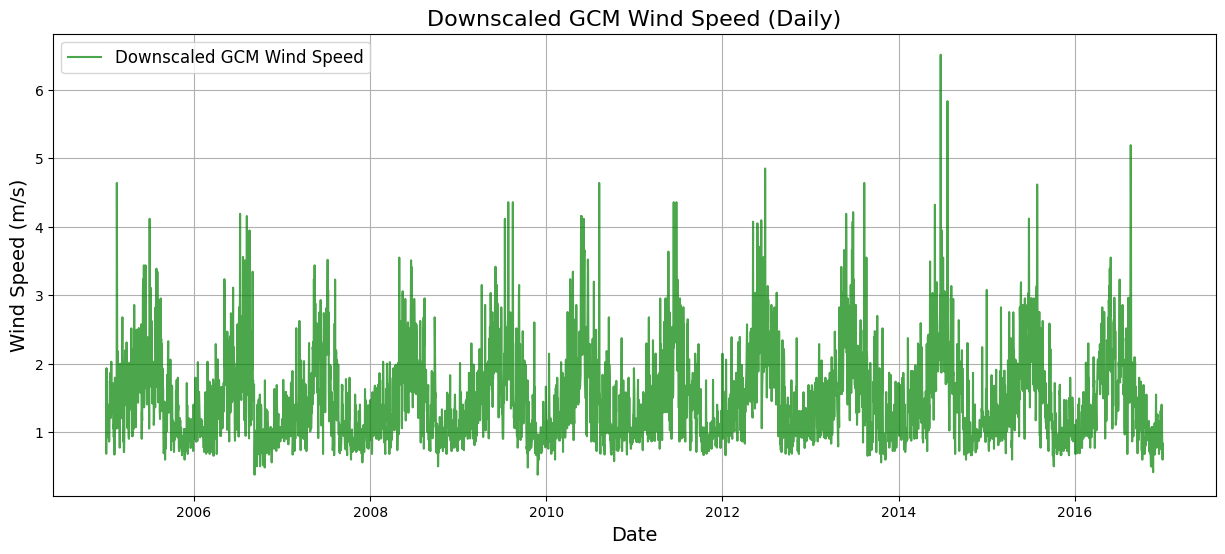

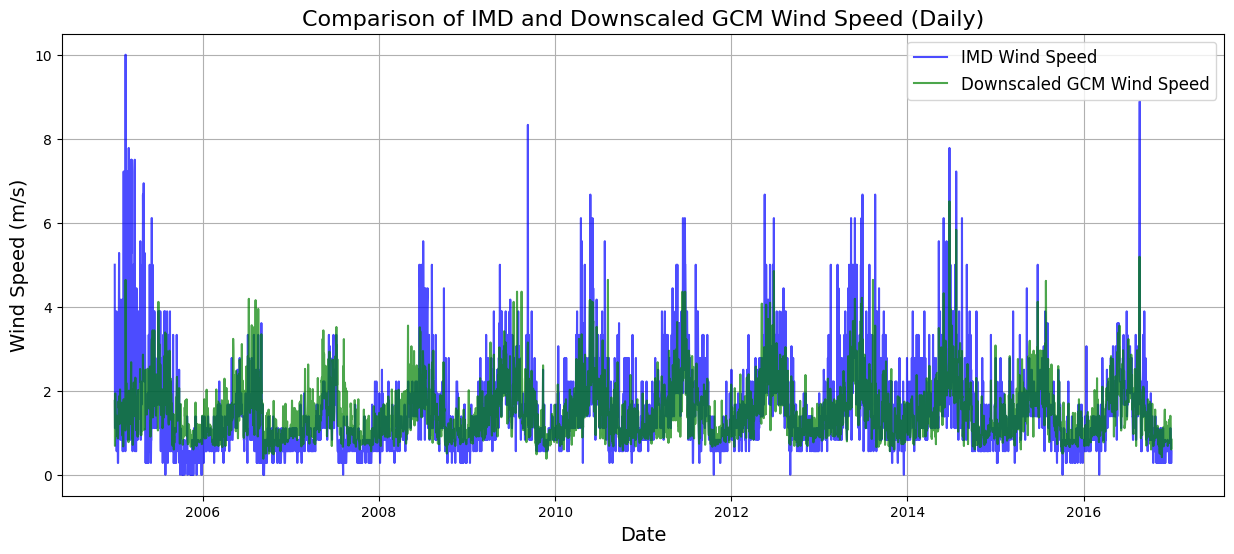

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Load dataset
file_path = "/content/drive/MyDrive/My Work/GCM_IMD_2005_2016_Wind_speed.csv"
data = pd.read_csv(file_path)

# Clean column names
data.columns = data.columns.str.strip()

# Convert date columns to a single datetime column
data['Date'] = pd.to_datetime(data[['YEAR', 'MONTH', 'DAY']], errors='coerce')
data.set_index('Date', inplace=True)

# Ensure no missing values in GCM_WIND_SPEED and IMD_Wind_Speed columns
if data[['GCM_WIND_SPEED', 'IMD_Wind_Speed']].isnull().any().any():
    print("Warning: Missing values detected. Dropping rows with missing values.")
    data = data.dropna(subset=['GCM_WIND_SPEED', 'IMD_Wind_Speed'])

# Prepare data for Random Forest regression
dates = data.index.values.reshape(-1, 1)
x = data['GCM_WIND_SPEED'].values.reshape(-1, 1)
y = data['IMD_Wind_Speed'].values

# Train Random Forest regression model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(x, y)

# Predict IMD wind speed using downscaled GCM wind speed
data['Downscaled_GCM_WIND_SPEED'] = model.predict(x)

# Compute statistical metrics for downscaled data
bias = data['Downscaled_GCM_WIND_SPEED'] - data['IMD_Wind_Speed']
mse = mean_squared_error(data['IMD_Wind_Speed'], data['Downscaled_GCM_WIND_SPEED'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(data['IMD_Wind_Speed'], data['Downscaled_GCM_WIND_SPEED'])
r2 = r2_score(data['IMD_Wind_Speed'], data['Downscaled_GCM_WIND_SPEED'])
correlation = data['IMD_Wind_Speed'].corr(data['Downscaled_GCM_WIND_SPEED'])

# Print statistical metrics
print("\nStatistical Metrics After Downscaling:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²): {r2:.2f}")
print(f"Correlation: {correlation:.2f}")

# Plot IMD wind speed
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['IMD_Wind_Speed'], label='IMD Wind Speed', color='blue', alpha=0.7)
plt.title("IMD Wind Speed (Daily)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Plot Downscaled GCM wind speed
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['Downscaled_GCM_WIND_SPEED'], label='Downscaled GCM Wind Speed', color='green', alpha=0.7)
plt.title("Downscaled GCM Wind Speed (Daily)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Combined plot for comparison
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['IMD_Wind_Speed'], label='IMD Wind Speed', color='blue', alpha=0.7)
plt.plot(data.index, data['Downscaled_GCM_WIND_SPEED'], label='Downscaled GCM Wind Speed', color='green', alpha=0.7)
plt.title("Comparison of IMD and Downscaled GCM Wind Speed (Daily)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()


# Random Forest Downscaling on Smooth data


Statistical Metrics After Downscaling:
Mean Squared Error (MSE): 0.03
Root Mean Squared Error (RMSE): 0.18
Mean Absolute Error (MAE): 0.13
R-squared (R²): 0.92
Correlation: 0.96


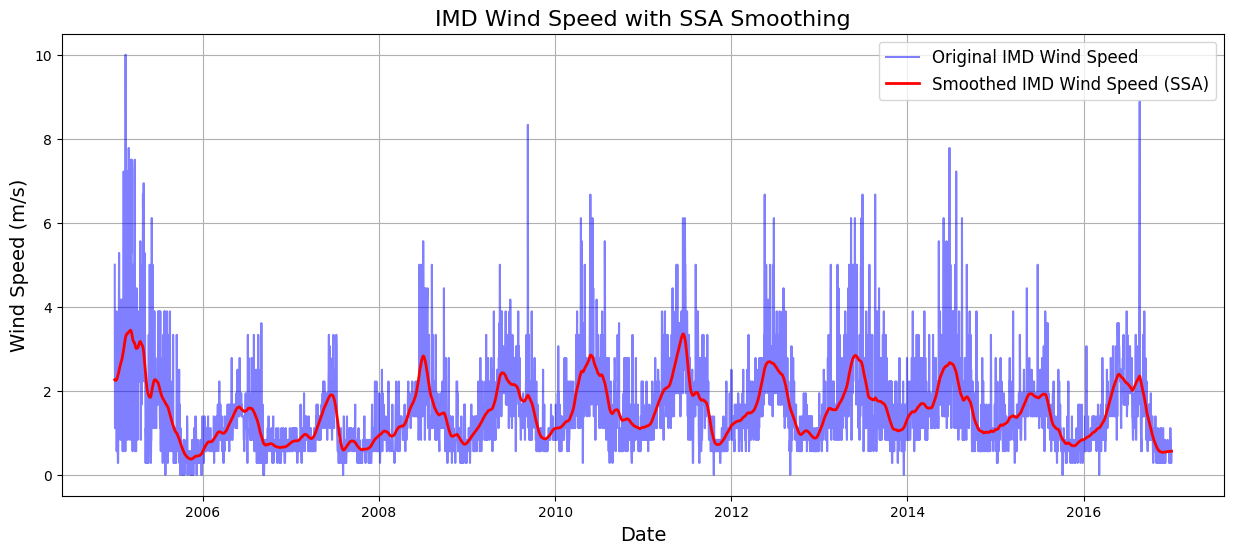

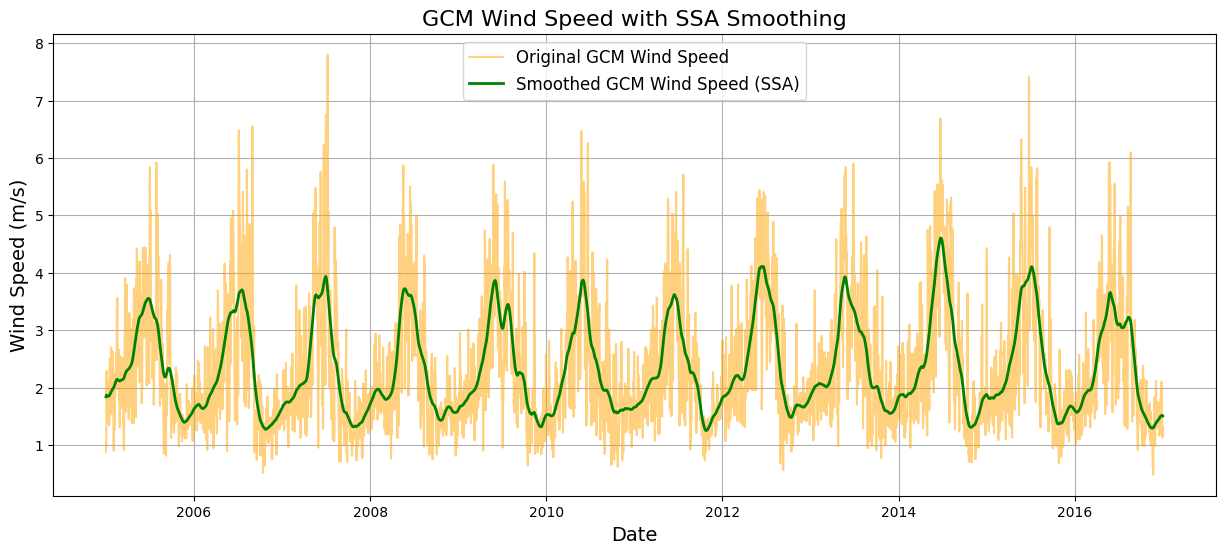

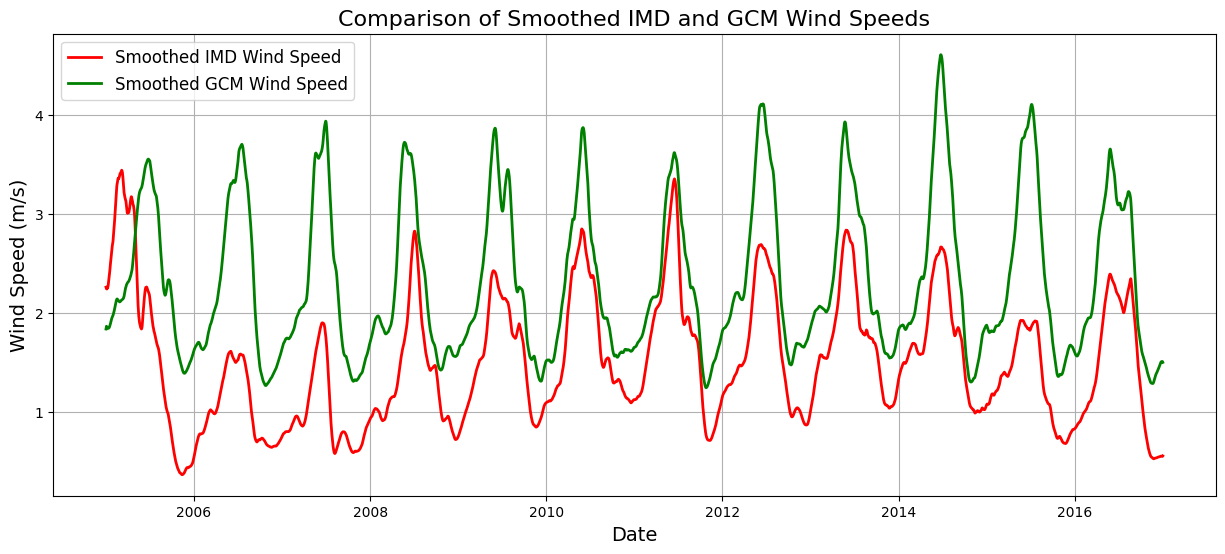

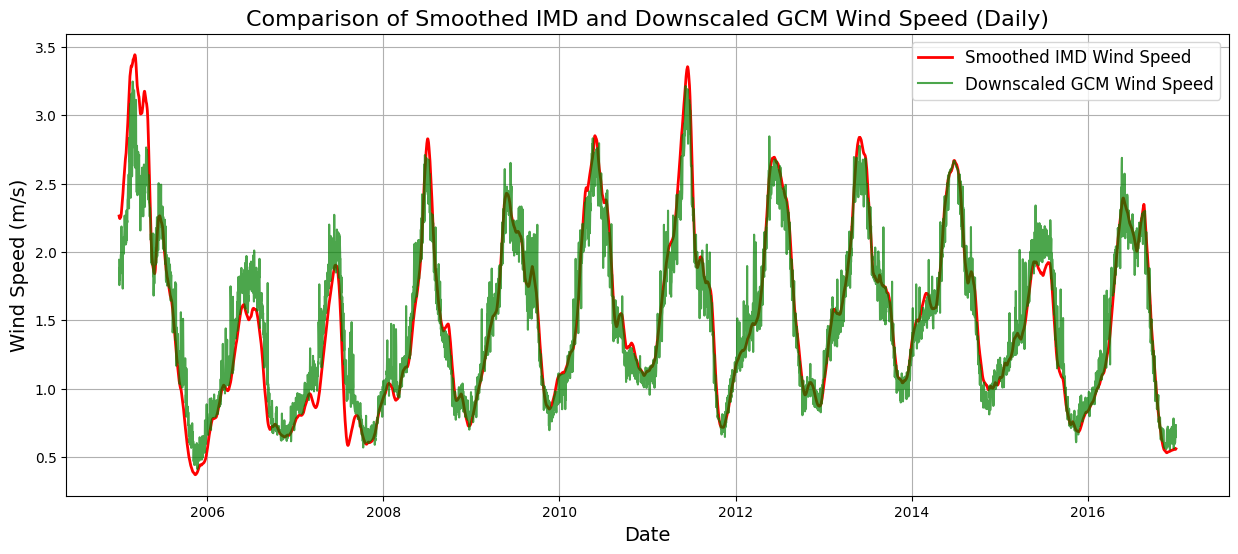

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from pyts.decomposition import SingularSpectrumAnalysis

# Load dataset
file_path = "/content/drive/MyDrive/My Work/GCM_IMD_2005_2016_Wind_speed.csv"
data = pd.read_csv(file_path)

# Clean column names
data.columns = data.columns.str.strip()

# Convert date columns to a single datetime column
data['Date'] = pd.to_datetime(data[['YEAR', 'MONTH', 'DAY']], errors='coerce')
data.set_index('Date', inplace=True)

# Ensure no missing values in GCM_WIND_SPEED and IMD_Wind_Speed columns
if data[['GCM_WIND_SPEED', 'IMD_Wind_Speed']].isnull().any().any():
    print("Warning: Missing values detected. Dropping rows with missing values.")
    data = data.dropna(subset=['GCM_WIND_SPEED', 'IMD_Wind_Speed'])

# Apply SSA for IMD Wind Speed
imd_series = data['IMD_Wind_Speed'].values.reshape(1, -1)  # Reshape for SSA
ssa_imd = SingularSpectrumAnalysis(window_size=30)
imd_components = ssa_imd.fit_transform(imd_series)

# Reconstruct IMD wind speed (using the first component for trend)
imd_smoothed = imd_components[:, 0].flatten()  # Take the first component (trend)

# Apply SSA for GCM Wind Speed
gcm_series = data['GCM_WIND_SPEED'].values.reshape(1, -1)  # Reshape for SSA
ssa_gcm = SingularSpectrumAnalysis(window_size=30)
gcm_components = ssa_gcm.fit_transform(gcm_series)

# Reconstruct GCM wind speed (using the first component for trend)
gcm_smoothed = gcm_components[:, 0].flatten()  # Take the first component (trend)

# Add smoothed data to the original DataFrame
data['IMD_Smoothed'] = imd_smoothed
data['GCM_Smoothed'] = gcm_smoothed

# Prepare data for Random Forest regression
x_smoothed = data['GCM_Smoothed'].values.reshape(-1, 1)
y_smoothed = data['IMD_Smoothed'].values

# Train Random Forest regression model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(x_smoothed, y_smoothed)

# Predict IMD wind speed using downscaled GCM wind speed
data['Downscaled_GCM_WIND_SPEED'] = model.predict(x_smoothed)

# Compute statistical metrics for downscaled data
bias = data['Downscaled_GCM_WIND_SPEED'] - data['IMD_Smoothed']
mse = mean_squared_error(data['IMD_Smoothed'], data['Downscaled_GCM_WIND_SPEED'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(data['IMD_Smoothed'], data['Downscaled_GCM_WIND_SPEED'])
r2 = r2_score(data['IMD_Smoothed'], data['Downscaled_GCM_WIND_SPEED'])
correlation = data['IMD_Smoothed'].corr(data['Downscaled_GCM_WIND_SPEED'])

# Print statistical metrics
print("\nStatistical Metrics After Downscaling:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²): {r2:.2f}")
print(f"Correlation: {correlation:.2f}")

# Plot IMD wind speed
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['IMD_Wind_Speed'], label='Original IMD Wind Speed', color='blue', alpha=0.5)
plt.plot(data.index, data['IMD_Smoothed'], label='Smoothed IMD Wind Speed (SSA)', color='red', linewidth=2)
plt.title("IMD Wind Speed with SSA Smoothing", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Plot smoothed GCM wind speed
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['GCM_WIND_SPEED'], label='Original GCM Wind Speed', color='orange', alpha=0.5)
plt.plot(data.index, data['GCM_Smoothed'], label='Smoothed GCM Wind Speed (SSA)', color='green', linewidth=2)
plt.title("GCM Wind Speed with SSA Smoothing", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Combined plot for comparison
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['IMD_Smoothed'], label='Smoothed IMD Wind Speed', color='red', linewidth=2)
plt.plot(data.index, data['GCM_Smoothed'], label='Smoothed GCM Wind Speed', color='green', linewidth=2)
plt.title("Comparison of Smoothed IMD and GCM Wind Speeds", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Plot Downscaled GCM wind speed
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['IMD_Smoothed'], label='Smoothed IMD Wind Speed', color='red', linewidth=2)
plt.plot(data.index, data['Downscaled_GCM_WIND_SPEED'], label='Downscaled GCM Wind Speed', color='green', alpha=0.7)
plt.title("Comparison of Smoothed IMD and Downscaled GCM Wind Speed (Daily)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()


# 3. Gradient Boosting regression model


Statistical Metrics After Downscaling:
Mean Squared Error (MSE): 0.71
Root Mean Squared Error (RMSE): 0.84
Mean Absolute Error (MAE): 0.57
R-squared (R²): 0.36
Correlation: 0.60


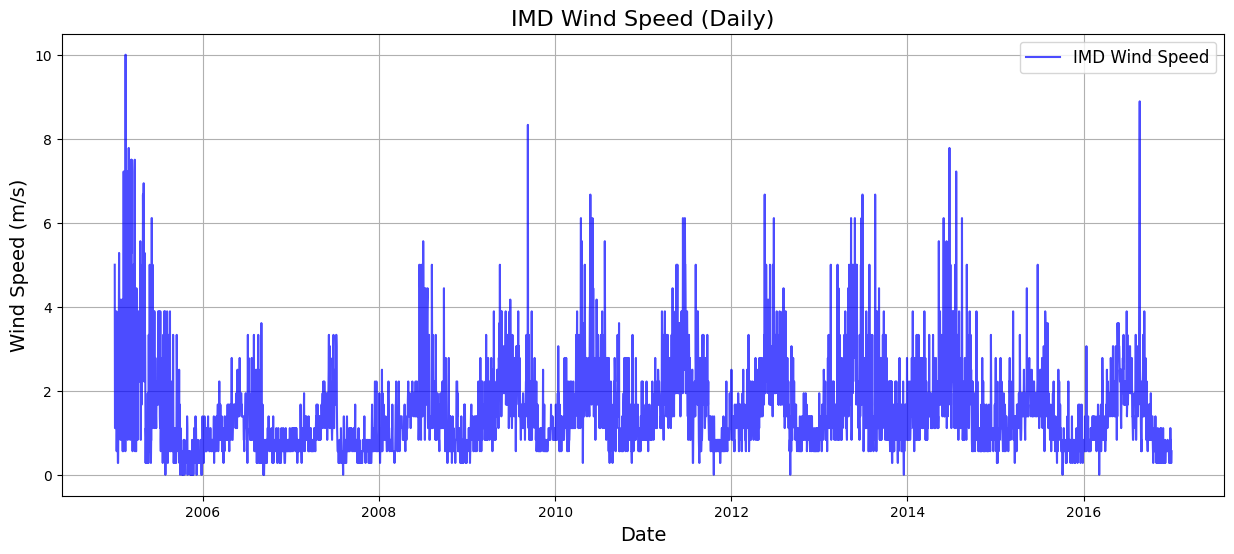

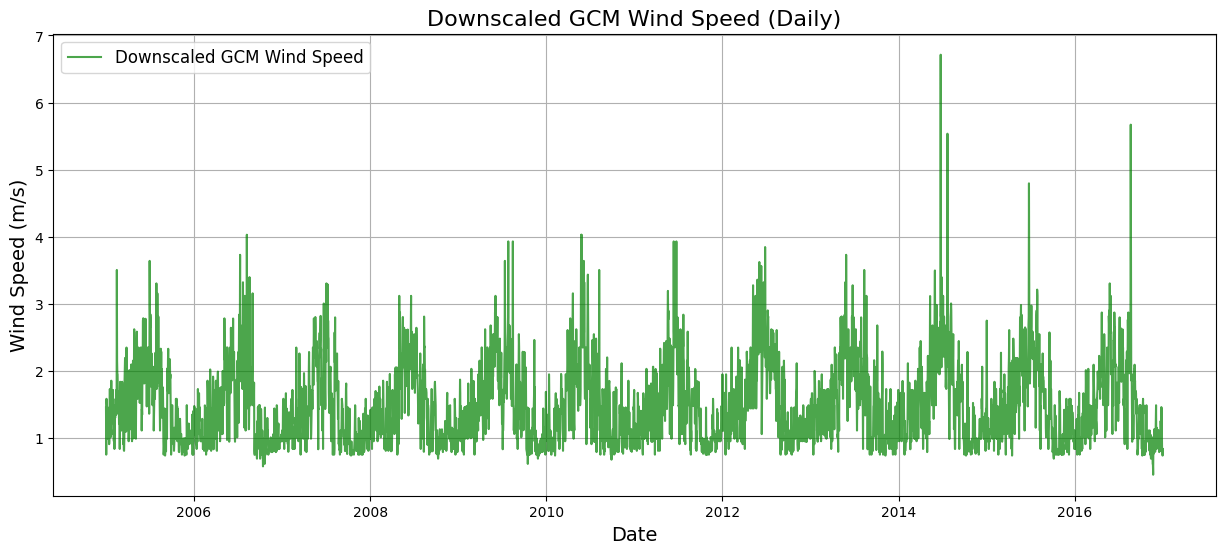

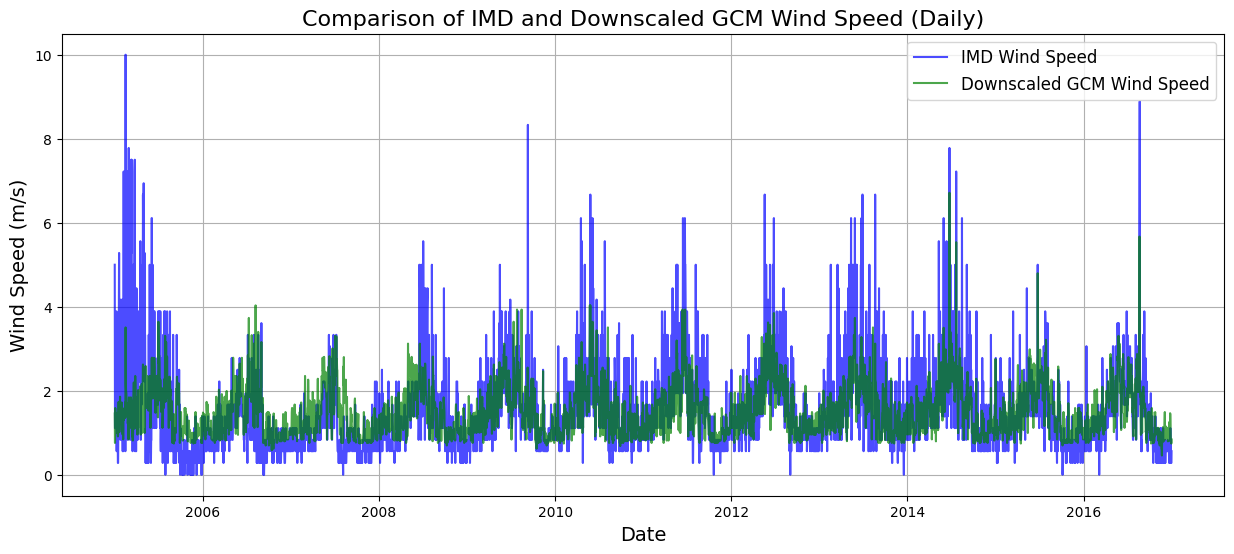

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Load dataset
file_path = "/content/drive/MyDrive/My Work/GCM_IMD_2005_2016_Wind_speed.csv"
data = pd.read_csv(file_path)

# Clean column names
data.columns = data.columns.str.strip()

# Convert date columns to a single datetime column
data['Date'] = pd.to_datetime(data[['YEAR', 'MONTH', 'DAY']], errors='coerce')
data.set_index('Date', inplace=True)

# Ensure no missing values in GCM_WIND_SPEED and IMD_Wind_Speed columns
if data[['GCM_WIND_SPEED', 'IMD_Wind_Speed']].isnull().any().any():
    print("Warning: Missing values detected. Dropping rows with missing values.")
    data = data.dropna(subset=['GCM_WIND_SPEED', 'IMD_Wind_Speed'])

# Prepare data for Gradient Boosting regression
dates = data.index.values.reshape(-1, 1)
x = data['GCM_WIND_SPEED'].values.reshape(-1, 1)
y = data['IMD_Wind_Speed'].values

# Standardize the features
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Train Gradient Boosting regression model
model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(x_scaled, y)

# Predict IMD wind speed using downscaled GCM wind speed
data['Downscaled_GCM_WIND_SPEED'] = model.predict(x_scaled)

# Compute statistical metrics for downscaled data
bias = data['Downscaled_GCM_WIND_SPEED'] - data['IMD_Wind_Speed']
mse = mean_squared_error(data['IMD_Wind_Speed'], data['Downscaled_GCM_WIND_SPEED'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(data['IMD_Wind_Speed'], data['Downscaled_GCM_WIND_SPEED'])
r2 = r2_score(data['IMD_Wind_Speed'], data['Downscaled_GCM_WIND_SPEED'])
correlation = data['IMD_Wind_Speed'].corr(data['Downscaled_GCM_WIND_SPEED'])

# Print statistical metrics
print("\nStatistical Metrics After Downscaling:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²): {r2:.2f}")
print(f"Correlation: {correlation:.2f}")

# Plot IMD wind speed
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['IMD_Wind_Speed'], label='IMD Wind Speed', color='blue', alpha=0.7)
plt.title("IMD Wind Speed (Daily)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Plot Downscaled GCM wind speed
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['Downscaled_GCM_WIND_SPEED'], label='Downscaled GCM Wind Speed', color='green', alpha=0.7)
plt.title("Downscaled GCM Wind Speed (Daily)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Combined plot for comparison
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['IMD_Wind_Speed'], label='IMD Wind Speed', color='blue', alpha=0.7)
plt.plot(data.index, data['Downscaled_GCM_WIND_SPEED'], label='Downscaled GCM Wind Speed', color='green', alpha=0.7)
plt.title("Comparison of IMD and Downscaled GCM Wind Speed (Daily)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()


# Gradient Boosting regression model on Smooth Data


Statistical Metrics After Downscaling:
Mean Squared Error (MSE): 0.14
Root Mean Squared Error (RMSE): 0.37
Mean Absolute Error (MAE): 0.27
R-squared (R²): 0.68
Correlation: 0.82


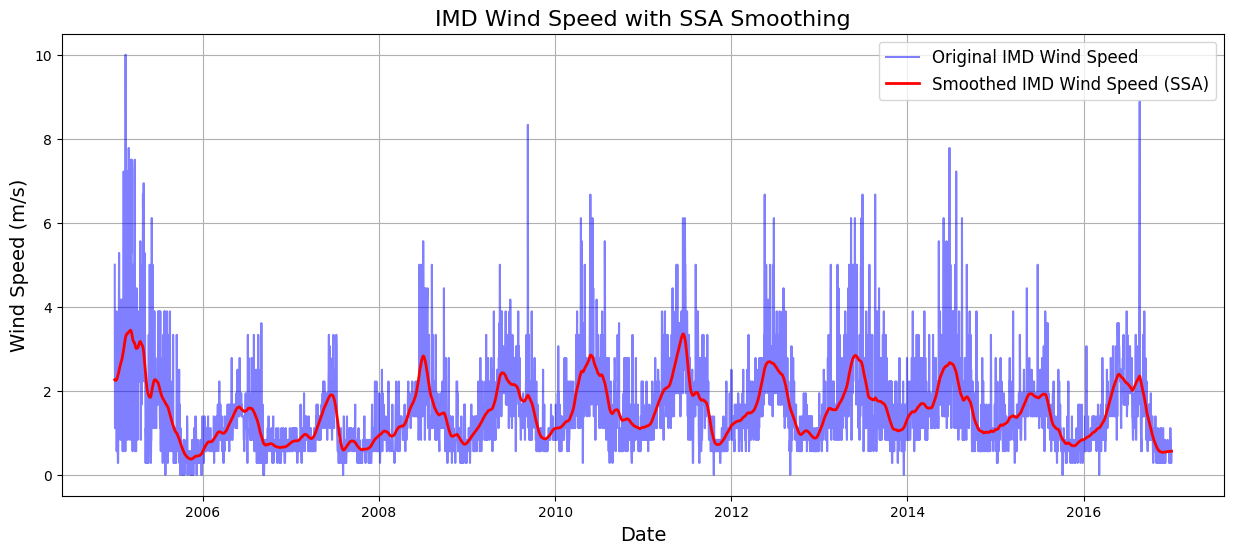

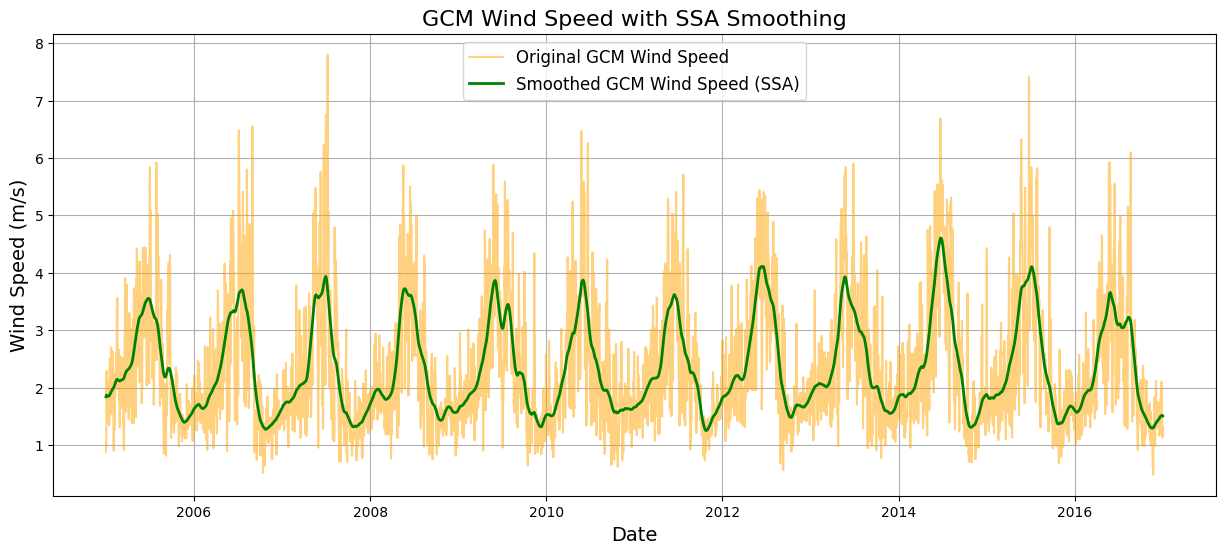

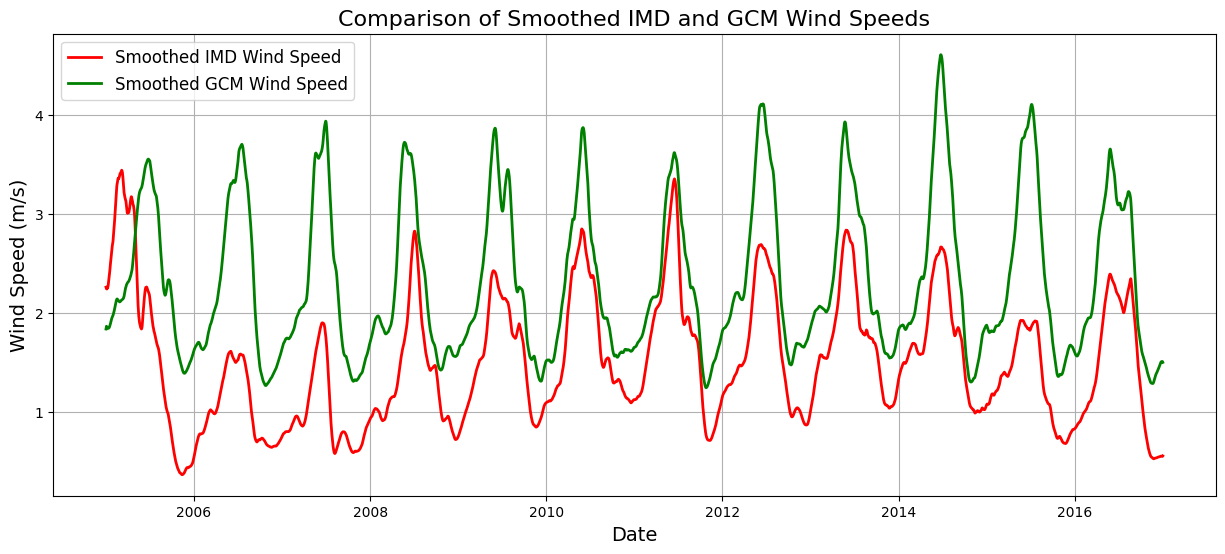

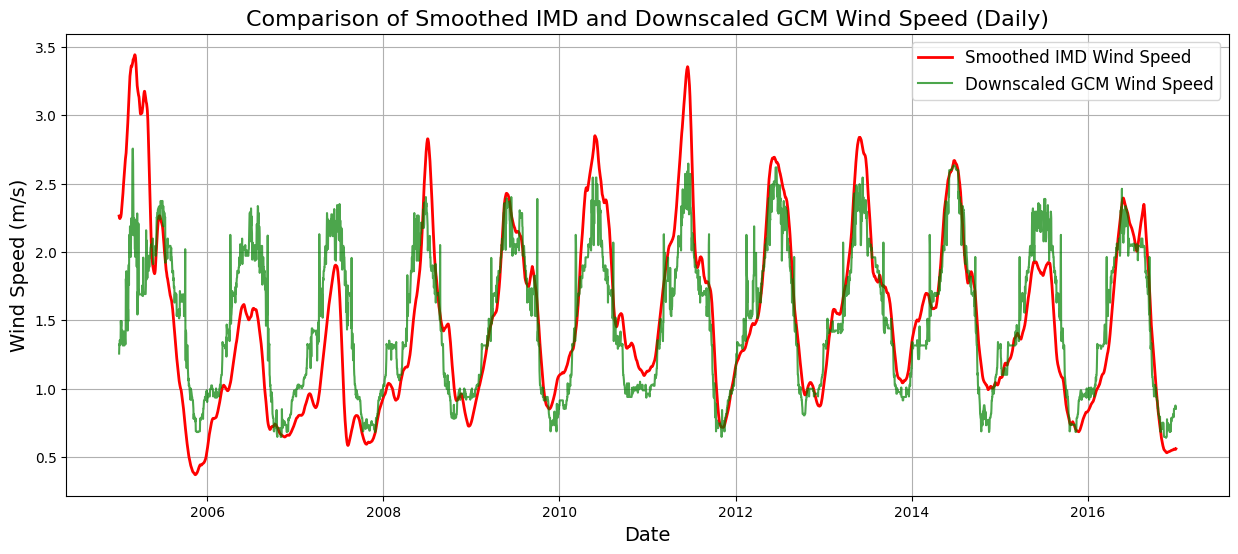

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from pyts.decomposition import SingularSpectrumAnalysis

# Load dataset
file_path = "/content/drive/MyDrive/My Work/GCM_IMD_2005_2016_Wind_speed.csv"
data = pd.read_csv(file_path)

# Clean column names
data.columns = data.columns.str.strip()

# Convert date columns to a single datetime column
data['Date'] = pd.to_datetime(data[['YEAR', 'MONTH', 'DAY']], errors='coerce')
data.set_index('Date', inplace=True)

# Ensure no missing values in GCM_WIND_SPEED and IMD_Wind_Speed columns
if data[['GCM_WIND_SPEED', 'IMD_Wind_Speed']].isnull().any().any():
    print("Warning: Missing values detected. Dropping rows with missing values.")
    data = data.dropna(subset=['GCM_WIND_SPEED', 'IMD_Wind_Speed'])

# Apply SSA for IMD Wind Speed
imd_series = data['IMD_Wind_Speed'].values.reshape(1, -1)  # Reshape for SSA
ssa_imd = SingularSpectrumAnalysis(window_size=30)
imd_components = ssa_imd.fit_transform(imd_series)

# Reconstruct IMD wind speed (using the first component for trend)
imd_smoothed = imd_components[:, 0].flatten()  # Take the first component (trend)

# Apply SSA for GCM Wind Speed
gcm_series = data['GCM_WIND_SPEED'].values.reshape(1, -1)  # Reshape for SSA
ssa_gcm = SingularSpectrumAnalysis(window_size=30)
gcm_components = ssa_gcm.fit_transform(gcm_series)

# Reconstruct GCM wind speed (using the first component for trend)
gcm_smoothed = gcm_components[:, 0].flatten()  # Take the first component (trend)

# Add smoothed data to the original DataFrame
data['IMD_Smoothed'] = imd_smoothed
data['GCM_Smoothed'] = gcm_smoothed

# Prepare data for Gradient Boosting regression
x_smoothed = data['GCM_Smoothed'].values.reshape(-1, 1)
y_smoothed = data['IMD_Smoothed'].values

# Standardize the features
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_smoothed)

# Train Gradient Boosting regression model
model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(x_scaled, y_smoothed)

# Predict IMD wind speed using downscaled GCM wind speed
data['Downscaled_GCM_WIND_SPEED'] = model.predict(x_scaled)

# Compute statistical metrics for downscaled data
bias = data['Downscaled_GCM_WIND_SPEED'] - data['IMD_Smoothed']
mse = mean_squared_error(data['IMD_Smoothed'], data['Downscaled_GCM_WIND_SPEED'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(data['IMD_Smoothed'], data['Downscaled_GCM_WIND_SPEED'])
r2 = r2_score(data['IMD_Smoothed'], data['Downscaled_GCM_WIND_SPEED'])
correlation = data['IMD_Smoothed'].corr(data['Downscaled_GCM_WIND_SPEED'])

# Print statistical metrics
print("\nStatistical Metrics After Downscaling:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²): {r2:.2f}")
print(f"Correlation: {correlation:.2f}")

# Plot IMD wind speed
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['IMD_Wind_Speed'], label='Original IMD Wind Speed', color='blue', alpha=0.5)
plt.plot(data.index, data['IMD_Smoothed'], label='Smoothed IMD Wind Speed (SSA)', color='red', linewidth=2)
plt.title("IMD Wind Speed with SSA Smoothing", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Plot smoothed GCM wind speed
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['GCM_WIND_SPEED'], label='Original GCM Wind Speed', color='orange', alpha=0.5)
plt.plot(data.index, data['GCM_Smoothed'], label='Smoothed GCM Wind Speed (SSA)', color='green', linewidth=2)
plt.title("GCM Wind Speed with SSA Smoothing", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Combined plot for comparison
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['IMD_Smoothed'], label='Smoothed IMD Wind Speed', color='red', linewidth=2)
plt.plot(data.index, data['GCM_Smoothed'], label='Smoothed GCM Wind Speed', color='green', linewidth=2)
plt.title("Comparison of Smoothed IMD and GCM Wind Speeds", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Plot Downscaled GCM wind speed
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['IMD_Smoothed'], label='Smoothed IMD Wind Speed', color='red', linewidth=2)
plt.plot(data.index, data['Downscaled_GCM_WIND_SPEED'], label='Downscaled GCM Wind Speed', color='green', alpha=0.7)
plt.title("Comparison of Smoothed IMD and Downscaled GCM Wind Speed (Daily)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()


# 4. Decision Tree Regression


Statistical Metrics After Downscaling:
Mean Squared Error (MSE): 0.77
Root Mean Squared Error (RMSE): 0.88
Mean Absolute Error (MAE): 0.59
R-squared (R²): 0.31
Correlation: 0.55


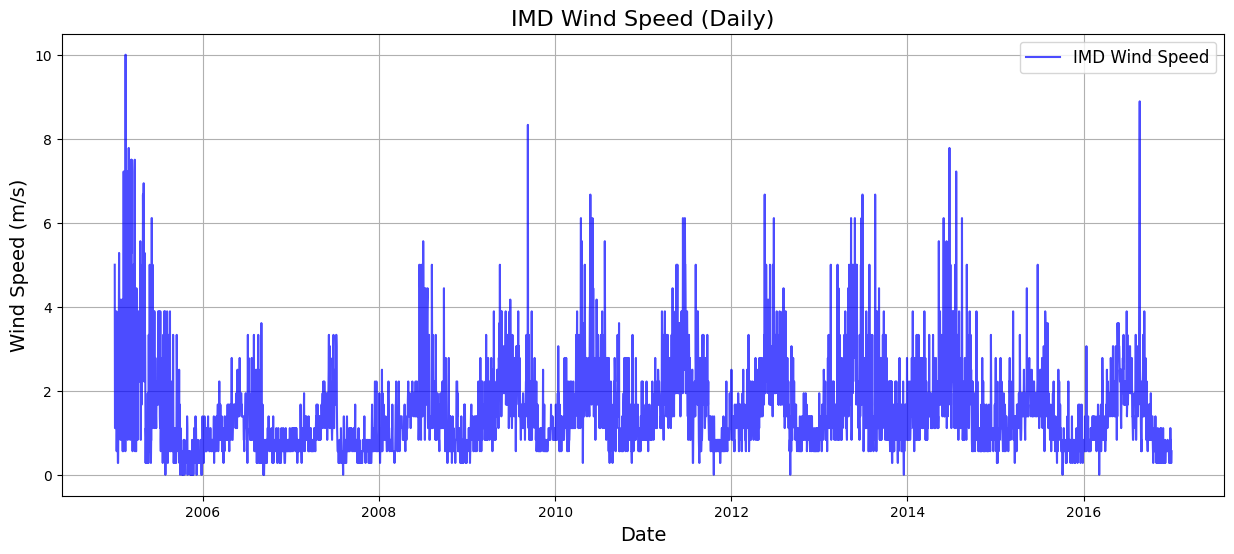

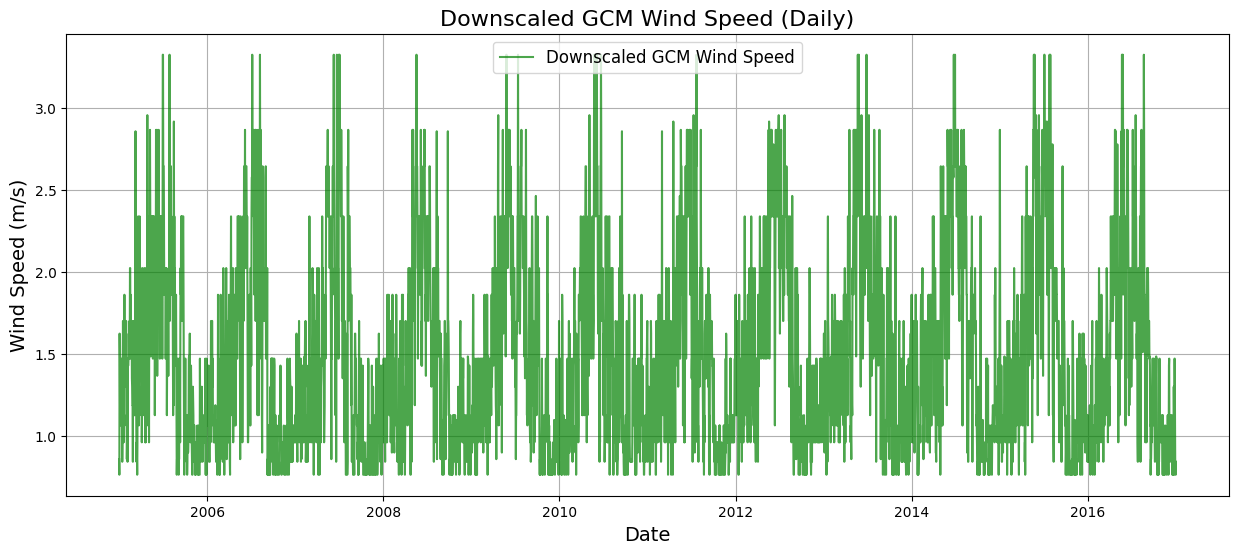

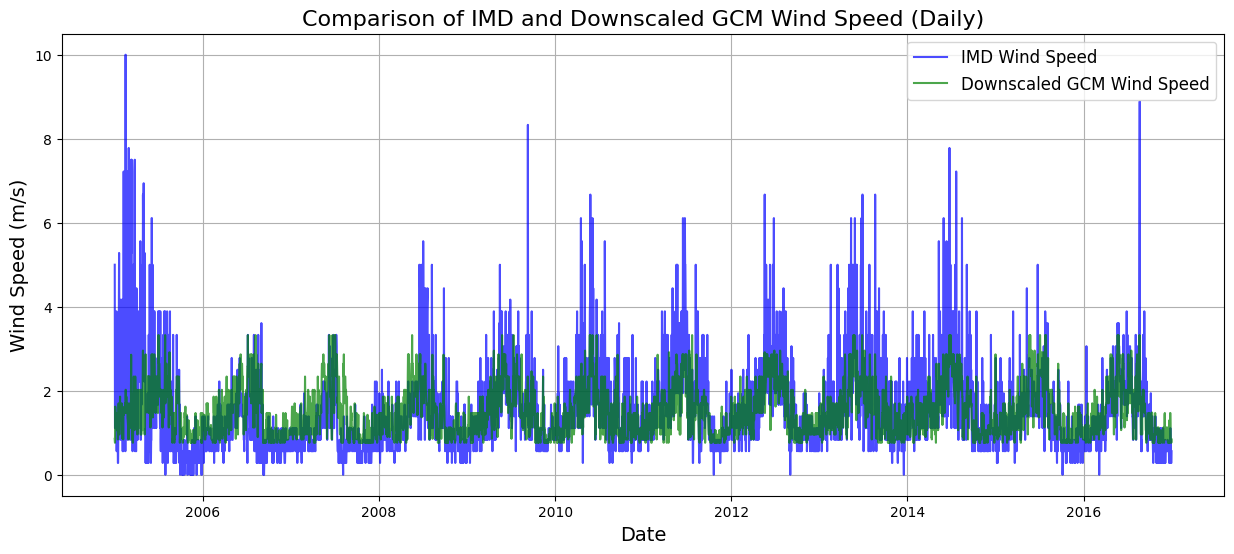

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Load dataset
file_path = "/content/drive/MyDrive/My Work/GCM_IMD_2005_2016_Wind_speed.csv"
data = pd.read_csv(file_path)

# Clean column names
data.columns = data.columns.str.strip()

# Convert date columns to a single datetime column
data['Date'] = pd.to_datetime(data[['YEAR', 'MONTH', 'DAY']], errors='coerce')
data.set_index('Date', inplace=True)

# Ensure no missing values in GCM_WIND_SPEED and IMD_Wind_Speed columns
if data[['GCM_WIND_SPEED', 'IMD_Wind_Speed']].isnull().any().any():
    print("Warning: Missing values detected. Dropping rows with missing values.")
    data = data.dropna(subset=['GCM_WIND_SPEED', 'IMD_Wind_Speed'])

# Prepare data for regression
dates = data.index.values.reshape(-1, 1)
x = data['GCM_WIND_SPEED'].values.reshape(-1, 1)
y = data['IMD_Wind_Speed'].values

# Standardize the features
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Train Decision Tree regression model
model_dt = DecisionTreeRegressor(max_depth=5, random_state=42)
model_dt.fit(x_scaled, y)

# Predict IMD wind speed using downscaled GCM wind speed
data['Downscaled_GCM_WIND_SPEED'] = model_dt.predict(x_scaled)

# Compute statistical metrics for downscaled data
bias = data['Downscaled_GCM_WIND_SPEED'] - data['IMD_Wind_Speed']
mse = mean_squared_error(data['IMD_Wind_Speed'], data['Downscaled_GCM_WIND_SPEED'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(data['IMD_Wind_Speed'], data['Downscaled_GCM_WIND_SPEED'])
r2 = r2_score(data['IMD_Wind_Speed'], data['Downscaled_GCM_WIND_SPEED'])
correlation = data['IMD_Wind_Speed'].corr(data['Downscaled_GCM_WIND_SPEED'])

# Print statistical metrics
print("\nStatistical Metrics After Downscaling:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²): {r2:.2f}")
print(f"Correlation: {correlation:.2f}")

# Plot IMD wind speed
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['IMD_Wind_Speed'], label='IMD Wind Speed', color='blue', alpha=0.7)
plt.title("IMD Wind Speed (Daily)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Plot Downscaled GCM wind speed
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['Downscaled_GCM_WIND_SPEED'], label='Downscaled GCM Wind Speed', color='green', alpha=0.7)
plt.title("Downscaled GCM Wind Speed (Daily)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Combined plot for comparison
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['IMD_Wind_Speed'], label='IMD Wind Speed', color='blue', alpha=0.7)
plt.plot(data.index, data['Downscaled_GCM_WIND_SPEED'], label='Downscaled GCM Wind Speed', color='green', alpha=0.7)
plt.title("Comparison of IMD and Downscaled GCM Wind Speed (Daily)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()


# Decision Tree Regression on Smooth data


Statistical Metrics After Downscaling:
Mean Squared Error (MSE): 0.15
Root Mean Squared Error (RMSE): 0.39
Mean Absolute Error (MAE): 0.28
R-squared (R²): 0.64
Correlation: 0.80


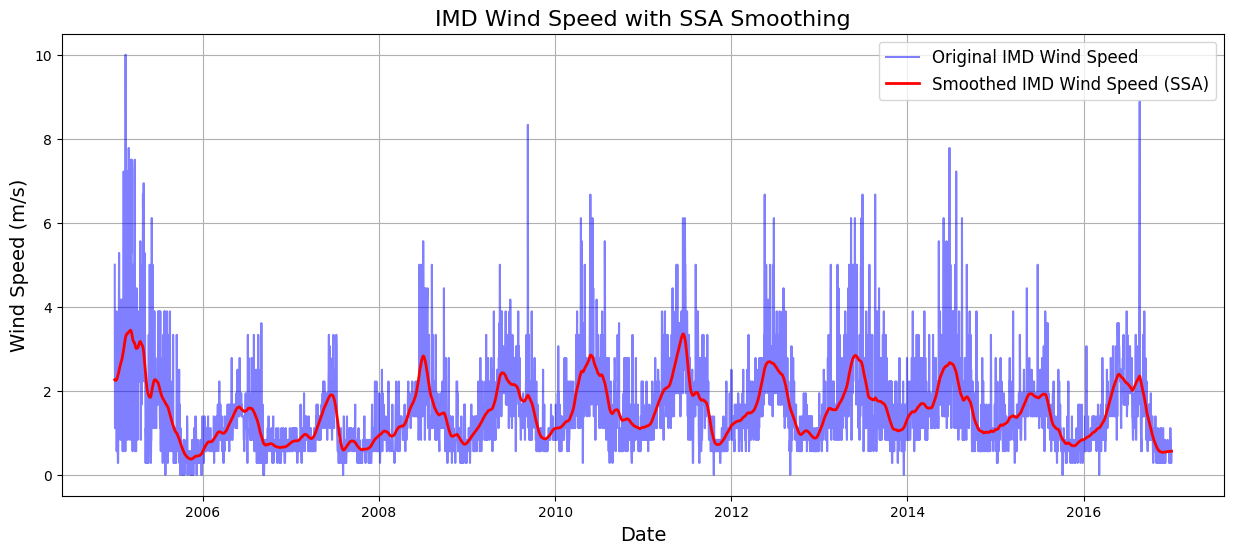

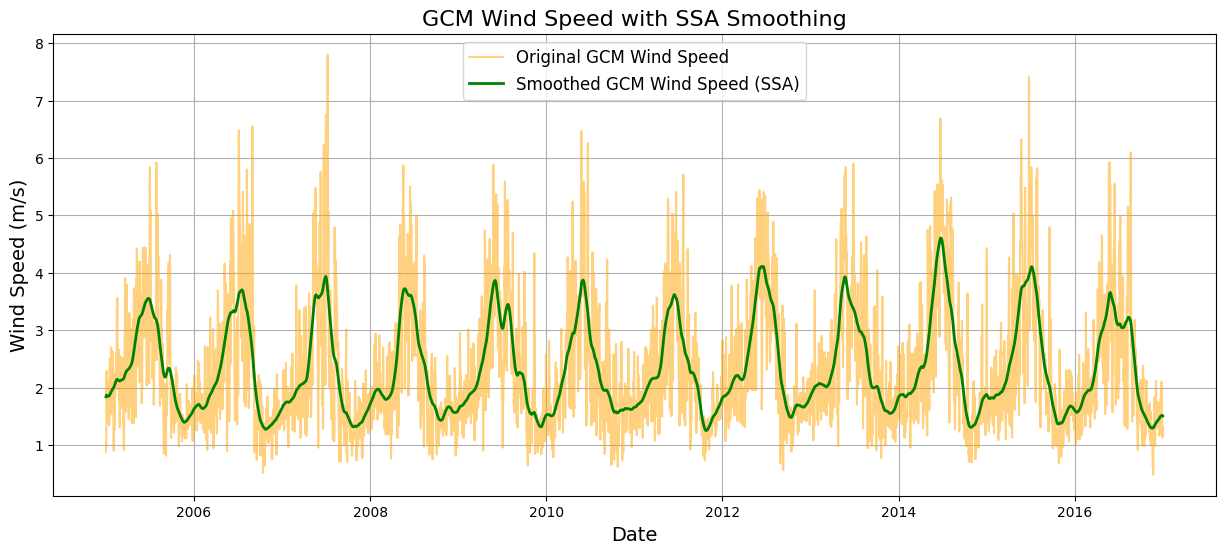

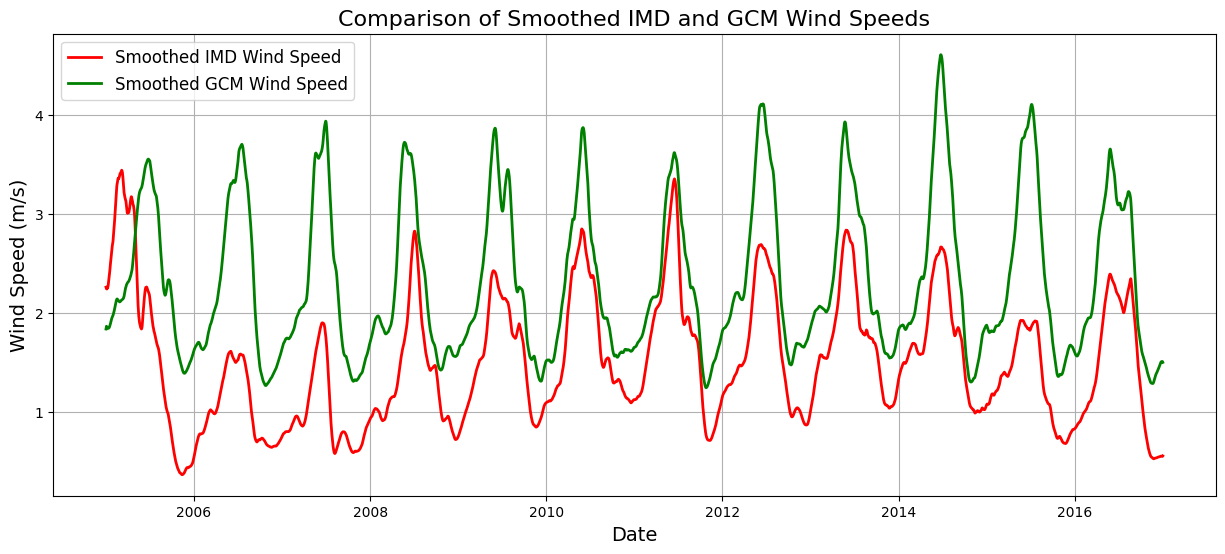

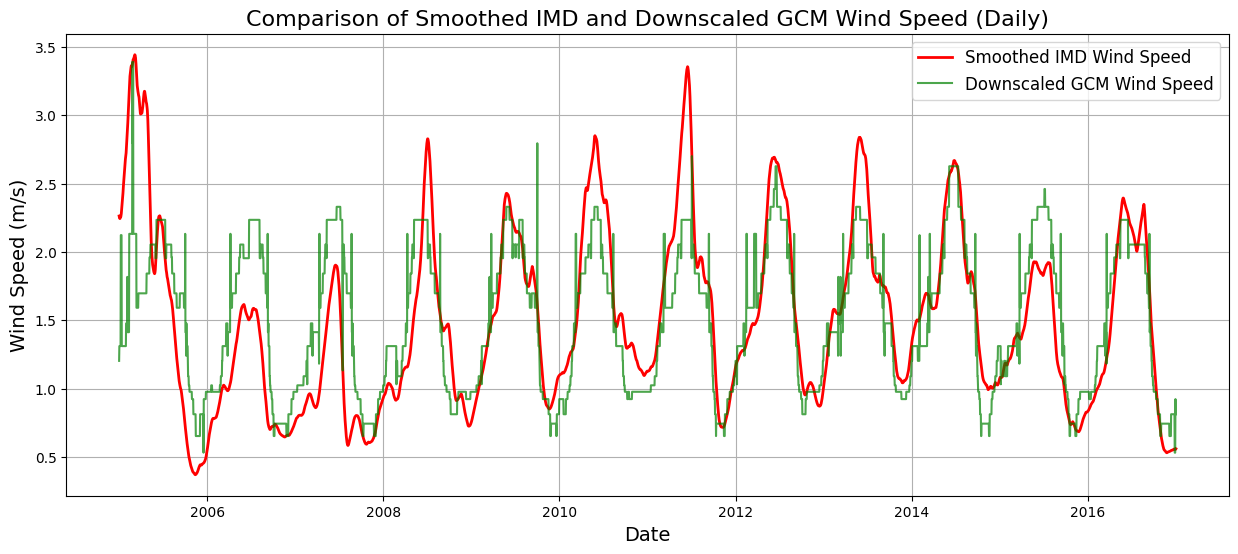

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from pyts.decomposition import SingularSpectrumAnalysis

# Load dataset
file_path = "/content/drive/MyDrive/My Work/GCM_IMD_2005_2016_Wind_speed.csv"
data = pd.read_csv(file_path)

# Clean column names
data.columns = data.columns.str.strip()

# Convert date columns to a single datetime column
data['Date'] = pd.to_datetime(data[['YEAR', 'MONTH', 'DAY']], errors='coerce')
data.set_index('Date', inplace=True)

# Ensure no missing values in GCM_WIND_SPEED and IMD_Wind_Speed columns
if data[['GCM_WIND_SPEED', 'IMD_Wind_Speed']].isnull().any().any():
    print("Warning: Missing values detected. Dropping rows with missing values.")
    data = data.dropna(subset=['GCM_WIND_SPEED', 'IMD_Wind_Speed'])

# Apply SSA for IMD Wind Speed
imd_series = data['IMD_Wind_Speed'].values.reshape(1, -1)  # Reshape for SSA
ssa_imd = SingularSpectrumAnalysis(window_size=30)
imd_components = ssa_imd.fit_transform(imd_series)

# Reconstruct IMD wind speed (using the first component for trend)
imd_smoothed = imd_components[:, 0].flatten()  # Take the first component (trend)

# Apply SSA for GCM Wind Speed
gcm_series = data['GCM_WIND_SPEED'].values.reshape(1, -1)  # Reshape for SSA
ssa_gcm = SingularSpectrumAnalysis(window_size=30)
gcm_components = ssa_gcm.fit_transform(gcm_series)

# Reconstruct GCM wind speed (using the first component for trend)
gcm_smoothed = gcm_components[:, 0].flatten()  # Take the first component (trend)

# Add smoothed data to the original DataFrame
data['IMD_Smoothed'] = imd_smoothed
data['GCM_Smoothed'] = gcm_smoothed

# Prepare data for Decision Tree regression
x_smoothed = data['GCM_Smoothed'].values.reshape(-1, 1)
y_smoothed = data['IMD_Smoothed'].values

# Standardize the features
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_smoothed)

# Train Decision Tree regression model
model = DecisionTreeRegressor(max_depth=5, random_state=42)
model.fit(x_scaled, y_smoothed)

# Predict IMD wind speed using downscaled GCM wind speed
data['Downscaled_GCM_WIND_SPEED'] = model.predict(x_scaled)

# Compute statistical metrics for downscaled data
bias = data['Downscaled_GCM_WIND_SPEED'] - data['IMD_Smoothed']
mse = mean_squared_error(data['IMD_Smoothed'], data['Downscaled_GCM_WIND_SPEED'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(data['IMD_Smoothed'], data['Downscaled_GCM_WIND_SPEED'])
r2 = r2_score(data['IMD_Smoothed'], data['Downscaled_GCM_WIND_SPEED'])
correlation = data['IMD_Smoothed'].corr(data['Downscaled_GCM_WIND_SPEED'])

# Print statistical metrics
print("\nStatistical Metrics After Downscaling:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²): {r2:.2f}")
print(f"Correlation: {correlation:.2f}")

# Plot IMD wind speed
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['IMD_Wind_Speed'], label='Original IMD Wind Speed', color='blue', alpha=0.5)
plt.plot(data.index, data['IMD_Smoothed'], label='Smoothed IMD Wind Speed (SSA)', color='red', linewidth=2)
plt.title("IMD Wind Speed with SSA Smoothing", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Plot smoothed GCM wind speed
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['GCM_WIND_SPEED'], label='Original GCM Wind Speed', color='orange', alpha=0.5)
plt.plot(data.index, data['GCM_Smoothed'], label='Smoothed GCM Wind Speed (SSA)', color='green', linewidth=2)
plt.title("GCM Wind Speed with SSA Smoothing", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Combined plot for comparison
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['IMD_Smoothed'], label='Smoothed IMD Wind Speed', color='red', linewidth=2)
plt.plot(data.index, data['GCM_Smoothed'], label='Smoothed GCM Wind Speed', color='green', linewidth=2)
plt.title("Comparison of Smoothed IMD and GCM Wind Speeds", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Plot Downscaled GCM wind speed
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['IMD_Smoothed'], label='Smoothed IMD Wind Speed', color='red', linewidth=2)
plt.plot(data.index, data['Downscaled_GCM_WIND_SPEED'], label='Downscaled GCM Wind Speed', color='green', alpha=0.7)
plt.title("Comparison of Smoothed IMD and Downscaled GCM Wind Speed (Daily)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()


# 5. Support Vector Machine regression model


Statistical Metrics After Downscaling:
Mean Squared Error (MSE): 0.82
Root Mean Squared Error (RMSE): 0.91
Mean Absolute Error (MAE): 0.57
R-squared (R²): 0.26
Correlation: 0.54


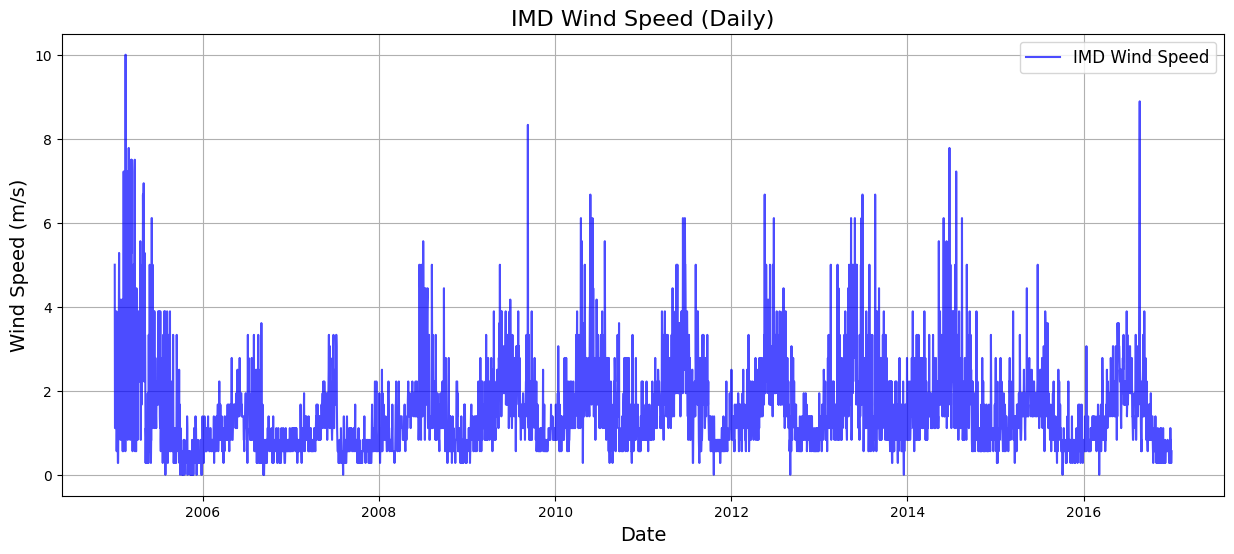

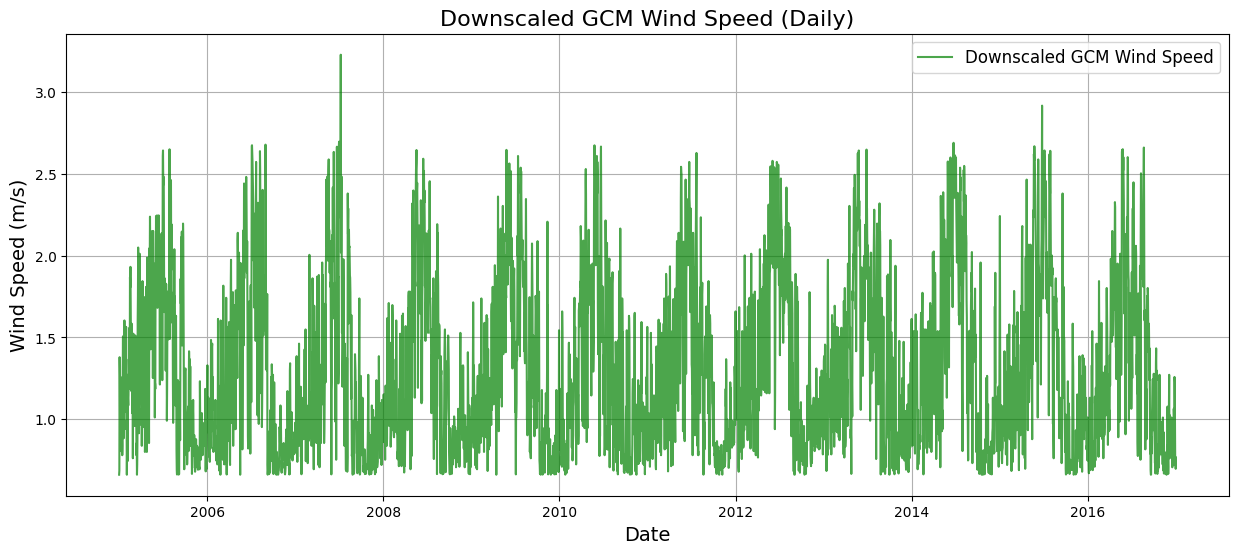

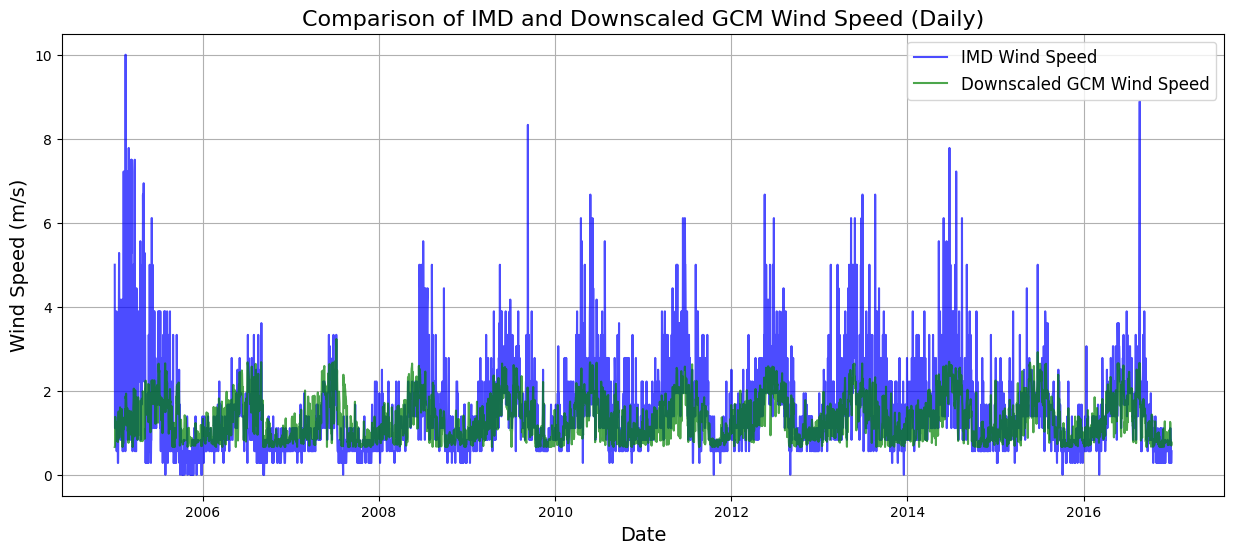

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Load dataset
file_path = "/content/drive/MyDrive/My Work/GCM_IMD_2005_2016_Wind_speed.csv"
data = pd.read_csv(file_path)

# Clean column names
data.columns = data.columns.str.strip()

# Convert date columns to a single datetime column
data['Date'] = pd.to_datetime(data[['YEAR', 'MONTH', 'DAY']], errors='coerce')
data.set_index('Date', inplace=True)

# Ensure no missing values in GCM_WIND_SPEED and IMD_Wind_Speed columns
if data[['GCM_WIND_SPEED', 'IMD_Wind_Speed']].isnull().any().any():
    print("Warning: Missing values detected. Dropping rows with missing values.")
    data = data.dropna(subset=['GCM_WIND_SPEED', 'IMD_Wind_Speed'])

# Prepare data for regression
dates = data.index.values.reshape(-1, 1)
x = data['GCM_WIND_SPEED'].values.reshape(-1, 1)
y = data['IMD_Wind_Speed'].values

# Standardize the features
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Train Support Vector Machine regression model
model_svm = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
model_svm.fit(x_scaled, y)

# Predict IMD wind speed using downscaled GCM wind speed
data['Downscaled_GCM_WIND_SPEED'] = model_svm.predict(x_scaled)

# Compute statistical metrics for downscaled data
bias = data['Downscaled_GCM_WIND_SPEED'] - data['IMD_Wind_Speed']
mse = mean_squared_error(data['IMD_Wind_Speed'], data['Downscaled_GCM_WIND_SPEED'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(data['IMD_Wind_Speed'], data['Downscaled_GCM_WIND_SPEED'])
r2 = r2_score(data['IMD_Wind_Speed'], data['Downscaled_GCM_WIND_SPEED'])
correlation = data['IMD_Wind_Speed'].corr(data['Downscaled_GCM_WIND_SPEED'])

# Print statistical metrics
print("\nStatistical Metrics After Downscaling:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²): {r2:.2f}")
print(f"Correlation: {correlation:.2f}")

# Plot IMD wind speed
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['IMD_Wind_Speed'], label='IMD Wind Speed', color='blue', alpha=0.7)
plt.title("IMD Wind Speed (Daily)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Plot Downscaled GCM wind speed
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['Downscaled_GCM_WIND_SPEED'], label='Downscaled GCM Wind Speed', color='green', alpha=0.7)
plt.title("Downscaled GCM Wind Speed (Daily)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Combined plot for comparison
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['IMD_Wind_Speed'], label='IMD Wind Speed', color='blue', alpha=0.7)
plt.plot(data.index, data['Downscaled_GCM_WIND_SPEED'], label='Downscaled GCM Wind Speed', color='green', alpha=0.7)
plt.title("Comparison of IMD and Downscaled GCM Wind Speed (Daily)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()


# Support Vector Machine regression model on Smooth Data


Statistical Metrics After Downscaling:
Mean Squared Error (MSE): 0.17
Root Mean Squared Error (RMSE): 0.41
Mean Absolute Error (MAE): 0.29
R-squared (R²): 0.60
Correlation: 0.78


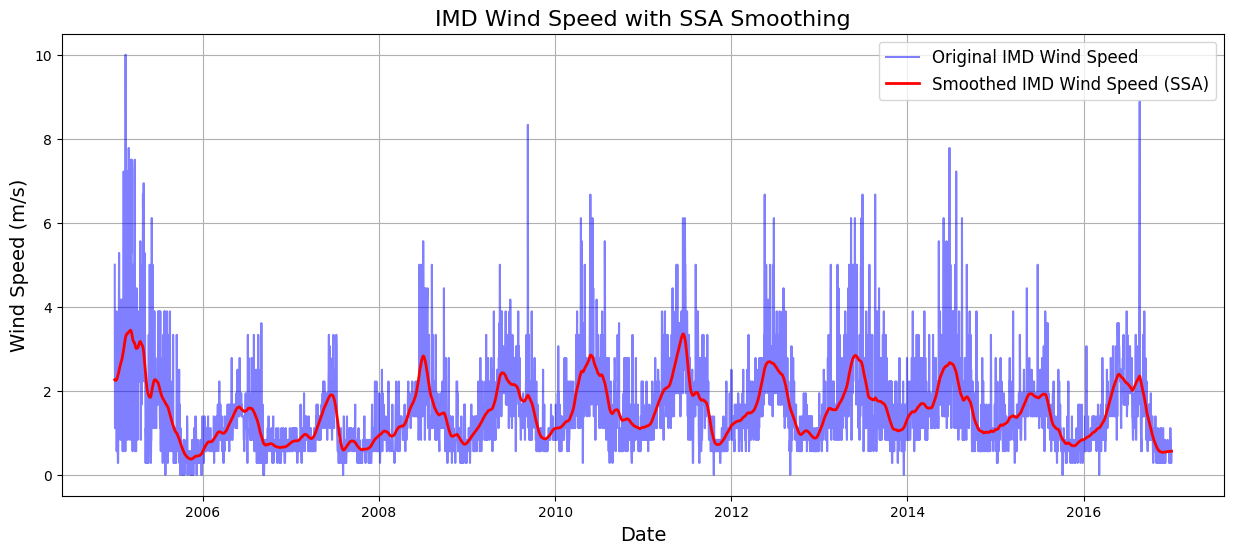

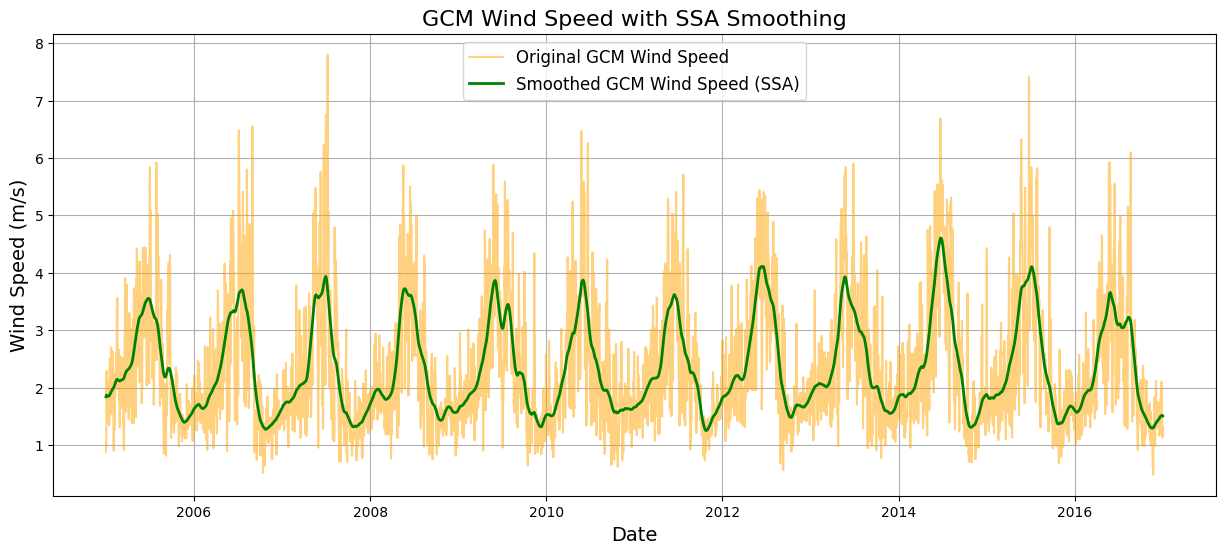

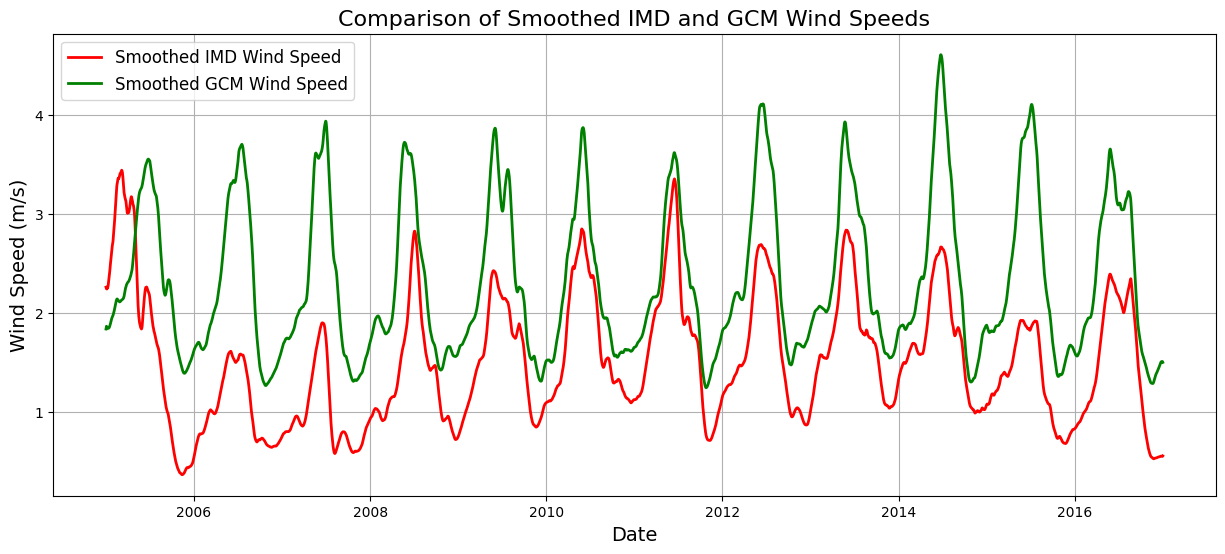

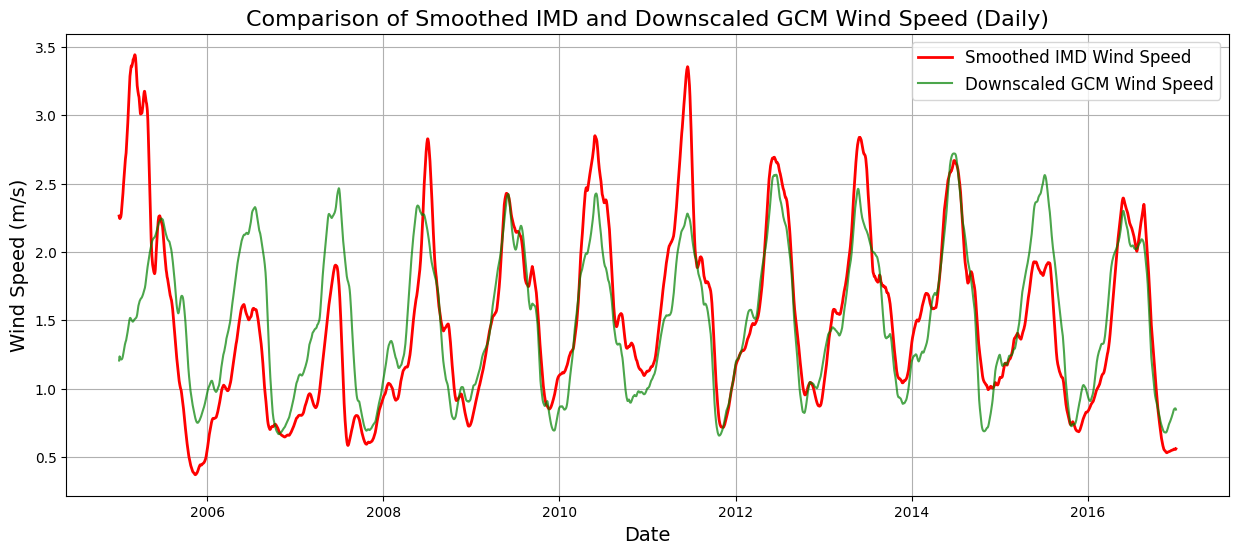

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR
from pyts.decomposition import SingularSpectrumAnalysis

# Load dataset
file_path = "/content/drive/MyDrive/My Work/GCM_IMD_2005_2016_Wind_speed.csv"
data = pd.read_csv(file_path)

# Clean column names
data.columns = data.columns.str.strip()

# Convert date columns to a single datetime column
data['Date'] = pd.to_datetime(data[['YEAR', 'MONTH', 'DAY']], errors='coerce')
data.set_index('Date', inplace=True)

# Ensure no missing values in GCM_WIND_SPEED and IMD_Wind_Speed columns
if data[['GCM_WIND_SPEED', 'IMD_Wind_Speed']].isnull().any().any():
    print("Warning: Missing values detected. Dropping rows with missing values.")
    data = data.dropna(subset=['GCM_WIND_SPEED', 'IMD_Wind_Speed'])

# Apply SSA for IMD Wind Speed
imd_series = data['IMD_Wind_Speed'].values.reshape(1, -1)  # Reshape for SSA
ssa_imd = SingularSpectrumAnalysis(window_size=30)
imd_components = ssa_imd.fit_transform(imd_series)

# Reconstruct IMD wind speed (using the first component for trend)
imd_smoothed = imd_components[:, 0].flatten()  # Take the first component (trend)

# Apply SSA for GCM Wind Speed
gcm_series = data['GCM_WIND_SPEED'].values.reshape(1, -1)  # Reshape for SSA
ssa_gcm = SingularSpectrumAnalysis(window_size=30)
gcm_components = ssa_gcm.fit_transform(gcm_series)

# Reconstruct GCM wind speed (using the first component for trend)
gcm_smoothed = gcm_components[:, 0].flatten()  # Take the first component (trend)

# Add smoothed data to the original DataFrame
data['IMD_Smoothed'] = imd_smoothed
data['GCM_Smoothed'] = gcm_smoothed

# Prepare data for regression
x_smoothed = data['GCM_Smoothed'].values.reshape(-1, 1)
y_smoothed = data['IMD_Smoothed'].values

# Standardize the features
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_smoothed)

# Train Support Vector Machine regression model
model_svm = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
model_svm.fit(x_scaled, y_smoothed)

# Predict IMD wind speed using downscaled GCM wind speed
data['Downscaled_GCM_WIND_SPEED'] = model_svm.predict(x_scaled)

# Compute statistical metrics for downscaled data
bias = data['Downscaled_GCM_WIND_SPEED'] - data['IMD_Smoothed']
mse = mean_squared_error(data['IMD_Smoothed'], data['Downscaled_GCM_WIND_SPEED'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(data['IMD_Smoothed'], data['Downscaled_GCM_WIND_SPEED'])
r2 = r2_score(data['IMD_Smoothed'], data['Downscaled_GCM_WIND_SPEED'])
correlation = data['IMD_Smoothed'].corr(data['Downscaled_GCM_WIND_SPEED'])

# Print statistical metrics
print("\nStatistical Metrics After Downscaling:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²): {r2:.2f}")
print(f"Correlation: {correlation:.2f}")

# Plot IMD wind speed
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['IMD_Wind_Speed'], label='Original IMD Wind Speed', color='blue', alpha=0.5)
plt.plot(data.index, data['IMD_Smoothed'], label='Smoothed IMD Wind Speed (SSA)', color='red', linewidth=2)
plt.title("IMD Wind Speed with SSA Smoothing", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Plot smoothed GCM wind speed
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['GCM_WIND_SPEED'], label='Original GCM Wind Speed', color='orange', alpha=0.5)
plt.plot(data.index, data['GCM_Smoothed'], label='Smoothed GCM Wind Speed (SSA)', color='green', linewidth=2)
plt.title("GCM Wind Speed with SSA Smoothing", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Combined plot for comparison
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['IMD_Smoothed'], label='Smoothed IMD Wind Speed', color='red', linewidth=2)
plt.plot(data.index, data['GCM_Smoothed'], label='Smoothed GCM Wind Speed', color='green', linewidth=2)
plt.title("Comparison of Smoothed IMD and GCM Wind Speeds", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Plot Downscaled GCM wind speed
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['IMD_Smoothed'], label='Smoothed IMD Wind Speed', color='red', linewidth=2)
plt.plot(data.index, data['Downscaled_GCM_WIND_SPEED'], label='Downscaled GCM Wind Speed', color='green', alpha=0.7)
plt.title("Comparison of Smoothed IMD and Downscaled GCM Wind Speed (Daily)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()


# 6. hybrid LSTM + CNN model

Epoch 1/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - loss: 0.4131 - val_loss: 0.3339
Epoch 2/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3300 - val_loss: 0.2051
Epoch 3/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3171 - val_loss: 0.1556
Epoch 4/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3195 - val_loss: 0.1790
Epoch 5/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3043 - val_loss: 0.1676
Epoch 6/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3017 - val_loss: 0.1622
Epoch 7/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3184 - val_loss: 0.1570
Epoch 8/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2940 - val_loss: 0.1617
Epoch 9/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3138 - val_loss: 0.1602
Epoch 10/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3029 - val_loss: 0.1549
Epoch 11/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3059 - val_loss: 0.1776
Epoch 12/200
219/219 ━━━━━━━━━━━━━━━━━━

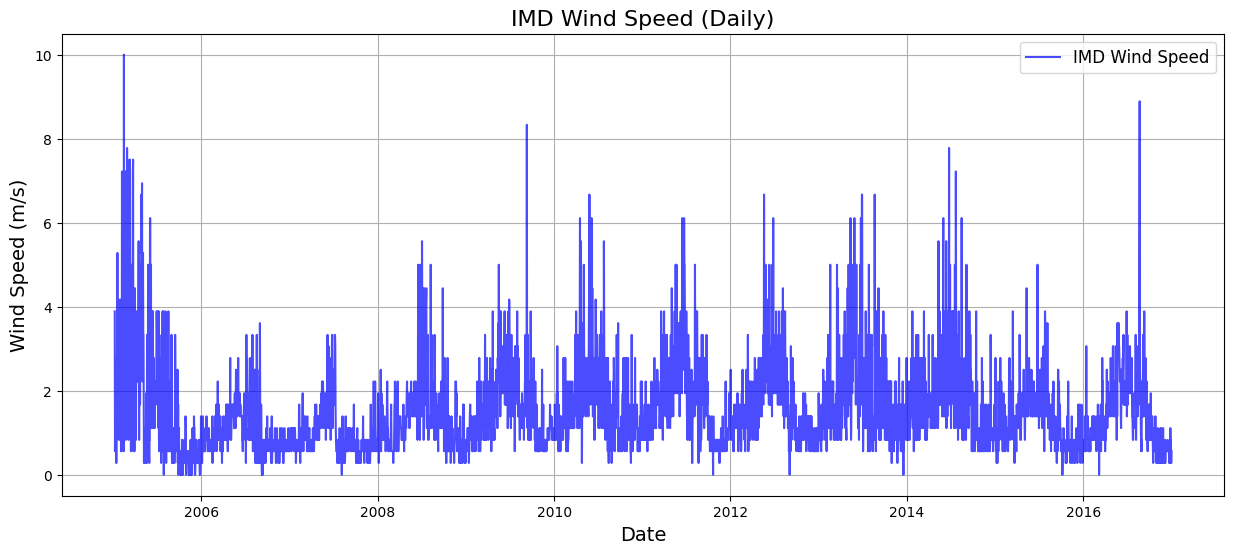

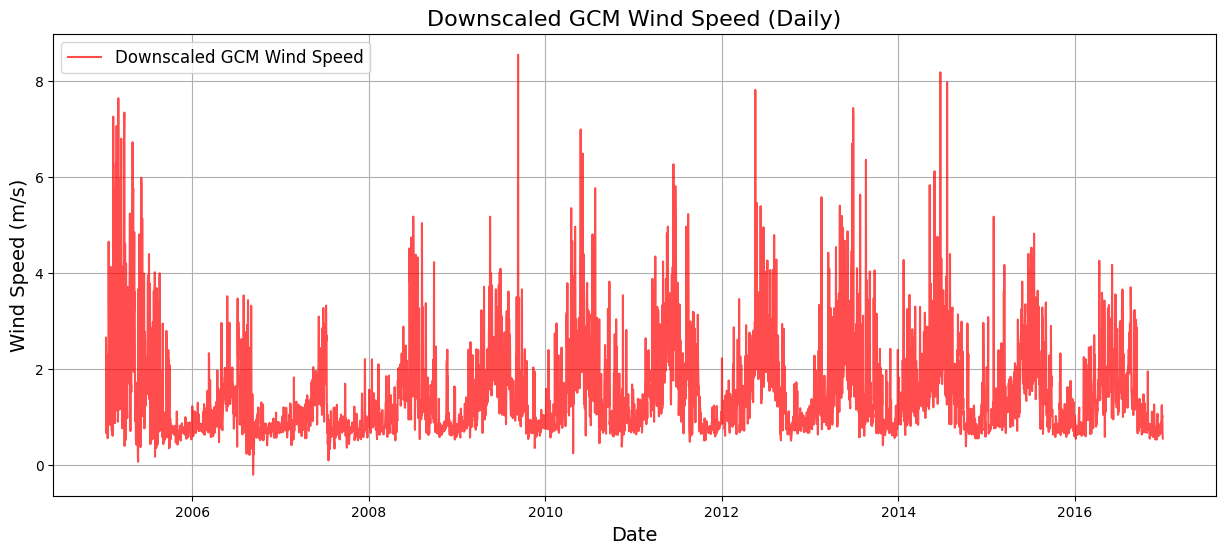

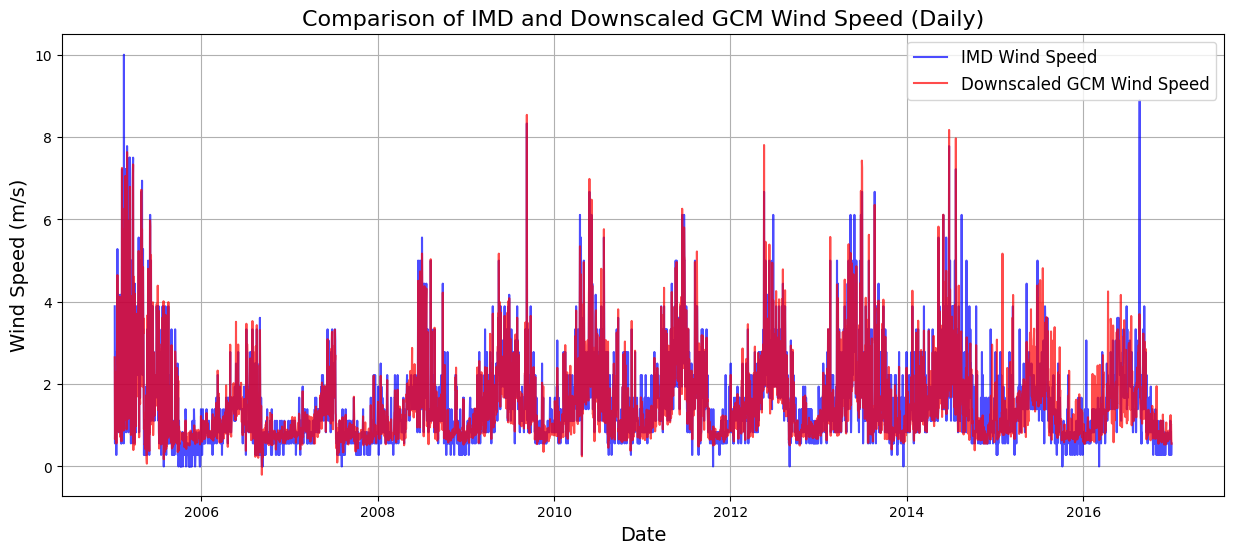

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Flatten, Input, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.losses import Huber
# Load dataset
file_path = "/content/drive/MyDrive/My Work/GCM_IMD_2005_2016_Wind_speed.csv"
data = pd.read_csv(file_path)

# Clean column names
data.columns = data.columns.str.strip()

# Convert date columns to a single datetime column
data['Date'] = pd.to_datetime(data[['YEAR', 'MONTH', 'DAY']], errors='coerce')
data.set_index('Date', inplace=True)

# Ensure no missing values in GCM_WIND_SPEED and IMD_Wind_Speed columns
if data[['GCM_WIND_SPEED', 'IMD_Wind_Speed']].isnull().any().any():
    print("Warning: Missing values detected. Dropping rows with missing values.")
    data = data.dropna(subset=['GCM_WIND_SPEED', 'IMD_Wind_Speed'])

# Prepare data for LSTM + CNN model with sliding window approach
sequence_length = 7
x, y = [], []
for i in range(len(data) - sequence_length):
    x.append(data['GCM_WIND_SPEED'].values[i:i+sequence_length])
    y.append(data['IMD_Wind_Speed'].values[i + sequence_length])
x, y = np.array(x), np.array(y)

# Standardize the features
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x.reshape(-1, 1)).reshape(x.shape)

# Reshape data for CNN + LSTM
x_scaled = x_scaled.reshape((x_scaled.shape[0], x_scaled.shape[1], 1))

# Build LSTM + CNN model with improvements
model = Sequential()
model.add(Input(shape=(sequence_length, 1)))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(100, activation='relu', return_sequences=True)))
model.add(Dropout(0.4))
model.add(LSTM(50, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1))

# Compile the model with Huber loss
model.compile(optimizer='adam', loss=Huber())

# Train the model
model.fit(x_scaled, y, epochs=200, batch_size=16, verbose=1, validation_split=0.2)

# Predict IMD wind speed using downscaled GCM wind speed
predictions = model.predict(x_scaled)

# Create a new DataFrame for predictions with the correct index
# We shift the index by 'sequence_length' to align with the predictions
prediction_index = data.index[sequence_length:]
predictions_df = pd.DataFrame(predictions, index=prediction_index, columns=['Downscaled_GCM_WIND_SPEED'])

# Concatenate the predictions with the original DataFrame
data = pd.concat([data, predictions_df], axis=1)

# Now 'data' contains both original and predicted values, aligned by date
# You can proceed with your calculations and plotting using this DataFrame

# Handle NaN values before computing metrics
# Drop rows with NaN values in either 'IMD_Wind_Speed' or 'Downscaled_GCM_WIND_SPEED'
data = data.dropna(subset=['IMD_Wind_Speed', 'Downscaled_GCM_WIND_SPEED'])


# Compute statistical metrics for downscaled data
bias = data['Downscaled_GCM_WIND_SPEED'] - data['IMD_Wind_Speed']
mse = mean_squared_error(data['IMD_Wind_Speed'], data['Downscaled_GCM_WIND_SPEED'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(data['IMD_Wind_Speed'], data['Downscaled_GCM_WIND_SPEED'])
r2 = r2_score(data['IMD_Wind_Speed'], data['Downscaled_GCM_WIND_SPEED'])
correlation = data['IMD_Wind_Speed'].corr(data['Downscaled_GCM_WIND_SPEED'])

# Print statistical metrics
print("\nStatistical Metrics After Downscaling:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²): {r2:.2f}")
print(f"Correlation: {correlation:.2f}")

# Plot IMD wind speed
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['IMD_Wind_Speed'], label='IMD Wind Speed', color='blue', alpha=0.7)
plt.title("IMD Wind Speed (Daily)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Plot Downscaled GCM wind speed
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['Downscaled_GCM_WIND_SPEED'], label='Downscaled GCM Wind Speed', color='red', alpha=0.7)
plt.title("Downscaled GCM Wind Speed (Daily)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Combined plot for comparison
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['IMD_Wind_Speed'], label='IMD Wind Speed', color='blue', alpha=0.7)
plt.plot(data.index, data['Downscaled_GCM_WIND_SPEED'], label='Downscaled GCM Wind Speed', color='red', alpha=0.7)
plt.title("Comparison of IMD and Downscaled GCM Wind Speed (Daily)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()


# Hybrid LSTM+CNN on Smooth data

Epoch 1/250
219/219 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - loss: 0.2329 - val_loss: 0.1475
Epoch 2/250
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1153 - val_loss: 0.0356
Epoch 3/250
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0985 - val_loss: 0.0360
Epoch 4/250
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0976 - val_loss: 0.0532
Epoch 5/250
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1018 - val_loss: 0.0478
Epoch 6/250
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0934 - val_loss: 0.0427
Epoch 7/250
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0958 - val_loss: 0.0318
Epoch 8/250
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0945 - val_loss: 0.0261
Epoch 9/250
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1002 - val_loss: 0.0329
Epoch 10/250
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1064 - val_loss: 0.0279
Epoch 11/250
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0939 - val_loss: 0.0423
Epoch 12/250
219/219 ━━━━━━━━━━━━━━━━━━

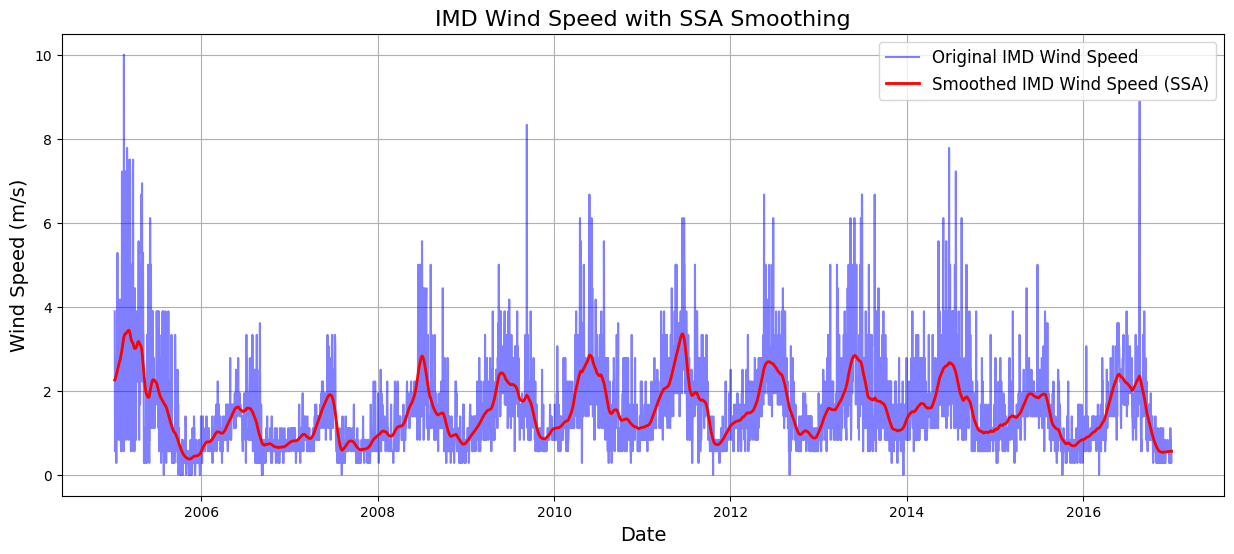

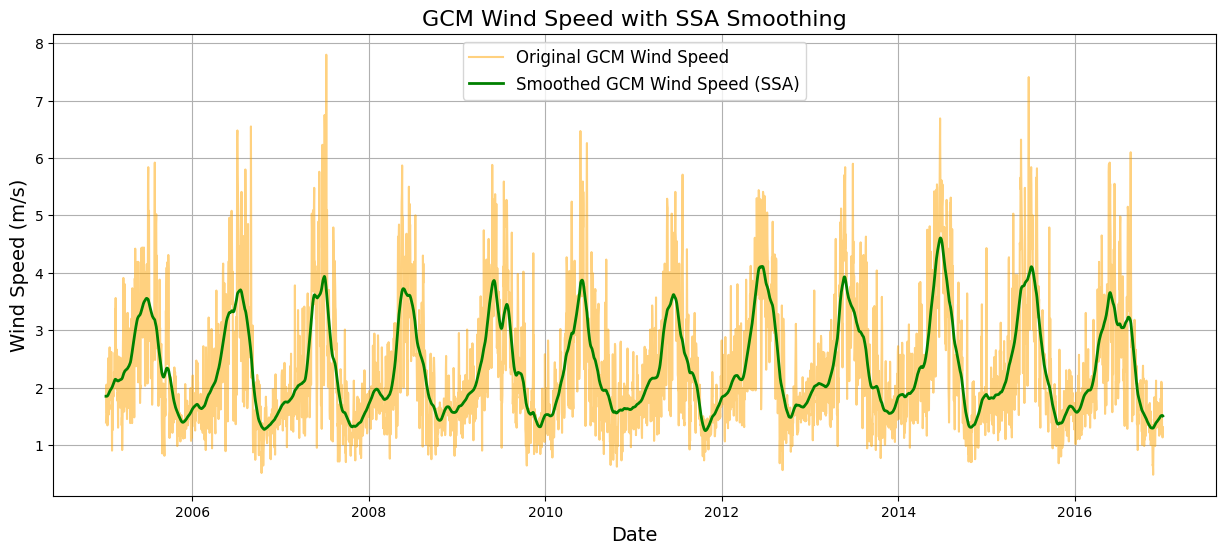

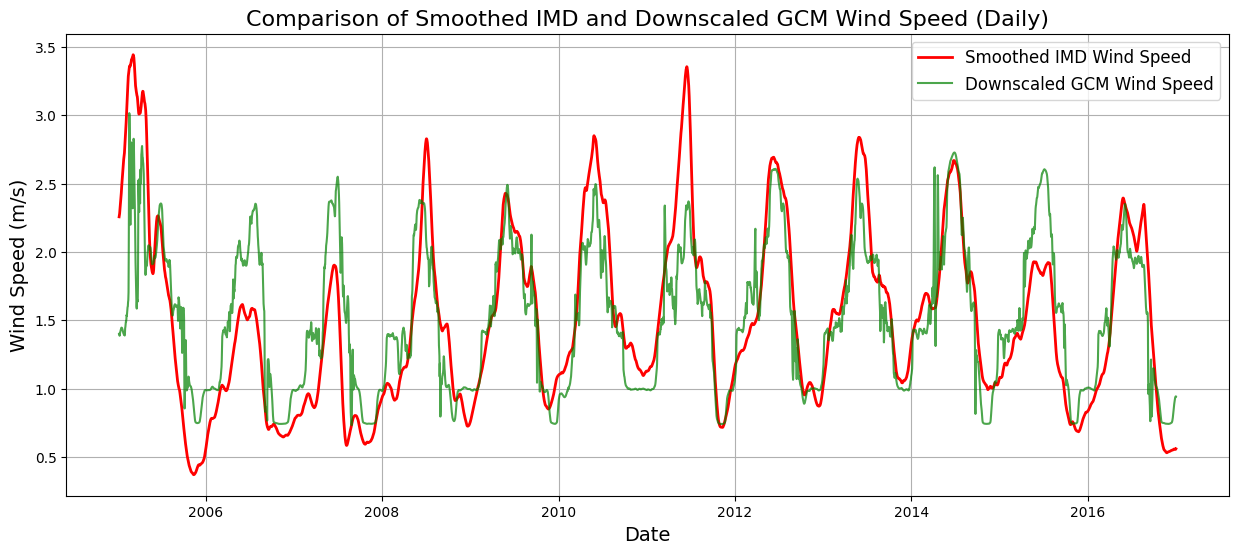

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Flatten, Input, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.losses import Huber
from pyts.decomposition import SingularSpectrumAnalysis

# Load dataset
file_path = "/content/drive/MyDrive/My Work/GCM_IMD_2005_2016_Wind_speed.csv"
data = pd.read_csv(file_path)

# Clean column names
data.columns = data.columns.str.strip()

# Convert date columns to a single datetime column
data['Date'] = pd.to_datetime(data[['YEAR', 'MONTH', 'DAY']], errors='coerce')
data.set_index('Date', inplace=True)

# Ensure no missing values in GCM_WIND_SPEED and IMD_Wind_Speed columns
if data[['GCM_WIND_SPEED', 'IMD_Wind_Speed']].isnull().any().any():
    print("Warning: Missing values detected. Dropping rows with missing values.")
    data = data.dropna(subset=['GCM_WIND_SPEED', 'IMD_Wind_Speed'])

# Apply SSA for IMD Wind Speed
imd_series = data['IMD_Wind_Speed'].values.reshape(1, -1)  # Reshape for SSA
ssa_imd = SingularSpectrumAnalysis(window_size=30)
imd_components = ssa_imd.fit_transform(imd_series)

# Reconstruct IMD wind speed (using the first component for trend)
imd_smoothed = imd_components[:, 0].flatten()  # Take the first component (trend)

# Apply SSA for GCM Wind Speed
gcm_series = data['GCM_WIND_SPEED'].values.reshape(1, -1)  # Reshape for SSA
ssa_gcm = SingularSpectrumAnalysis(window_size=30)
gcm_components = ssa_gcm.fit_transform(gcm_series)

# Reconstruct GCM wind speed (using the first component for trend)
gcm_smoothed = gcm_components[:, 0].flatten()  # Take the first component (trend)

# Add smoothed data to the original DataFrame
data['IMD_Smoothed'] = imd_smoothed
data['GCM_Smoothed'] = gcm_smoothed

# Prepare data for LSTM + CNN model with sliding window approach
sequence_length = 7
x, y = [], []
for i in range(len(data) - sequence_length):
    x.append(data['GCM_Smoothed'].values[i:i+sequence_length])
    y.append(data['IMD_Smoothed'].values[i + sequence_length])
x, y = np.array(x), np.array(y)

# Standardize the features
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x.reshape(-1, 1)).reshape(x.shape)

# Reshape data for CNN + LSTM
x_scaled = x_scaled.reshape((x_scaled.shape[0], x_scaled.shape[1], 1))

# Build LSTM + CNN model with improvements
model = Sequential()
model.add(Input(shape=(sequence_length, 1)))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(100, activation='relu', return_sequences=True)))
model.add(Dropout(0.4))
model.add(LSTM(50, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1))

# Compile the model with Huber loss
model.compile(optimizer='adam', loss=Huber())

# Train the model
model.fit(x_scaled, y, epochs=250, batch_size=16, verbose=1, validation_split=0.2)

# Predict IMD wind speed using downscaled GCM wind speed
predictions = model.predict(x_scaled)

# Create a new DataFrame for predictions with the correct index
# We shift the index by 'sequence_length' to align with the predictions
prediction_index = data.index[sequence_length:]
predictions_df = pd.DataFrame(predictions, index=prediction_index, columns=['Downscaled_GCM_WIND_SPEED'])

# Concatenate the predictions with the original DataFrame
data = pd.concat([data, predictions_df], axis=1)

# Handle NaN values before computing metrics
# Drop rows with NaN values in either 'IMD_Smoothed' or 'Downscaled_GCM_WIND_SPEED'
data = data.dropna(subset=['IMD_Smoothed', 'Downscaled_GCM_WIND_SPEED'])

# Compute statistical metrics for downscaled data
bias = data['Downscaled_GCM_WIND_SPEED'] - data['IMD_Smoothed']
mse = mean_squared_error(data['IMD_Smoothed'], data['Downscaled_GCM_WIND_SPEED'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(data['IMD_Smoothed'], data['Downscaled_GCM_WIND_SPEED'])
r2 = r2_score(data['IMD_Smoothed'], data['Downscaled_GCM_WIND_SPEED'])
correlation = data['IMD_Smoothed'].corr(data['Downscaled_GCM_WIND_SPEED'])

# Print statistical metrics
print("\nStatistical Metrics After Downscaling:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²): {r2:.2f}")
print(f"Correlation: {correlation:.2f}")

# Plot IMD wind speed
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['IMD_Wind_Speed'], label='Original IMD Wind Speed', color='blue', alpha=0.5)
plt.plot(data.index, data['IMD_Smoothed'], label='Smoothed IMD Wind Speed (SSA)', color='red', linewidth=2)
plt.title("IMD Wind Speed with SSA Smoothing", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Plot smoothed GCM wind speed
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['GCM_WIND_SPEED'], label='Original GCM Wind Speed', color='orange', alpha=0.5)
plt.plot(data.index, data['GCM_Smoothed'], label='Smoothed GCM Wind Speed (SSA)', color='green', linewidth=2)
plt.title("GCM Wind Speed with SSA Smoothing", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Combined plot for comparison
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['IMD_Smoothed'], label='Smoothed IMD Wind Speed', color='red', linewidth=2)
plt.plot(data.index, data['Downscaled_GCM_WIND_SPEED'], label='Downscaled GCM Wind Speed', color='green', alpha=0.7)
plt.title("Comparison of Smoothed IMD and Downscaled GCM Wind Speed (Daily)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()


Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0493 - mae: 0.1625 - val_loss: 0.0090 - val_mae: 0.0763
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0222 - mae: 0.1057 - val_loss: 0.0096 - val_mae: 0.0792
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0215 - mae: 0.1057 - val_loss: 0.0071 - val_mae: 0.0712
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0221 - mae: 0.1054 - val_loss: 0.0081 - val_mae: 0.0730
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0219 - mae: 0.1057 - val_loss: 0.0084 - val_mae: 0.0744
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0215 - mae: 0.1037 - val_loss: 0.0089 - val_mae: 0.0764
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0223 - mae: 0.1040 - val_loss: 0.0080 - val_mae: 0.0735
Epoch 8/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0222 - mae: 0.1046 - val_loss: 0.0072 - val_mae: 0.0718
Epoch 9/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms

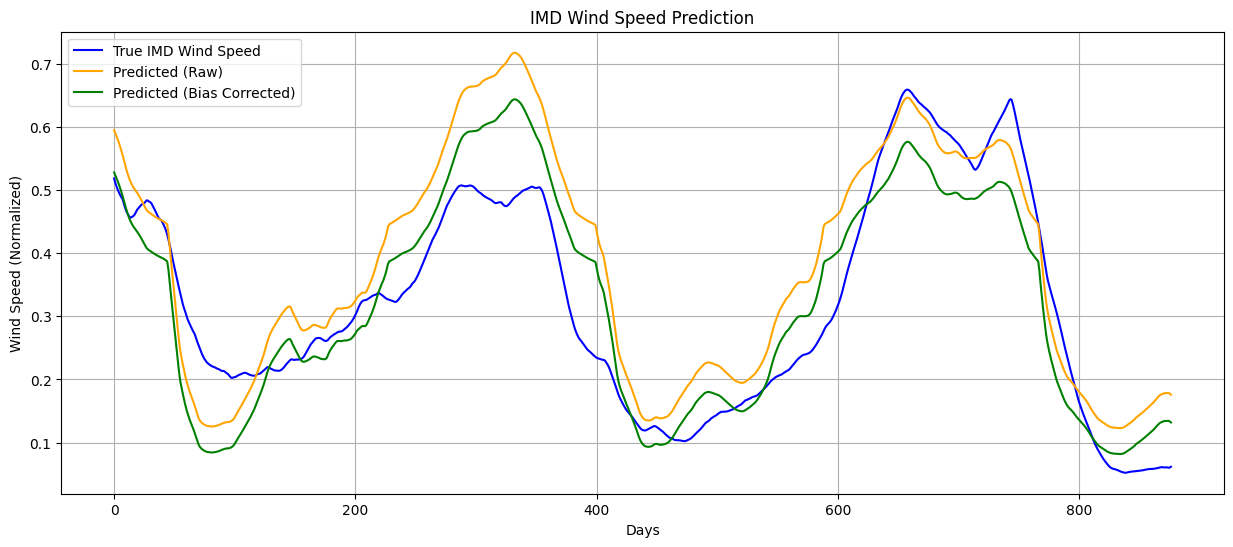

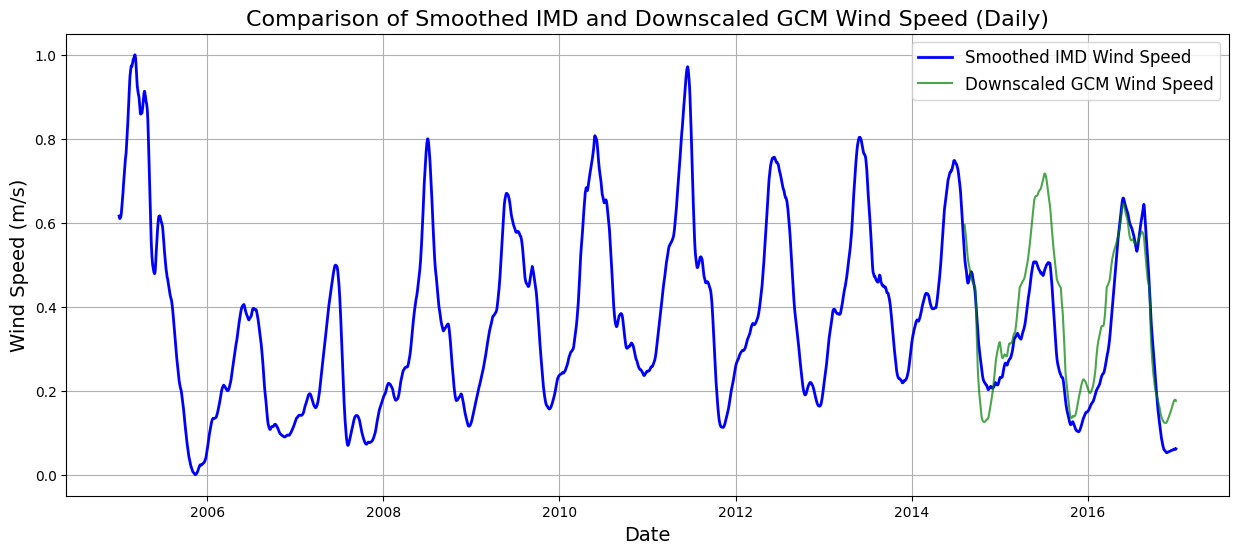

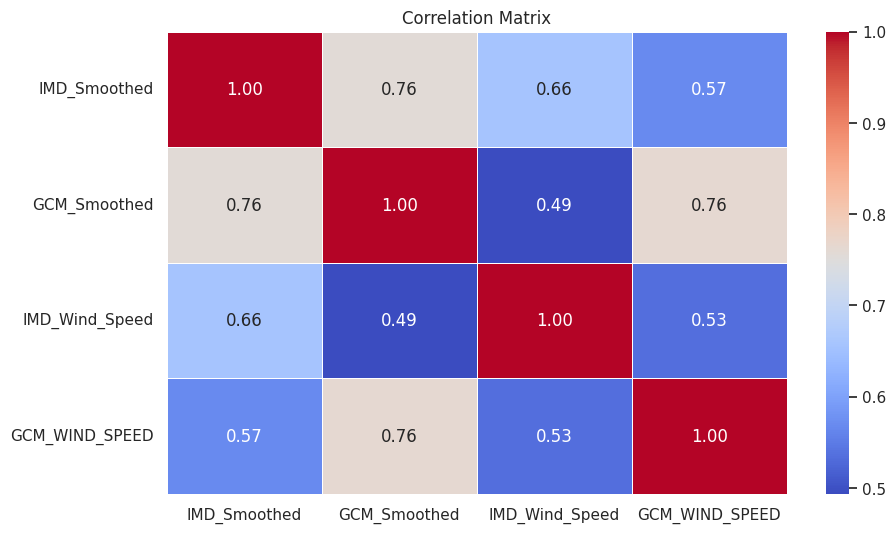

In [ ]:
import pandas as pd
import numpy as np
from pyts.decomposition import SingularSpectrumAnalysis
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Conv1D, Flatten, concatenate
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Load dataset
file_path = "/content/drive/MyDrive/My Work/GCM_IMD_2005_2016_Wind_speed.csv"
data = pd.read_csv(file_path)

# Clean column names and handle missing values
data.columns = data.columns.str.strip()
data.dropna(subset=['GCM_WIND_SPEED', 'IMD_Wind_Speed'], inplace=True)

# Convert date columns into a single datetime column
data['Date'] = pd.to_datetime(data[['YEAR', 'MONTH', 'DAY']], errors='coerce')
data.set_index('Date', inplace=True)

# Apply Singular Spectrum Analysis (SSA) for noise reduction
window_size = 30
ssa_gcm = SingularSpectrumAnalysis(window_size=window_size)
ssa_imd = SingularSpectrumAnalysis(window_size=window_size)

# Reshape the input data to have the correct dimensions for SSA
gcm_wind_speed = data['GCM_WIND_SPEED'].values.reshape(1, -1)
imd_wind_speed = data['IMD_Wind_Speed'].values.reshape(1, -1)

# Apply SSA and extract the smoothed components
gcm_smoothed = ssa_gcm.fit_transform(gcm_wind_speed)[0]
imd_smoothed = ssa_imd.fit_transform(imd_wind_speed)[0]

# Use the first component as smoothed data
data['GCM_Smoothed'] = gcm_smoothed[0]
data['IMD_Smoothed'] = imd_smoothed[0]

# Normalize data for machine learning
scaler = MinMaxScaler()
data[['GCM_Smoothed', 'IMD_Smoothed']] = scaler.fit_transform(data[['GCM_Smoothed', 'IMD_Smoothed']])

# Prepare input features and target
X = data['GCM_Smoothed'].values
y = data['IMD_Smoothed'].values

# Split into training and testing sets
split_idx = int(len(data) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Reshape for LSTM and CNN
X_train_lstm = X_train.reshape((X_train.shape[0], 1, 1))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, 1))
X_train_cnn = X_train.reshape((X_train.shape[0], 1, 1))
X_test_cnn = X_test.reshape((X_test.shape[0], 1, 1))

# Build LSTM-CNN hybrid model
input_lstm = Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]))
lstm_layer = LSTM(64, return_sequences=False)(input_lstm)

input_cnn = Input(shape=(X_train_cnn.shape[1], X_train_cnn.shape[2]))
cnn_layer = Conv1D(64, kernel_size=1, activation='relu')(input_cnn)
cnn_layer = Flatten()(cnn_layer)

# Combine LSTM and CNN outputs
combined = concatenate([lstm_layer, cnn_layer])
dense_layer = Dense(32, activation='relu')(combined)
output = Dense(1, activation='linear')(dense_layer)

model = Model(inputs=[input_lstm, input_cnn], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(
    [X_train_lstm, X_train_cnn], y_train,
    validation_data=([X_test_lstm, X_test_cnn], y_test),
    epochs=100,
    batch_size=32
)

# Bias correction using Quantile Mapping
def quantile_mapping(predicted, observed):
    pred_quantiles = norm.cdf(predicted, np.mean(predicted), np.std(predicted))
    corrected = norm.ppf(pred_quantiles, np.mean(observed), np.std(observed))
    return corrected

# Apply bias correction
predicted = model.predict([X_test_lstm, X_test_cnn]).flatten()
bias_corrected = quantile_mapping(predicted, y_test)

# Add predictions to the DataFrame for visualization
data['Downscaled_GCM_WIND_SPEED'] = np.nan
data.loc[data.index[split_idx:], 'Downscaled_GCM_WIND_SPEED'] = predicted

# Evaluate metrics
mse = mean_squared_error(y_test, predicted)
mse_corrected = mean_squared_error(y_test, bias_corrected)
rmse = np.sqrt(mse)
rmse_corrected = np.sqrt(mse_corrected)
mae = mean_absolute_error(y_test, predicted)
mae_corrected = mean_absolute_error(y_test, bias_corrected)
r2 = r2_score(y_test, predicted)
r2_corrected = r2_score(y_test, bias_corrected)
correlation = np.corrcoef(y_test, predicted)[0, 1]
correlation_corrected = np.corrcoef(y_test, bias_corrected)[0, 1]

print("Before Bias Correction:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²): {r2:.2f}")
print(f"Correlation: {correlation:.2f}")

print("\nAfter Bias Correction:")
print(f"Mean Squared Error (MSE): {mse_corrected:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_corrected:.2f}")
print(f"Mean Absolute Error (MAE): {mae_corrected:.2f}")
print(f"R-squared (R²): {r2_corrected:.2f}")
print(f"Correlation: {correlation_corrected:.2f}")

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(y_test, label='True IMD Wind Speed', color='blue')
plt.plot(predicted, label='Predicted (Raw)', color='orange')
plt.plot(bias_corrected, label='Predicted (Bias Corrected)', color='green')
plt.title("IMD Wind Speed Prediction")
plt.xlabel("Days")
plt.ylabel("Wind Speed (Normalized)")
plt.legend()
plt.grid()
plt.show()

# Combined plot for comparison
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['IMD_Smoothed'], label='Smoothed IMD Wind Speed', color='blue', linewidth=2)
plt.plot(data.index, data['Downscaled_GCM_WIND_SPEED'], label='Downscaled GCM Wind Speed', color='green', alpha=0.7)
plt.title("Comparison of Smoothed IMD and Downscaled GCM Wind Speed (Daily)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Wind Speed (m/s)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

sns.set(style="whitegrid")
correlation_matrix = data[['IMD_Smoothed', 'GCM_Smoothed', 'IMD_Wind_Speed', 'GCM_WIND_SPEED']].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


Before Smoothing Results:
                Method  MSE  RMSE  MAE  R-squared  Correlation
     Linear Regression 0.79  0.89 0.60       0.29         0.53
         Random Forest 0.67  0.82 0.56       0.40         0.63
     Gradient Boosting 0.71  0.84 0.57       0.36         0.60
         Decision Tree 0.77  0.88 0.59       0.31         0.55
Support Vector Machine 0.82  0.91 0.57       0.26         0.54
       Hybrid LSTM+CNN 0.20  0.45 0.27       0.82         0.90

After Smoothing Results:
                Method  MSE  RMSE  MAE  R-squared  Correlation
     Linear Regression 0.18  0.43 0.31       0.57         0.76
         Random Forest 0.03  0.18 0.13       0.92         0.96
     Gradient Boosting 0.14  0.37 0.27       0.68         0.82
         Decision Tree 0.15  0.39 0.28       0.64         0.80
Support Vector Machine 0.17  0.41 0.29       0.60         0.78
       Hybrid LSTM+CNN 0.01  0.08 0.06       0.80         0.90

Combined Results:
                Method  MSE (Before)  MSE (Afte

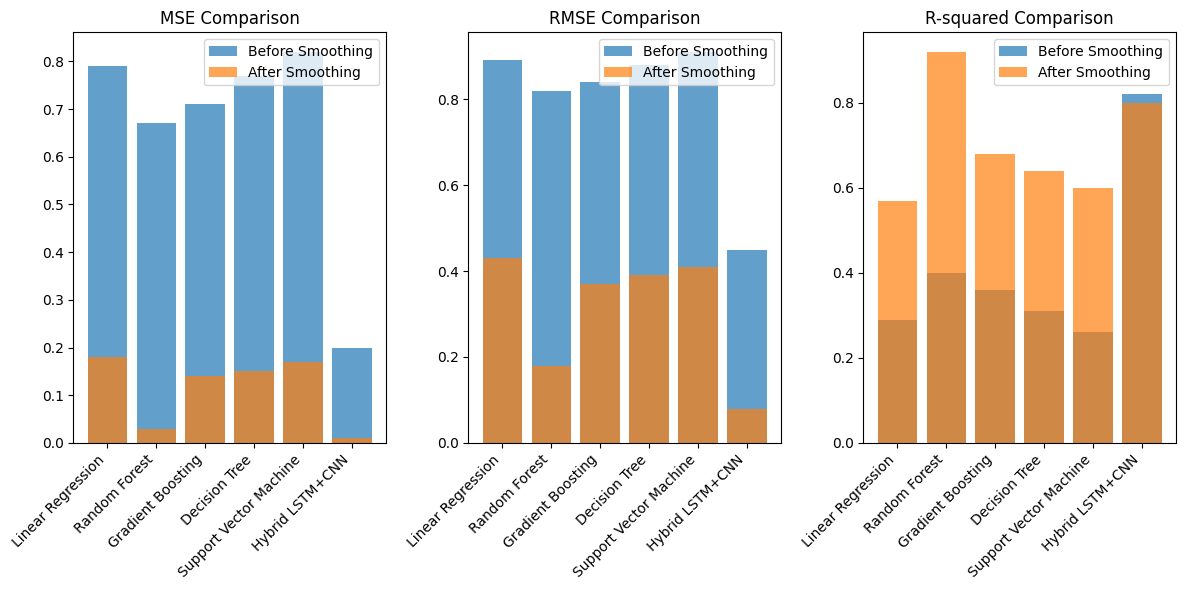


Performance Analysis:
Best Method Before Smoothing:
Method: Hybrid LSTM+CNN
R-squared: 0.82
Correlation: 0.9

Best Method After Smoothing:
Method: Random Forest
R-squared: 0.92
Correlation: 0.96


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the results data
methods = [
    'Linear Regression',
    'Random Forest',
    'Gradient Boosting',
    'Decision Tree',
    'Support Vector Machine',
    'Hybrid LSTM+CNN'
]

# Before Smoothing Results
before_smoothing = {
    'Method': methods,
    'MSE': [0.79, 0.67, 0.71, 0.77, 0.82, 0.20],
    'RMSE': [0.89, 0.82, 0.84, 0.88, 0.91, 0.45],
    'MAE': [0.60, 0.56, 0.57, 0.59, 0.57, 0.27],
    'R-squared': [0.29, 0.40, 0.36, 0.31, 0.26, 0.82],
    'Correlation': [0.53, 0.63, 0.60, 0.55, 0.54, 0.90]
}

# After Smoothing Results
after_smoothing = {
    'Method': methods,
    'MSE': [0.18, 0.03, 0.14, 0.15, 0.17, 0.01],
    'RMSE': [0.43, 0.18, 0.37, 0.39, 0.41, 0.08],
    'MAE': [0.31, 0.13, 0.27, 0.28, 0.29, 0.06],
    'R-squared': [0.57, 0.92, 0.68, 0.64, 0.60, 0.80],
    'Correlation': [0.76, 0.96, 0.82, 0.80, 0.78, 0.90]
}

# Create DataFrames
df_before = pd.DataFrame(before_smoothing)
df_after = pd.DataFrame(after_smoothing)
df_combined = pd.DataFrame({
    'Method': methods,
    'MSE (Before)': before_smoothing['MSE'],
    'MSE (After)': after_smoothing['MSE'],
    'RMSE (Before)': before_smoothing['RMSE'],
    'RMSE (After)': after_smoothing['RMSE'],
    'R-squared (Before)': before_smoothing['R-squared'],
    'R-squared (After)': after_smoothing['R-squared']
})

# Visualization Function
def create_comparison_plot(df_combined):
    plt.figure(figsize=(12, 6))

    # MSE Comparison
    plt.subplot(1, 3, 1)
    plt.bar(df_combined['Method'], df_combined['MSE (Before)'], label='Before Smoothing', alpha=0.7)
    plt.bar(df_combined['Method'], df_combined['MSE (After)'], label='After Smoothing', alpha=0.7)
    plt.title('MSE Comparison')
    plt.xticks(rotation=45, ha='right')
    plt.legend()

    # RMSE Comparison
    plt.subplot(1, 3, 2)
    plt.bar(df_combined['Method'], df_combined['RMSE (Before)'], label='Before Smoothing', alpha=0.7)
    plt.bar(df_combined['Method'], df_combined['RMSE (After)'], label='After Smoothing', alpha=0.7)
    plt.title('RMSE Comparison')
    plt.xticks(rotation=45, ha='right')
    plt.legend()

    # R-squared Comparison
    plt.subplot(1, 3, 3)
    plt.bar(df_combined['Method'], df_combined['R-squared (Before)'], label='Before Smoothing', alpha=0.7)
    plt.bar(df_combined['Method'], df_combined['R-squared (After)'], label='After Smoothing', alpha=0.7)
    plt.title('R-squared Comparison')
    plt.xticks(rotation=45, ha='right')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Save Results to CSV
df_before.to_csv('downscaling_before_smoothing.csv', index=False)
df_after.to_csv('downscaling_after_smoothing.csv', index=False)
df_combined.to_csv('downscaling_combined_results.csv', index=False)

# Print Tables
print("Before Smoothing Results:")
print(df_before.to_string(index=False))
print("\nAfter Smoothing Results:")
print(df_after.to_string(index=False))
print("\nCombined Results:")
print(df_combined.to_string(index=False))

# Create Visualization
create_comparison_plot(df_combined)

# Performance Analysis
def analyze_performance(df_before, df_after):
    print("\nPerformance Analysis:")
    print("Best Method Before Smoothing:")
    best_before = df_before.iloc[df_before['R-squared'].argmax()]
    print(f"Method: {best_before['Method']}")
    print(f"R-squared: {best_before['R-squared']}")
    print(f"Correlation: {best_before['Correlation']}")

    print("\nBest Method After Smoothing:")
    best_after = df_after.iloc[df_after['R-squared'].argmax()]
    print(f"Method: {best_after['Method']}")
    print(f"R-squared: {best_after['R-squared']}")
    print(f"Correlation: {best_after['Correlation']}")

analyze_performance(pd.DataFrame(before_smoothing), pd.DataFrame(after_smoothing))